시공간 정보로부터 사고위험도(ECLO)를 예측하는 AI 알고리즘

In [2]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.1 MB/s eta 0:00:00


In [3]:
import optuna
import xgboost as xgb
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

train_org = pd.read_csv('/content/drive/MyDrive/colab/daegu_traffic/train.csv')
train_org = train_org.drop(columns=train_org.iloc[:,8:22])
test_org = pd.read_csv('/content/drive/MyDrive/colab/daegu_traffic/test.csv')
train_org.info()
test_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39609 entries, 0 to 39608
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      39609 non-null  object
 1   사고일시    39609 non-null  object
 2   요일      39609 non-null  object
 3   기상상태    39609 non-null  object
 4   시군구     39609 non-null  object
 5   도로형태    39609 non-null  object
 6   노면상태    39609 non-null  object
 7   사고유형    39609 non-null  object
 8   ECLO    39609 non-null  int64 
dtypes: int64(1), object(8)
memory usage: 2.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10963 entries, 0 to 10962
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      10963 non-null  object
 1   사고일시    10963 non-null  object
 2   요일      10963 non-null  object
 3   기상상태    10963 non-null  object
 4   시군구     10963 non-null  object
 5   도로형태    10963 non-null  object
 6   노면상태    10963 non-null  object
 7   사고유형    1

In [45]:
#텍스트 나누기

train_df = train_org.copy()
test_df = test_org.copy()

time_pattern = r'(\d{4})-(\d{1,2})-(\d{1,2}) (\d{1,2})'

train_df[['연', '월', '일', '시간']] = train_org['사고일시'].str.extract(time_pattern)
train_df[['연', '월', '일', '시간']] = train_df[['연', '월', '일', '시간']].apply(pd.to_numeric) # 추출된 문자열을 수치화해줍니다
train_df = train_df.drop(columns=['사고일시']) # 정보 추출이 완료된 '사고일시' 컬럼은 제거합니다

# 해당 과정을 test_x에 대해서도 반복해줍니다
test_df[['연', '월', '일', '시간']] = test_org['사고일시'].str.extract(time_pattern)
test_df[['연', '월', '일', '시간']] = test_df[['연', '월', '일', '시간']].apply(pd.to_numeric)
test_df = test_df.drop(columns=['사고일시'])

display(f"columns of train_df : {train_df.columns}")
display(f"columns of test_df : {test_df.columns}")

location_pattern = r'(\S+) (\S+) (\S+)'

train_df[['도시', '구', '동']] = train_org['시군구'].str.extract(location_pattern)
train_df = train_df.drop(columns=['시군구'])

test_df[['도시', '구', '동']] = test_org['시군구'].str.extract(location_pattern)
test_df = test_df.drop(columns=['시군구'])

display(f"columns of train_df : {train_df.columns}")
display(f"columns of test_df : {test_df.columns}")

road_pattern = r'(.+) - (.+)'

train_df[['도로형태1', '도로형태2']] = train_org['도로형태'].str.extract(road_pattern)
train_df = train_df.drop(columns=['도로형태'])

test_df[['도로형태1', '도로형태2']] = test_org['도로형태'].str.extract(road_pattern)
test_df = test_df.drop(columns=['도로형태'])

display(f"columns of train_df : {train_df.columns}")
display(f"columns of test_df : {test_df.columns}")

"columns of train_df : Index(['ID', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형', 'ECLO', '연', '월',\n       '일', '시간'],\n      dtype='object')"

"columns of test_df : Index(['ID', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형', '연', '월', '일', '시간'], dtype='object')"

"columns of train_df : Index(['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', 'ECLO', '연', '월', '일', '시간',\n       '도시', '구', '동'],\n      dtype='object')"

"columns of test_df : Index(['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시',\n       '구', '동'],\n      dtype='object')"

"columns of train_df : Index(['ID', '요일', '기상상태', '노면상태', '사고유형', 'ECLO', '연', '월', '일', '시간', '도시',\n       '구', '동', '도로형태1', '도로형태2'],\n      dtype='object')"

"columns of test_df : Index(['ID', '요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구', '동',\n       '도로형태1', '도로형태2'],\n      dtype='object')"

트레인 테스트에 cctv정보추가

In [47]:
light_org = pd.read_csv('/content/drive/MyDrive/colab/daegu_traffic/external_open/대구 보안등 정보.csv' ,encoding='cp949')
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

light_org[['도시', '구', '동','번지']] = light_org['소재지지번주소'].str.extract(location_pattern)
light_org = light_org.drop(columns=['소재지지번주소'])
light_org

,보안등위치명,설치개수,소재지도로명주소,위도,경도,설치연도,설치형태,도시,구,동,번지
0,대명1동1,1,대구광역시 남구 현충로 155,35.846703,128.579803,2016.0,한전주,대구광역시,남구,대명동,1722-4
1,대명1동2,1,대구광역시 남구 현충로31길 10-1,35.846863,128.579406,2016.0,한전주,대구광역시,남구,대명동,1723-11
2,대명1동3,1,대구광역시 남구 현충로31길 9-8,35.846341,128.579342,2017.0,건축물,대구광역시,남구,대명동,1722-56
3,대명1동4,2,대구광역시 남구 현충로31길 19-11,35.846368,128.578922,2016.0,한전주,대구광역시,남구,대명동,1722-41
4,대명1동5,1,대구광역시 남구 현충로29길 22-2,35.845995,128.578858,2016.0,한전주,대구광역시,남구,대명동,1721-22
...,...,...,...,...,...,...,...,...,...,...,...
71908,대봉2동 165-9,1,NaN,35.857556,128.600023,NaN,한전주,대구광역시,중구,대봉동,165-9
71909,대봉2동 88-85,1,NaN,35.859205,128.600046,NaN,한전주,대구광역시,중구,대봉동,88-85
71910,대봉2동 719-20,1,NaN,35.859442,128.599627,NaN,한전주,대구광역시,중구,대봉동,719-20
71911,대봉2동 738-13,1,NaN,35.858244,128.597614,2010.0,건축물,대구광역시,중구,대봉동,738-13


In [ ]:
#동마다 보안등 갯수 해가 떠있는 6시와 18시는 영향을 주지않으므로 0으로 처리했음 차리 있고
#단순 보안등 갯수 / 밤에만 보안등 처리 6시와 18시는 0으로 처리함 / 밤과 낮을 0,1로 처리하고 밤에다가 다 보안등 갯수를 적어놓은것
light_df = {'동':[],
           '설치개수':[]}
light_df = pd.DataFrame(light_df)
light_list = []
for i in light_org['동'].unique() :
  if (train_df['시간'] >= 18) | (train_df['시간'] >= 0 & train_df['시간'] <= 6) :
    light_list.append((light_org[light_org['동']==i]['설치개수'].value_counts().sum()))
  else :
    light_list.append(0)



light_df['동'] = light_org['동'].unique()
light_df['설치개수'] = light_list
light_df = light_df.dropna(axis=0) #nan값이 하나 있어서

#train, test cctv_list 추가

train_df = pd.merge(train_df, light_df, on='동', how='left')
print(train_df.shape)
train_df = train_df.fillna(0)
print(train_df.isnull().sum())

test_df = pd.merge(test_df, light_df, on='동', how='left')
print(test_df.shape)
test_df = test_df.fillna(0)
print(test_df.isnull().sum())


In [57]:
child_df = pd.read_csv('/content/drive/MyDrive/colab/daegu_traffic/external_open/대구_어린이_보호_구역_정보.csv', encoding='cp949')
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

child_df[['도시', '구', '동','번지']] = child_df['소재지지번주소'].str.extract(location_pattern)
child_df = child_df.drop(columns=['소재지지번주소'])
child_df

,시설종류,대상시설명,소재지도로명주소,위도,경도,관리기관명,관할경찰서명,CCTV설치여부,CCTV설치대수,보호구역도로폭,데이터기준일자,도시,구,동,번지
0,초등학교,남도초등학교,대구광역시 남구 현충동길 74(대명동),35.845027,128.581402,대구광역시,남부경찰서,Y,7.0,6~8,2020-03-23,대구광역시,남구,대명동,1709
1,초등학교,영선초등학교,대구광역시 남구 영선길96(이천동),35.852901,128.596014,대구광역시,남부경찰서,Y,8.0,6~10,2020-03-23,대구광역시,남구,이천동,477
2,초등학교,성명초등학교,대구광역시 남구 성당로 30길 55(대명동),35.845152,128.570825,대구광역시,남부경찰서,Y,14.0,8~12,2020-03-23,대구광역시,남구,대명동,3050
3,초등학교,남덕초등학교,대구광역시 남구 앞산순환로 93길 33,35.833042,128.573949,대구광역시,남부경찰서,Y,6.0,6~8,2020-03-23,대구광역시,남구,대명동,531-1
4,초등학교,대명초등학교,대구광역시 남구 대명로 110,35.838869,128.568889,대구광역시,남부경찰서,Y,5.0,6~10,2020-03-23,대구광역시,남구,대명동,960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,어린이집,남산교회어린이집,대구광역시 중구 관덕정길 16,35.865040,128.590565,대구광역시 중구청,대구광역시 중부경찰서,Y,5.0,6~10,2019-06-01,대구광역시,중구,남산동,941-1
636,초등학교,대구초등학교,대구광역시 중구 명륜로23길 80,35.864037,128.595370,대구광역시 중구청,대구광역시 중부경찰서,Y,12.0,3~12,2019-06-01,대구광역시,중구,봉산동,57
637,어린이집,대구삼성어린이집,대구광역시 중구 달구벌대로 2016-40,35.864469,128.584301,대구광역시 중구청,대구광역시 중부경찰서,Y,2.0,7~8,2019-06-01,대구광역시,중구,남산동,153-2
638,어린이집,동화나라어린이집,대구광역시 중구 남산로3안길 20,35.860371,128.577492,대구광역시 중구청,대구광역시 중부경찰서,Y,5.0,6~8,2019-06-01,대구광역시,중구,남산동,2623-6


In [ ]:
print(child_df['CCTV설치대수'].unique()) #4는 주차카메라
print(child_df['동'].unique())
print(train_df['동'].unique())

[ 7.  8. 14.  6.  5.  9. 10.  4.  2.  3.  1.  0. 11. nan 12.]
['대명동' '이천동' '봉덕동' '가창면' '구지면' '옥포면' '논공읍' '화원읍' '다사읍' '하빈면' '유가읍' '현풍면'
 nan '태전동' '구암동' '복현동' '관음동' '읍내동' '산격동' '국우동' '침산동' '매천동' '동천동' '사수동'
 '동변동' '서변동' '학정동' '대현동' '검단동' '노원동1가' '도남동' '고성동2가' '칠성동2가' '조야동' '팔달동'
 '고성동1가' '내당동' '중리동' '원대동1가' '비산동' '평리동' '이현동' '수성동4가' '노변동' '황금동' '만촌동'
 '범어동' '수성동1가' '두산동' '신매동' '파동' '상동' '매호동' '욱수동' '지산동' '중동' '시지동' '범물동'
 '수성동3가' '사월동' '수성동2가' '수창동' '남산동' '서문로1가' '삼덕동3가' '동인동4가' '봉산동' '대신동'
 '삼덕동2가' '남일동' '덕산동' '동산동']
['대신동' '감삼동' '두산동' '복현동' '신암동' '지산동' '상인동' '태전동' '지묘동' '평리동' '신기동' '상리동'
 '월성동' '황금동' '구암동' '신천동' '만촌동' '남산동' '비산동' '침산동' '두류동' '신매동' '대곡동' '유가읍'
 '논공읍' '율하동' '시지동' '봉무동' '다사읍' '동산동' '이현동' '이천동' '수성동4가' '노원동3가' '서변동'
 '관음동' '학정동' '파동' '상동' '이곡동' '효목동' '읍내동' '남성로' '죽전동' '대명동' '동천동' '지저동'
 '사수동' '덕산동' '본리동' '용계동' '범어동' '신당동' '성당동' '용산동' '태평로3가' '도학동' '욱수동' '불로동'
 '칠성동1가' '장기동' '매호동' '대천동' '삼덕동1가' '수성동2가' '팔달동' '삼덕동' '진천동' '수성동3가' '가창면'
 '방촌동' '산격동' '월암동' '현풍읍' '구지면' '매천동' '송

In [58]:
child_cctv_df = {'동':[],
                 '어린이CCTV설치대수':[]}
child_cctv_df = pd.DataFrame(child_cctv_df)

#동마다 CCTV 갯수 넣을꺼
temp_list = []
for i in child_df['동'].unique() :
  temp_list.append(len(child_df[child_df['동']==i].loc[:,'CCTV설치대수']))

child_cctv_df['동'] = child_df['동'].unique()
child_cctv_df['어린이CCTV설치대수'] = temp_list
child_cctv_df = child_cctv_df.dropna(axis=0) #nan값이 하나 있어서

#train, test 어린이cctv여부 추가

train_df = pd.merge(train_df, child_cctv_df, on='동', how='left')
print(train_df.shape)
train_df = train_df.fillna(0)

test_df = pd.merge(test_df, child_cctv_df, on='동', how='left')
print(test_df.shape)
test_df = test_df.fillna(0)

(39609, 17)
(10963, 16)


In [59]:
cctv_df = pd.read_csv('/content/drive/MyDrive/colab/daegu_traffic/external_open/대구_CCTV_정보.csv', encoding='cp949')
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

cctv_df[['도시', '구', '동','번지']] = cctv_df['소재지지번주소'].str.extract(location_pattern)
cctv_df = cctv_df.drop(columns=['소재지지번주소'])
cctv_df

,무인교통단속카메라관리번호,시도명,시군구명,도로종류,도로노선번호,도로노선명,도로노선방향,소재지도로명주소,위도,경도,...,단속구분,제한속도,단속구간위치구분,과속단속구간길이,보호구역구분,설치연도,도시,구,동,번지
0,주차12,대구광역시,남구,시도,NaN,대명로,3,대구광역시 남구 대명로 162,35.838857,128.575418,...,4,0,NaN,NaN,99.0,2010.0,대구광역시,남구,대명동,903-13
1,주차13,대구광역시,남구,시도,NaN,봉덕로,3,대구광역시 남구 봉덕로 135,35.844653,128.604619,...,4,0,NaN,NaN,99.0,2013.0,대구광역시,남구,봉덕동,853-8
2,주차14,대구광역시,남구,시도,NaN,대봉로,3,대구광역시 남구 봉덕로 134,35.844183,128.604815,...,4,0,NaN,NaN,99.0,2013.0,대구광역시,남구,봉덕동,866-46
3,주차15,대구광역시,남구,시도,NaN,큰골길,3,대구광역시 남구 큰골길 200,35.834798,128.585284,...,4,0,NaN,NaN,99.0,2014.0,대구광역시,남구,대명동,2680-17
4,주차16,대구광역시,남구,시도,NaN,큰골길,3,대구광역시 남구 큰골길 243,35.832728,128.588324,...,4,0,NaN,NaN,99.0,2014.0,대구광역시,남구,봉덕동,1616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1060,H2418,대구광역시,북구,특별시도,NaN,태암남로,1,대구광역시 북구 태암남로 41,35.925294,128.552023,...,2,40,NaN,NaN,99.0,2021.0,대구광역시,북구,구암동,671-8
1061,H2419,대구광역시,북구,특별시도,NaN,내곡로,1,대구광역시 북구 내곡로 90,35.900977,128.513825,...,2,30,NaN,NaN,2.0,2021.0,대구광역시,북구,사수동,812
1062,H4145,대구광역시,북구,특별시도,NaN,대현로,2,대구광역시 북구 대현로 100,35.882191,128.609791,...,2,30,NaN,NaN,2.0,2021.0,대구광역시,북구,대현동,270-8
1063,H4146,대구광역시,북구,특별시도,NaN,대현로,1,대구광역시 북구 대현로 118,35.881737,128.611651,...,2,30,NaN,NaN,2.0,2021.0,대구광역시,북구,대현동,270-3


In [ ]:
print(cctv_df['단속구분'].unique()) #4는 주차카메라

[ 4  1  2 99]


In [60]:
cctv_list = {'동':[],
             'CCTV개수':[]}
cctv_list = pd.DataFrame(cctv_list)
#동마다 CCTV 갯수 넣을꺼
temp_list = []
for i in cctv_df['동'].unique() :
  temp_list.append(len(cctv_df[(cctv_df['동']==i)&((cctv_df['단속구분']==2)|(cctv_df['단속구분']==1)|(cctv_df['단속구분']==99))]))

cctv_list['동'] = cctv_df['동'].unique()
cctv_list['CCTV개수'] = temp_list
cctv_list = cctv_list.dropna(axis=0) #nan값이 하나 있어서

#train, test cctv_list 추가

train_df = pd.merge(train_df, cctv_list, on='동', how='left')
print(train_df.shape)
train_df = train_df.fillna(0)

test_df = pd.merge(test_df, cctv_list, on='동', how='left')
print(test_df.shape)
test_df = test_df.fillna(0)

(39609, 18)
(10963, 17)


In [61]:
#동마다 CCTV 제한속도 평균
speed_df = {'동':[],
             '평균속도':[]}
speed_df = pd.DataFrame(speed_df)
speed_list = []
for i in cctv_df['동'].unique() :
  temp_list = []
  count_list = []
  temp = 0
  sum_list = []
  for j in [30,50,60,70,80,100] :
    temp_list.append(len(cctv_df[(cctv_df['제한속도']==j)&(cctv_df['동']== i)])*j)
    temp += (len(cctv_df[(cctv_df['제한속도']==j)&(cctv_df['동']== i)]))
    #print(temp_list)
    #print(temp)

  sum_list = sum(temp_list)
  if temp != 0 :
    speed_list.append(sum_list/temp)
  else:
    speed_list.append(38)
  #print(speed_list)
#len(speed_list)

speed_df['동'] = cctv_df['동'].unique()
speed_df['평균속도'] = speed_list
speed_df = speed_df.dropna(axis=0) #nan값이 하나 있어서

#train, test cctv_list 추가

train_df = pd.merge(train_df, speed_df, on='동', how='left')
print(train_df.shape)
train_df = train_df.fillna(0)
print(train_df.isnull().sum())

test_df = pd.merge(test_df, speed_df, on='동', how='left')
print(test_df.shape)
test_df = test_df.fillna(0)
print(test_df.isnull().sum())


(39609, 19)
ID             0
요일             0
기상상태           0
노면상태           0
사고유형           0
ECLO           0
연              0
월              0
일              0
시간             0
도시             0
구              0
동              0
도로형태1          0
도로형태2          0
설치개수           0
어린이CCTV설치대수    0
CCTV개수         0
평균속도           0
dtype: int64
(10963, 18)
ID             0
요일             0
기상상태           0
노면상태           0
사고유형           0
연              0
월              0
일              0
시간             0
도시             0
구              0
동              0
도로형태1          0
도로형태2          0
설치개수           0
어린이CCTV설치대수    0
CCTV개수         0
평균속도           0
dtype: int64


In [ ]:
print(train_df['기상상태'].unique())
print(train_df['노면상태'].unique())
print(train_df['사고유형'].unique())
print(train_df['ECLO'].unique())
print(train_df['도로형태1'].unique())
print(train_df['도로형태2'].unique())
print(train_df['기상상태'].value_counts())
print(train_df['노면상태'].value_counts())
print(train_df['사고유형'].value_counts())
print(train_df['도로형태1'].value_counts())
print(train_df['도로형태2'].value_counts())

['맑음' '흐림' '기타' '비' '안개' '눈']
['건조' '젖음/습기' '서리/결빙' '기타' '침수' '적설']
['차대사람' '차대차' '차량단독']
[ 5  3  6 18  9  8 15  2  1  7  4 12 13 10 11 16 40 22 21 17 25 14 20 27
 19 24 26 23 28 31 30 47 36 33 34 35 37 65 56 32 57 45 52 74 39 66]
['단일로' '교차로' '기타' '주차장' '미분류']
['기타' '교차로안' '터널' '지하차도(도로)내' '교량' '교차로횡단보도내' '주차장' '교차로부근' '고가도로위' '미분류']
맑음    36184
비      2635
흐림      738
기타       34
안개       10
눈         8
Name: 기상상태, dtype: int64
건조       36423
젖음/습기     3104
기타          51
서리/결빙       25
침수           3
적설           3
Name: 노면상태, dtype: int64
차대차     31785
차대사람     6833
차량단독      991
Name: 사고유형, dtype: int64
단일로    20233
교차로    17153
기타      1986
주차장      236
미분류        1
Name: 도로형태1, dtype: int64
기타           21478
교차로안          9931
교차로부근         5746
교차로횡단보도내      1474
지하차도(도로)내      309
주차장            236
교량             232
고가도로위          138
터널              64
미분류              1
Name: 도로형태2, dtype: int64


기상상태 비이고 노면상태 기타 경우 젖음/습기로 변경<br>
미분류 도로 가장 많은 도로형태로 수정

In [62]:
train_df.loc[4185,'노면상태'] = '젖음/습기'
train_df.loc[5135,'노면상태'] = '젖음/습기'
train_df.loc[6892,'노면상태'] = '젖음/습기'
train_df.loc[33750,'노면상태'] = '젖음/습기'
train_df.loc[35213,'노면상태'] = '젖음/습기'
train_df.loc[36407,'노면상태'] = '젖음/습기'

In [ ]:
train_df[train_df['동'] == '내당동']['도로형태1'].value_counts()
train_df[train_df['동'] == '다사읍']['도로형태1'].value_counts()


#내당동 관음동 신매동 파동 노원동3가 단일로, 율하동, 다사읍 교차로

교차로    395
단일로    299
기타      81
주차장     16
미분류      1
Name: 도로형태1, dtype: int64

In [63]:
#만총동만 test로 미분류 임

train_df.loc[983,'도로형태1'] = '단일로'
train_df.loc[1084,'도로형태1'] = '단일로'
train_df.loc[12779,'도로형태1'] = '교차로'
train_df.loc[15742,'도로형태1'] = '단일로'
train_df.loc[16924,'도로형태1'] = '단일로'
train_df.loc[21393,'도로형태1'] = '단일로'
train_df.loc[26090,'도로형태1'] = '교차로'

In [ ]:
train_df[(train_df['동'] == '다사읍') & (train_df['도로형태1'] == '단일로')]['도로형태2'].value_counts()

기타       293
교량         4
고가도로위      1
터널         1
Name: 도로형태2, dtype: int64

In [64]:
train_df.loc[983,'도로형태2'] = '기타'
train_df.loc[1084,'도로형태2'] = '기타'
train_df.loc[12779,'도로형태2'] = '기타'
train_df.loc[15742,'도로형태2'] = '기타'
train_df.loc[16924,'도로형태2'] = '기타'
train_df.loc[21393,'도로형태2'] = '기타'
train_df.loc[26090,'도로형태2'] = '기타'

추가 EDA

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39609 entries, 0 to 39608
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           39609 non-null  object 
 1   요일           39609 non-null  object 
 2   기상상태         39609 non-null  object 
 3   노면상태         39609 non-null  object 
 4   사고유형         39609 non-null  object 
 5   ECLO         39609 non-null  int64  
 6   연            39609 non-null  int64  
 7   월            39609 non-null  int64  
 8   일            39609 non-null  int64  
 9   시간           39609 non-null  int64  
 10  도시           39609 non-null  object 
 11  구            39609 non-null  object 
 12  동            39609 non-null  object 
 13  도로형태1        39609 non-null  object 
 14  도로형태2        39609 non-null  object 
 15  어린이CCTV설치대수  39609 non-null  float64
 16  CCTV개수       39609 non-null  float64
dtypes: float64(2), int64(5), object(10)
memory usage: 6.4+ MB


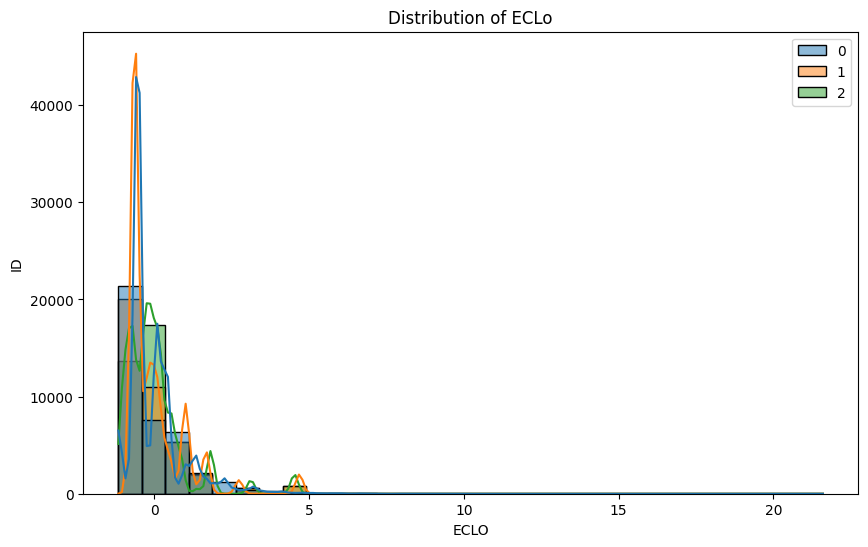

In [ ]:
# histogram 생성
plt.figure(figsize=(10, 6))
sns.histplot(train_std, bins=30, kde=True)
plt.title('Distribution of ECLo')
plt.xlabel('ECLO')
plt.ylabel('ID')
plt.show()

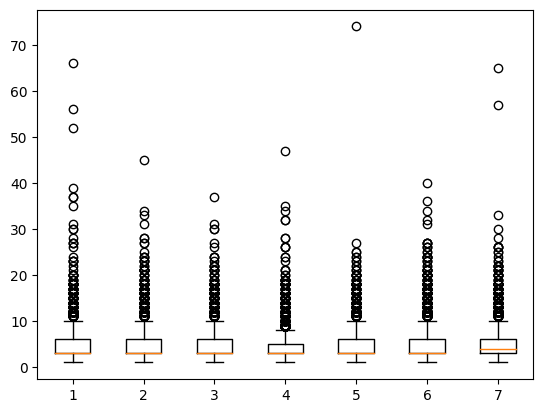

In [ ]:
import matplotlib.pyplot as plt

plt.boxplot([train_df[train_df['요일'] == '월요일'].loc[:,'ECLO',],
             train_df[train_df['요일'] == '화요일'].loc[:,'ECLO',],
             train_df[train_df['요일'] == '수요일'].loc[:,'ECLO'],
             train_df[train_df['요일'] == '목요일'].loc[:,'ECLO',],
             train_df[train_df['요일'] == '금요일'].loc[:,'ECLO',],
             train_df[train_df['요일'] == '토요일'].loc[:,'ECLO',],
             train_df[train_df['요일'] == '일요일'].loc[:,'ECLO',]])
plt.show()

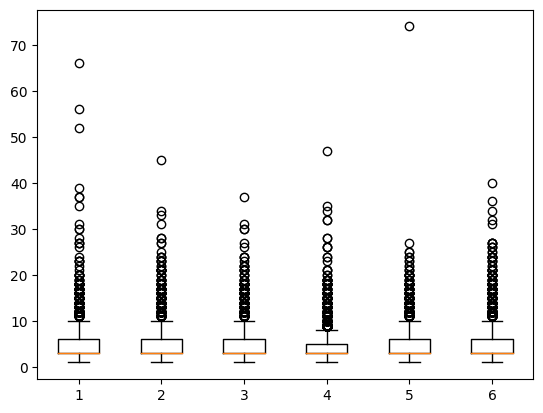

In [ ]:
import matplotlib.pyplot as plt

plt.boxplot([train_df[train_df['요일'] == '월요일'].loc[:,'ECLO',],
             train_df[train_df['요일'] == '화요일'].loc[:,'ECLO',],
             train_df[train_df['요일'] == '수요일'].loc[:,'ECLO'],
             train_df[train_df['요일'] == '목요일'].loc[:,'ECLO',],
             train_df[train_df['요일'] == '금요일'].loc[:,'ECLO',],
             train_df[(train_df['요일'] == '토요일')|(train_df['요일'] == '토요일')].loc[:,'ECLO']])
plt.show()

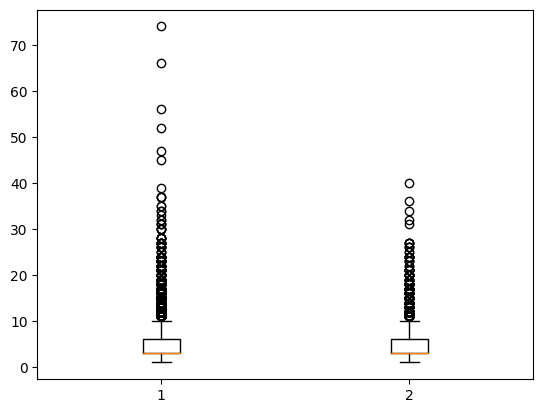

In [ ]:
import matplotlib.pyplot as plt

plt.boxplot([train_df[(train_df['요일'] == '월요일')|
                      (train_df['요일'] == '화요일')|
                      (train_df['요일'] == '수요일')|
                      (train_df['요일'] == '목요일')|
                      (train_df['요일'] == '금요일')].loc[:,'ECLO'],
             train_df[(train_df['요일'] == '토요일')|(train_df['요일'] == '토요일')].loc[:,'ECLO']])
plt.show()

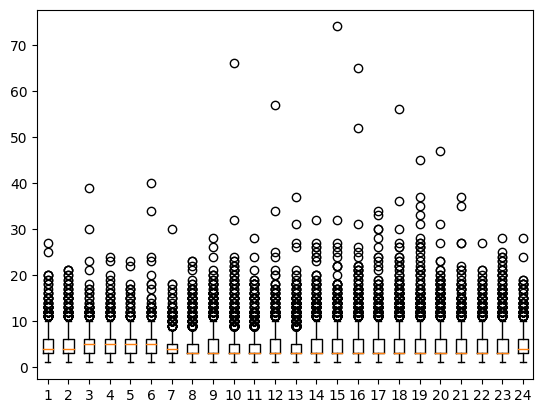

In [ ]:
plt.boxplot([train_df[train_df['시간'] == 0].loc[:,'ECLO',],
              train_df[train_df['시간'] == 1].loc[:,'ECLO',],
              train_df[train_df['시간'] == 2].loc[:,'ECLO'],
              train_df[train_df['시간'] == 3].loc[:,'ECLO',],
              train_df[train_df['시간'] == 4].loc[:,'ECLO',],
              train_df[train_df['시간'] == 5].loc[:,'ECLO',],
              train_df[train_df['시간'] == 6].loc[:,'ECLO',],
             train_df[train_df['시간'] == 7].loc[:,'ECLO',],
             train_df[train_df['시간'] == 8].loc[:,'ECLO',],
             train_df[train_df['시간'] == 9].loc[:,'ECLO',],
             train_df[train_df['시간'] == 10].loc[:,'ECLO',],
             train_df[train_df['시간'] == 11].loc[:,'ECLO',],
             train_df[train_df['시간'] == 12].loc[:,'ECLO',],
             train_df[train_df['시간'] == 13].loc[:,'ECLO',],
             train_df[train_df['시간'] == 14].loc[:,'ECLO',],
             train_df[train_df['시간'] == 15].loc[:,'ECLO',],
             train_df[train_df['시간'] == 16].loc[:,'ECLO',],
             train_df[train_df['시간'] == 17].loc[:,'ECLO',],
             train_df[train_df['시간'] == 18].loc[:,'ECLO',],
             train_df[train_df['시간'] == 19].loc[:,'ECLO',],
             train_df[train_df['시간'] == 20].loc[:,'ECLO',],
             train_df[train_df['시간'] == 21].loc[:,'ECLO',],
             train_df[train_df['시간'] == 22].loc[:,'ECLO',],
             train_df[train_df['시간'] == 23].loc[:,'ECLO',]])
plt.show()

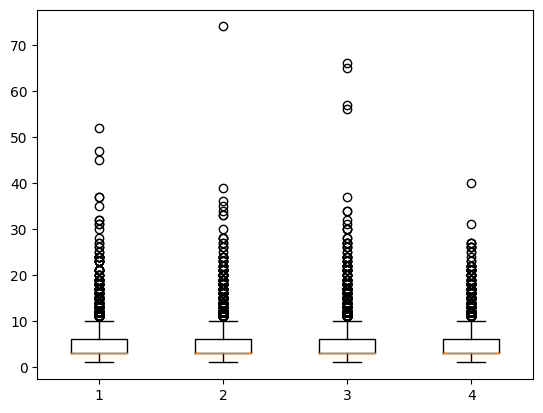

In [ ]:
plt.boxplot([train_df[(train_df['월'] >= 3)&(train_df['월'] <= 5)].loc[:,'ECLO',],
             train_df[(train_df['월'] >= 6)&(train_df['월'] <= 8)].loc[:,'ECLO',],
             train_df[(train_df['월'] >= 9)&(train_df['월'] <= 11)].loc[:,'ECLO'],
             train_df[(train_df['월'] == 12)|(train_df['월'] >= 1)&(train_df['월'] <= 2)].loc[:,'ECLO']])
plt.show()

피처, 타겟 분리 라벨인코딩

In [65]:
#X = train_df.drop(columns=['ECLO','부상자수','경상자수','중상자수','사망자수','피해운전자 상해정도','피해운전자 연령','피해운전자 차종','가해운전자 상해정도',
                           #'가해운전자 연령','가해운전자 성별','가해운전자 차종','법규위반','사고유형 - 세부분류','피해운전자 성별','도시'])
X = train_df.drop(columns=['ID','ECLO'])
y = train_df['ECLO']
test_df = test_df.drop(columns=['ID'])
print(X.shape, y.shape, test_df.shape)

(39609, 17) (39609,) (10963, 17)


In [66]:
from sklearn.preprocessing import LabelEncoder

FEATURE = ['기상상태','노면상태','사고유형','구','동','도로형태1','도로형태2','요일','도시']
for i in FEATURE:
    le = LabelEncoder()
    X[i]= le.fit_transform(X[i])
    test_df[i]= le.transform(test_df[i])

X

,요일,기상상태,노면상태,사고유형,연,월,일,시간,도시,구,동,도로형태1,도로형태2,설치개수,어린이CCTV설치대수,CCTV개수,평균속도
0,6,2,0,0,2019,1,1,0,0,7,40,2,5,391.0,2.0,1.0,38.000000
1,6,5,0,0,2019,1,1,0,0,1,4,2,5,932.0,0.0,4.0,52.500000
2,6,2,0,0,2019,1,1,1,0,6,66,2,5,473.0,5.0,4.0,55.000000
3,6,2,0,1,2019,1,1,2,0,4,79,2,5,534.0,11.0,10.0,37.500000
4,6,2,0,1,2019,1,1,4,0,3,129,2,5,1995.0,0.0,12.0,40.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39604,0,2,0,1,2021,12,31,19,0,6,118,0,3,0.0,1.0,1.0,38.000000
39605,0,2,0,1,2021,12,31,19,0,1,103,2,5,843.0,0.0,18.0,45.000000
39606,0,2,0,1,2021,12,31,21,0,1,144,0,3,164.0,0.0,9.0,41.111111
39607,0,2,0,1,2021,12,31,22,0,1,158,1,5,210.0,0.0,1.0,60.000000


In [79]:
test_df

,요일,기상상태,노면상태,사고유형,연,월,일,시간,도시,구,동,도로형태1,도로형태2,설치개수,어린이CCTV설치대수,CCTV개수,평균속도
0,5,2,0,0,2022,1,1,1,0,6,99,0,3,700.0,5.0,4.0,52.500000
1,5,2,0,0,2022,1,1,1,0,6,168,2,5,0.0,10.0,7.0,47.142857
2,5,2,0,1,2022,1,1,4,0,6,117,0,3,0.0,1.0,1.0,38.000000
3,5,2,0,1,2022,1,1,4,0,6,126,2,5,0.0,7.0,11.0,42.727273
4,5,2,0,1,2022,1,1,6,0,1,4,0,3,932.0,0.0,4.0,52.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10958,5,2,0,1,2022,12,31,18,0,0,38,2,9,5253.0,26.0,27.0,48.636364
10959,5,2,0,1,2022,12,31,18,0,6,123,2,5,0.0,5.0,4.0,52.500000
10960,5,2,0,1,2022,12,31,20,0,6,134,2,5,0.0,0.0,0.0,0.000000
10961,5,2,0,1,2022,12,31,20,0,6,77,0,2,0.0,7.0,7.0,44.285714


모델 훈련 및 예측

In [67]:
#xgboost3.csv
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

def objective(trial):
    # XGBoost의 하이퍼파라미터를 설정합니다.
    param = {
        'objective': 'reg:squaredlogerror',
        'eval_metric': 'rmsle',
        'lambda': trial.suggest_float('lambda', 1e-3, 0.1),
        'alpha': trial.suggest_float('alpha', 1e-3, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1),
        'subsample': trial.suggest_float('subsample', 0.4, 1),
        'learning_rate': trial.suggest_float('learning_rate',0.0001, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 4,8),
        'min_child_weight': trial.suggest_int('min_child_weight', 2, 50),
    }

    # XGBoost 모델을 생성합니다.
    model = xgb.XGBRegressor(**param)

    # 모델을 훈련합니다.
    model.fit(X_train, np.log1p(y_train), eval_set=[(X_val,np.log1p(y_val))],early_stopping_rounds=100)

    # 검증 데이터에 대한 예측을 수행합니다.
    y_pred = model.predict(X_val)

    # RMSE를 계산하여 반환합니다.
    rmsle = np.sqrt(mean_squared_log_error(y_val, np.expm1(y_pred)))
    return rmsle

# Optuna를 사용하여 하이퍼파라미터 튜닝을 수행합니다.
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# 최적의 하이퍼파라미터를 출력합니다.
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

best_params = trial.params
final_model = xgb.XGBRegressor(
    objective='reg:squaredlogerror',
    eval_metric='rmsle',
    verbosity=0,
    n_jobs=-1,
    tree_method='hist',
    **best_params
)

final_model.fit(X, y, verbose=False)
y_pred = final_model.predict(test_df)

[I 2023-11-20 04:57:26,623] A new study created in memory with name: no-name-f2550607-5264-475b-a727-70b23b0c8b47


[0]	validation_0-rmsle:0.56357
[1]	validation_0-rmsle:0.54632
[2]	validation_0-rmsle:0.52950
[3]	validation_0-rmsle:0.51310
[4]	validation_0-rmsle:0.49714
[5]	validation_0-rmsle:0.48167
[6]	validation_0-rmsle:0.46659
[7]	validation_0-rmsle:0.45200
[8]	validation_0-rmsle:0.43784
[9]	validation_0-rmsle:0.42411
[10]	validation_0-rmsle:0.41086
[11]	validation_0-rmsle:0.39807
[12]	validation_0-rmsle:0.38572
[13]	validation_0-rmsle:0.37378
[14]	validation_0-rmsle:0.36230
[15]	validation_0-rmsle:0.35123
[16]	validation_0-rmsle:0.34062
[17]	validation_0-rmsle:0.33043
[18]	validation_0-rmsle:0.32068
[19]	validation_0-rmsle:0.31136
[20]	validation_0-rmsle:0.30247
[21]	validation_0-rmsle:0.29395
[22]	validation_0-rmsle:0.28585
[23]	validation_0-rmsle:0.27812
[24]	validation_0-rmsle:0.27081
[25]	validation_0-rmsle:0.26383
[26]	validation_0-rmsle:0.25726
[27]	validation_0-rmsle:0.25111
[28]	validation_0-rmsle:0.24518
[29]	validation_0-rmsle:0.23968
[30]	validation_0-rmsle:0.23451
[31]	validation_0-

[I 2023-11-20 04:57:35,055] Trial 0 finished with value: 0.44665223091603684 and parameters: {'lambda': 0.03404522634167999, 'alpha': 0.694281303090694, 'colsample_bytree': 0.89684628803892, 'subsample': 0.5823020857393756, 'learning_rate': 0.05241485525953064, 'n_estimators': 715, 'max_depth': 8, 'min_child_weight': 36}. Best is trial 0 with value: 0.44665223091603684.


[0]	validation_0-rmsle:0.55043
[1]	validation_0-rmsle:0.52096
[2]	validation_0-rmsle:0.49281
[3]	validation_0-rmsle:0.46603
[4]	validation_0-rmsle:0.44061
[5]	validation_0-rmsle:0.41655
[6]	validation_0-rmsle:0.39384
[7]	validation_0-rmsle:0.37256
[8]	validation_0-rmsle:0.35261
[9]	validation_0-rmsle:0.33399
[10]	validation_0-rmsle:0.31675
[11]	validation_0-rmsle:0.30081
[12]	validation_0-rmsle:0.28615
[13]	validation_0-rmsle:0.27268
[14]	validation_0-rmsle:0.26048
[15]	validation_0-rmsle:0.24936
[16]	validation_0-rmsle:0.23939
[17]	validation_0-rmsle:0.23042
[18]	validation_0-rmsle:0.22242
[19]	validation_0-rmsle:0.21537
[20]	validation_0-rmsle:0.20919
[21]	validation_0-rmsle:0.20374
[22]	validation_0-rmsle:0.19900
[23]	validation_0-rmsle:0.19484
[24]	validation_0-rmsle:0.19128
[25]	validation_0-rmsle:0.18817
[26]	validation_0-rmsle:0.18553
[27]	validation_0-rmsle:0.18330
[28]	validation_0-rmsle:0.18135
[29]	validation_0-rmsle:0.17972
[30]	validation_0-rmsle:0.17837
[31]	validation_0-

[I 2023-11-20 04:57:37,968] Trial 1 finished with value: 0.44674357423140626 and parameters: {'lambda': 0.0015635496867203787, 'alpha': 0.4418415911068181, 'colsample_bytree': 0.9125050118950273, 'subsample': 0.7104883563019946, 'learning_rate': 0.0920669655463927, 'n_estimators': 717, 'max_depth': 5, 'min_child_weight': 16}. Best is trial 0 with value: 0.44665223091603684.


[0]	validation_0-rmsle:0.57275
[1]	validation_0-rmsle:0.56432
[2]	validation_0-rmsle:0.55600
[3]	validation_0-rmsle:0.54778
[4]	validation_0-rmsle:0.53967
[5]	validation_0-rmsle:0.53165
[6]	validation_0-rmsle:0.52373
[7]	validation_0-rmsle:0.51591
[8]	validation_0-rmsle:0.50820
[9]	validation_0-rmsle:0.50058
[10]	validation_0-rmsle:0.49309
[11]	validation_0-rmsle:0.48569
[12]	validation_0-rmsle:0.47838
[13]	validation_0-rmsle:0.47119
[14]	validation_0-rmsle:0.46409
[15]	validation_0-rmsle:0.45710
[16]	validation_0-rmsle:0.45020
[17]	validation_0-rmsle:0.44341
[18]	validation_0-rmsle:0.43673
[19]	validation_0-rmsle:0.43016
[20]	validation_0-rmsle:0.42368
[21]	validation_0-rmsle:0.41732
[22]	validation_0-rmsle:0.41104
[23]	validation_0-rmsle:0.40487
[24]	validation_0-rmsle:0.39880
[25]	validation_0-rmsle:0.39281
[26]	validation_0-rmsle:0.38693
[27]	validation_0-rmsle:0.38116
[28]	validation_0-rmsle:0.37549
[29]	validation_0-rmsle:0.36992
[30]	validation_0-rmsle:0.36445
[31]	validation_0-

[I 2023-11-20 04:57:51,464] Trial 2 finished with value: 0.44643994561328865 and parameters: {'lambda': 0.02875246249247136, 'alpha': 0.6191975842199289, 'colsample_bytree': 0.6871193674796909, 'subsample': 0.8233177869070223, 'learning_rate': 0.025099768723586248, 'n_estimators': 725, 'max_depth': 4, 'min_child_weight': 45}. Best is trial 2 with value: 0.44643994561328865.


[0]	validation_0-rmsle:0.56387
[1]	validation_0-rmsle:0.54690
[2]	validation_0-rmsle:0.53036
[3]	validation_0-rmsle:0.51423
[4]	validation_0-rmsle:0.49854
[5]	validation_0-rmsle:0.48326
[6]	validation_0-rmsle:0.46843
[7]	validation_0-rmsle:0.45403
[8]	validation_0-rmsle:0.44004
[9]	validation_0-rmsle:0.42648
[10]	validation_0-rmsle:0.41338
[11]	validation_0-rmsle:0.40072
[12]	validation_0-rmsle:0.38847
[13]	validation_0-rmsle:0.37666
[14]	validation_0-rmsle:0.36530
[15]	validation_0-rmsle:0.35430
[16]	validation_0-rmsle:0.34374
[17]	validation_0-rmsle:0.33359
[18]	validation_0-rmsle:0.32389
[19]	validation_0-rmsle:0.31461
[20]	validation_0-rmsle:0.30571
[21]	validation_0-rmsle:0.29722
[22]	validation_0-rmsle:0.28914
[23]	validation_0-rmsle:0.28142
[24]	validation_0-rmsle:0.27406
[25]	validation_0-rmsle:0.26704
[26]	validation_0-rmsle:0.26040
[27]	validation_0-rmsle:0.25416
[28]	validation_0-rmsle:0.24818
[29]	validation_0-rmsle:0.24259
[30]	validation_0-rmsle:0.23734
[31]	validation_0-

[I 2023-11-20 04:57:56,394] Trial 3 finished with value: 0.44655602848304576 and parameters: {'lambda': 0.012931241778039879, 'alpha': 0.7736910225404998, 'colsample_bytree': 0.5304602828816283, 'subsample': 0.7015161065081641, 'learning_rate': 0.05152694369237866, 'n_estimators': 533, 'max_depth': 8, 'min_child_weight': 39}. Best is trial 2 with value: 0.44643994561328865.


[0]	validation_0-rmsle:0.56962
[1]	validation_0-rmsle:0.55816
[2]	validation_0-rmsle:0.54689
[3]	validation_0-rmsle:0.53580
[4]	validation_0-rmsle:0.52491
[5]	validation_0-rmsle:0.51420
[6]	validation_0-rmsle:0.50368
[7]	validation_0-rmsle:0.49337
[8]	validation_0-rmsle:0.48323
[9]	validation_0-rmsle:0.47328
[10]	validation_0-rmsle:0.46354
[11]	validation_0-rmsle:0.45400
[12]	validation_0-rmsle:0.44464
[13]	validation_0-rmsle:0.43548
[14]	validation_0-rmsle:0.42652
[15]	validation_0-rmsle:0.41772
[16]	validation_0-rmsle:0.40912
[17]	validation_0-rmsle:0.40071
[18]	validation_0-rmsle:0.39252
[19]	validation_0-rmsle:0.38451
[20]	validation_0-rmsle:0.37669
[21]	validation_0-rmsle:0.36906
[22]	validation_0-rmsle:0.36163
[23]	validation_0-rmsle:0.35437
[24]	validation_0-rmsle:0.34729
[25]	validation_0-rmsle:0.34037
[26]	validation_0-rmsle:0.33365
[27]	validation_0-rmsle:0.32714
[28]	validation_0-rmsle:0.32076
[29]	validation_0-rmsle:0.31459
[30]	validation_0-rmsle:0.30861
[31]	validation_0-

[I 2023-11-20 04:58:04,624] Trial 4 finished with value: 0.4465681073434322 and parameters: {'lambda': 0.006541633304574125, 'alpha': 0.3683680464066392, 'colsample_bytree': 0.529435719771007, 'subsample': 0.6704227996514305, 'learning_rate': 0.03439701897211923, 'n_estimators': 657, 'max_depth': 5, 'min_child_weight': 41}. Best is trial 2 with value: 0.44643994561328865.


[0]	validation_0-rmsle:0.55873
[1]	validation_0-rmsle:0.53689
[2]	validation_0-rmsle:0.51576
[3]	validation_0-rmsle:0.49534
[4]	validation_0-rmsle:0.47567
[5]	validation_0-rmsle:0.45672
[6]	validation_0-rmsle:0.43850
[7]	validation_0-rmsle:0.42099
[8]	validation_0-rmsle:0.40421
[9]	validation_0-rmsle:0.38815
[10]	validation_0-rmsle:0.37285
[11]	validation_0-rmsle:0.35826
[12]	validation_0-rmsle:0.34437
[13]	validation_0-rmsle:0.33121
[14]	validation_0-rmsle:0.31876
[15]	validation_0-rmsle:0.30696
[16]	validation_0-rmsle:0.29584
[17]	validation_0-rmsle:0.28540
[18]	validation_0-rmsle:0.27564
[19]	validation_0-rmsle:0.26651
[20]	validation_0-rmsle:0.25796
[21]	validation_0-rmsle:0.25004
[22]	validation_0-rmsle:0.24269
[23]	validation_0-rmsle:0.23588
[24]	validation_0-rmsle:0.22958
[25]	validation_0-rmsle:0.22377
[26]	validation_0-rmsle:0.21844
[27]	validation_0-rmsle:0.21357
[28]	validation_0-rmsle:0.20914
[29]	validation_0-rmsle:0.20510
[30]	validation_0-rmsle:0.20147
[31]	validation_0-

[I 2023-11-20 04:58:10,854] Trial 5 finished with value: 0.44633189793503986 and parameters: {'lambda': 0.07692049772797839, 'alpha': 0.20301284925398952, 'colsample_bytree': 0.5391691307393746, 'subsample': 0.8916119484018628, 'learning_rate': 0.06697130512296462, 'n_estimators': 859, 'max_depth': 4, 'min_child_weight': 37}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.55674
[1]	validation_0-rmsle:0.53307
[2]	validation_0-rmsle:0.51023
[3]	validation_0-rmsle:0.48822
[4]	validation_0-rmsle:0.46707
[5]	validation_0-rmsle:0.44683
[6]	validation_0-rmsle:0.42739
[7]	validation_0-rmsle:0.40888
[8]	validation_0-rmsle:0.39119
[9]	validation_0-rmsle:0.37435
[10]	validation_0-rmsle:0.35839
[11]	validation_0-rmsle:0.34330
[12]	validation_0-rmsle:0.32907
[13]	validation_0-rmsle:0.31561
[14]	validation_0-rmsle:0.30299
[15]	validation_0-rmsle:0.29113
[16]	validation_0-rmsle:0.28010
[17]	validation_0-rmsle:0.26980
[18]	validation_0-rmsle:0.26026
[19]	validation_0-rmsle:0.25145
[20]	validation_0-rmsle:0.24334
[21]	validation_0-rmsle:0.23585
[22]	validation_0-rmsle:0.22900
[23]	validation_0-rmsle:0.22273
[24]	validation_0-rmsle:0.21705
[25]	validation_0-rmsle:0.21186
[26]	validation_0-rmsle:0.20721
[27]	validation_0-rmsle:0.20306
[28]	validation_0-rmsle:0.19922
[29]	validation_0-rmsle:0.19586
[30]	validation_0-rmsle:0.19285
[31]	validation_0-

[I 2023-11-20 04:58:14,018] Trial 6 finished with value: 0.4469561137459789 and parameters: {'lambda': 0.029005969854880624, 'alpha': 0.11942371430525091, 'colsample_bytree': 0.998480906824492, 'subsample': 0.5998954112403385, 'learning_rate': 0.07292616165029704, 'n_estimators': 893, 'max_depth': 8, 'min_child_weight': 36}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.56258
[1]	validation_0-rmsle:0.54439
[2]	validation_0-rmsle:0.52667
[3]	validation_0-rmsle:0.50944
[4]	validation_0-rmsle:0.49271
[5]	validation_0-rmsle:0.47651
[6]	validation_0-rmsle:0.46077
[7]	validation_0-rmsle:0.44555
[8]	validation_0-rmsle:0.43080
[9]	validation_0-rmsle:0.41653
[10]	validation_0-rmsle:0.40285
[11]	validation_0-rmsle:0.38964
[12]	validation_0-rmsle:0.37692
[13]	validation_0-rmsle:0.36467
[14]	validation_0-rmsle:0.35295
[15]	validation_0-rmsle:0.34165
[16]	validation_0-rmsle:0.33086
[17]	validation_0-rmsle:0.32053
[18]	validation_0-rmsle:0.31074
[19]	validation_0-rmsle:0.30139
[20]	validation_0-rmsle:0.29249
[21]	validation_0-rmsle:0.28404
[22]	validation_0-rmsle:0.27603
[23]	validation_0-rmsle:0.26841
[24]	validation_0-rmsle:0.26125
[25]	validation_0-rmsle:0.25444
[26]	validation_0-rmsle:0.24804
[27]	validation_0-rmsle:0.24211
[28]	validation_0-rmsle:0.23645
[29]	validation_0-rmsle:0.23122
[30]	validation_0-rmsle:0.22636
[31]	validation_0-

[I 2023-11-20 04:58:16,820] Trial 7 finished with value: 0.4465780832741597 and parameters: {'lambda': 0.006707057542977855, 'alpha': 0.9155871552725499, 'colsample_bytree': 0.5040567670066546, 'subsample': 0.5388331030071334, 'learning_rate': 0.055390486355090925, 'n_estimators': 170, 'max_depth': 7, 'min_child_weight': 41}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.57631
[1]	validation_0-rmsle:0.57138
[2]	validation_0-rmsle:0.56649
[3]	validation_0-rmsle:0.56163
[4]	validation_0-rmsle:0.55681
[5]	validation_0-rmsle:0.55202
[6]	validation_0-rmsle:0.54725
[7]	validation_0-rmsle:0.54253
[8]	validation_0-rmsle:0.53784
[9]	validation_0-rmsle:0.53319
[10]	validation_0-rmsle:0.52857
[11]	validation_0-rmsle:0.52398
[12]	validation_0-rmsle:0.51943
[13]	validation_0-rmsle:0.51491
[14]	validation_0-rmsle:0.51043
[15]	validation_0-rmsle:0.50598
[16]	validation_0-rmsle:0.50157
[17]	validation_0-rmsle:0.49718
[18]	validation_0-rmsle:0.49284
[19]	validation_0-rmsle:0.48853
[20]	validation_0-rmsle:0.48425
[21]	validation_0-rmsle:0.48001
[22]	validation_0-rmsle:0.47581
[23]	validation_0-rmsle:0.47163
[24]	validation_0-rmsle:0.46750
[25]	validation_0-rmsle:0.46338
[26]	validation_0-rmsle:0.45931
[27]	validation_0-rmsle:0.45528
[28]	validation_0-rmsle:0.45128
[29]	validation_0-rmsle:0.44731
[30]	validation_0-rmsle:0.44338
[31]	validation_0-

[I 2023-11-20 04:58:31,819] Trial 8 finished with value: 0.44660788399442547 and parameters: {'lambda': 0.013285057861698736, 'alpha': 0.26738790969017845, 'colsample_bytree': 0.9254610178920611, 'subsample': 0.77497580349783, 'learning_rate': 0.014580850598803301, 'n_estimators': 699, 'max_depth': 5, 'min_child_weight': 18}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.57895
[1]	validation_0-rmsle:0.57663
[2]	validation_0-rmsle:0.57432
[3]	validation_0-rmsle:0.57202
[4]	validation_0-rmsle:0.56973
[5]	validation_0-rmsle:0.56744
[6]	validation_0-rmsle:0.56516
[7]	validation_0-rmsle:0.56289
[8]	validation_0-rmsle:0.56063
[9]	validation_0-rmsle:0.55837
[10]	validation_0-rmsle:0.55612
[11]	validation_0-rmsle:0.55388
[12]	validation_0-rmsle:0.55165
[13]	validation_0-rmsle:0.54942
[14]	validation_0-rmsle:0.54720
[15]	validation_0-rmsle:0.54499
[16]	validation_0-rmsle:0.54279
[17]	validation_0-rmsle:0.54059
[18]	validation_0-rmsle:0.53840
[19]	validation_0-rmsle:0.53622
[20]	validation_0-rmsle:0.53405
[21]	validation_0-rmsle:0.53188
[22]	validation_0-rmsle:0.52973
[23]	validation_0-rmsle:0.52758
[24]	validation_0-rmsle:0.52543
[25]	validation_0-rmsle:0.52329
[26]	validation_0-rmsle:0.52116
[27]	validation_0-rmsle:0.51904
[28]	validation_0-rmsle:0.51693
[29]	validation_0-rmsle:0.51482
[30]	validation_0-rmsle:0.51272
[31]	validation_0-

[I 2023-11-20 04:58:48,820] Trial 9 finished with value: 0.4482179955145178 and parameters: {'lambda': 0.004555631509547489, 'alpha': 0.8857915978075058, 'colsample_bytree': 0.8316065014200265, 'subsample': 0.9072427119939951, 'learning_rate': 0.006816280687178121, 'n_estimators': 807, 'max_depth': 4, 'min_child_weight': 19}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.54790
[1]	validation_0-rmsle:0.51607
[2]	validation_0-rmsle:0.48583
[3]	validation_0-rmsle:0.45718
[4]	validation_0-rmsle:0.43018
[5]	validation_0-rmsle:0.40476
[6]	validation_0-rmsle:0.38100
[7]	validation_0-rmsle:0.35882
[8]	validation_0-rmsle:0.33820
[9]	validation_0-rmsle:0.31916
[10]	validation_0-rmsle:0.30172
[11]	validation_0-rmsle:0.28575
[12]	validation_0-rmsle:0.27121
[13]	validation_0-rmsle:0.25814
[14]	validation_0-rmsle:0.24640
[15]	validation_0-rmsle:0.23587
[16]	validation_0-rmsle:0.22657
[17]	validation_0-rmsle:0.21839
[18]	validation_0-rmsle:0.21132
[19]	validation_0-rmsle:0.20514
[20]	validation_0-rmsle:0.19978
[21]	validation_0-rmsle:0.19521
[22]	validation_0-rmsle:0.19133
[23]	validation_0-rmsle:0.18800
[24]	validation_0-rmsle:0.18517
[25]	validation_0-rmsle:0.18279
[26]	validation_0-rmsle:0.18081
[27]	validation_0-rmsle:0.17914
[28]	validation_0-rmsle:0.17772
[29]	validation_0-rmsle:0.17657
[30]	validation_0-rmsle:0.17563
[31]	validation_0-

[I 2023-11-20 04:58:51,969] Trial 10 finished with value: 0.447111568164235 and parameters: {'lambda': 0.07977465375718856, 'alpha': 0.00980303804899213, 'colsample_bytree': 0.427143808931682, 'subsample': 0.9978793274927924, 'learning_rate': 0.09982092295690115, 'n_estimators': 970, 'max_depth': 6, 'min_child_weight': 6}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.57154
[1]	validation_0-rmsle:0.56194
[2]	validation_0-rmsle:0.55248
[3]	validation_0-rmsle:0.54314
[4]	validation_0-rmsle:0.53395
[5]	validation_0-rmsle:0.52488
[6]	validation_0-rmsle:0.51593
[7]	validation_0-rmsle:0.50713
[8]	validation_0-rmsle:0.49846
[9]	validation_0-rmsle:0.48992
[10]	validation_0-rmsle:0.48152
[11]	validation_0-rmsle:0.47327
[12]	validation_0-rmsle:0.46513
[13]	validation_0-rmsle:0.45713
[14]	validation_0-rmsle:0.44927
[15]	validation_0-rmsle:0.44153
[16]	validation_0-rmsle:0.43393
[17]	validation_0-rmsle:0.42646
[18]	validation_0-rmsle:0.41914
[19]	validation_0-rmsle:0.41195
[20]	validation_0-rmsle:0.40490
[21]	validation_0-rmsle:0.39798
[22]	validation_0-rmsle:0.39118
[23]	validation_0-rmsle:0.38452
[24]	validation_0-rmsle:0.37798
[25]	validation_0-rmsle:0.37156
[26]	validation_0-rmsle:0.36528
[27]	validation_0-rmsle:0.35914
[28]	validation_0-rmsle:0.35312
[29]	validation_0-rmsle:0.34724
[30]	validation_0-rmsle:0.34149
[31]	validation_0-

[I 2023-11-20 04:59:03,724] Trial 11 finished with value: 0.4464001569947454 and parameters: {'lambda': 0.06687308979738808, 'alpha': 0.5918841137404339, 'colsample_bytree': 0.6788194650799892, 'subsample': 0.8388648986035588, 'learning_rate': 0.028670657441077173, 'n_estimators': 496, 'max_depth': 4, 'min_child_weight': 50}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.56940
[1]	validation_0-rmsle:0.55773
[2]	validation_0-rmsle:0.54625
[3]	validation_0-rmsle:0.53496
[4]	validation_0-rmsle:0.52389
[5]	validation_0-rmsle:0.51300
[6]	validation_0-rmsle:0.50230
[7]	validation_0-rmsle:0.49181
[8]	validation_0-rmsle:0.48152
[9]	validation_0-rmsle:0.47142
[10]	validation_0-rmsle:0.46154
[11]	validation_0-rmsle:0.45186
[12]	validation_0-rmsle:0.44237
[13]	validation_0-rmsle:0.43308
[14]	validation_0-rmsle:0.42399
[15]	validation_0-rmsle:0.41510
[16]	validation_0-rmsle:0.40641
[17]	validation_0-rmsle:0.39792
[18]	validation_0-rmsle:0.38964
[19]	validation_0-rmsle:0.38156
[20]	validation_0-rmsle:0.37366
[21]	validation_0-rmsle:0.36598
[22]	validation_0-rmsle:0.35847
[23]	validation_0-rmsle:0.35117
[24]	validation_0-rmsle:0.34405
[25]	validation_0-rmsle:0.33710
[26]	validation_0-rmsle:0.33036
[27]	validation_0-rmsle:0.32382
[28]	validation_0-rmsle:0.31745
[29]	validation_0-rmsle:0.31128
[30]	validation_0-rmsle:0.30530
[31]	validation_0-

[I 2023-11-20 04:59:12,259] Trial 12 finished with value: 0.4464477548863766 and parameters: {'lambda': 0.07444548461929613, 'alpha': 0.5531207258084189, 'colsample_bytree': 0.6652157882314619, 'subsample': 0.8691114366168177, 'learning_rate': 0.03502474176327107, 'n_estimators': 445, 'max_depth': 4, 'min_child_weight': 50}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.55561
[1]	validation_0-rmsle:0.53086
[2]	validation_0-rmsle:0.50705
[3]	validation_0-rmsle:0.48416
[4]	validation_0-rmsle:0.46224
[5]	validation_0-rmsle:0.44125
[6]	validation_0-rmsle:0.42118
[7]	validation_0-rmsle:0.40208
[8]	validation_0-rmsle:0.38392
[9]	validation_0-rmsle:0.36669
[10]	validation_0-rmsle:0.35041
[11]	validation_0-rmsle:0.33508
[12]	validation_0-rmsle:0.32063
[13]	validation_0-rmsle:0.30711
[14]	validation_0-rmsle:0.29447
[15]	validation_0-rmsle:0.28267
[16]	validation_0-rmsle:0.27173
[17]	validation_0-rmsle:0.26160
[18]	validation_0-rmsle:0.25231
[19]	validation_0-rmsle:0.24375
[20]	validation_0-rmsle:0.23589
[21]	validation_0-rmsle:0.22876
[22]	validation_0-rmsle:0.22225
[23]	validation_0-rmsle:0.21639
[24]	validation_0-rmsle:0.21107
[25]	validation_0-rmsle:0.20628
[26]	validation_0-rmsle:0.20200
[27]	validation_0-rmsle:0.19817
[28]	validation_0-rmsle:0.19479
[29]	validation_0-rmsle:0.19180
[30]	validation_0-rmsle:0.18917
[31]	validation_0-

[I 2023-11-20 04:59:15,694] Trial 13 finished with value: 0.4468522200473712 and parameters: {'lambda': 0.09842904640201149, 'alpha': 0.3310948465767846, 'colsample_bytree': 0.6542068991698381, 'subsample': 0.9383190807932162, 'learning_rate': 0.07638536308235382, 'n_estimators': 358, 'max_depth': 6, 'min_child_weight': 29}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.58040
[1]	validation_0-rmsle:0.57953
[2]	validation_0-rmsle:0.57867
[3]	validation_0-rmsle:0.57780
[4]	validation_0-rmsle:0.57693
[5]	validation_0-rmsle:0.57607
[6]	validation_0-rmsle:0.57520
[7]	validation_0-rmsle:0.57434
[8]	validation_0-rmsle:0.57348
[9]	validation_0-rmsle:0.57262
[10]	validation_0-rmsle:0.57176
[11]	validation_0-rmsle:0.57090
[12]	validation_0-rmsle:0.57004
[13]	validation_0-rmsle:0.56919
[14]	validation_0-rmsle:0.56833
[15]	validation_0-rmsle:0.56748
[16]	validation_0-rmsle:0.56662
[17]	validation_0-rmsle:0.56577
[18]	validation_0-rmsle:0.56492
[19]	validation_0-rmsle:0.56407
[20]	validation_0-rmsle:0.56322
[21]	validation_0-rmsle:0.56237
[22]	validation_0-rmsle:0.56153
[23]	validation_0-rmsle:0.56068
[24]	validation_0-rmsle:0.55984
[25]	validation_0-rmsle:0.55899
[26]	validation_0-rmsle:0.55815
[27]	validation_0-rmsle:0.55730
[28]	validation_0-rmsle:0.55646
[29]	validation_0-rmsle:0.55562
[30]	validation_0-rmsle:0.55478
[31]	validation_0-

[I 2023-11-20 04:59:25,001] Trial 14 finished with value: 0.8580381343860943 and parameters: {'lambda': 0.060802079996209804, 'alpha': 0.5011451492945915, 'colsample_bytree': 0.60697228453011, 'subsample': 0.40178455091743354, 'learning_rate': 0.002552202524054664, 'n_estimators': 323, 'max_depth': 4, 'min_child_weight': 50}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.56780
[1]	validation_0-rmsle:0.55459
[2]	validation_0-rmsle:0.54163
[3]	validation_0-rmsle:0.52891
[4]	validation_0-rmsle:0.51647
[5]	validation_0-rmsle:0.50428
[6]	validation_0-rmsle:0.49232
[7]	validation_0-rmsle:0.48064
[8]	validation_0-rmsle:0.46921
[9]	validation_0-rmsle:0.45803
[10]	validation_0-rmsle:0.44713
[11]	validation_0-rmsle:0.43648
[12]	validation_0-rmsle:0.42608
[13]	validation_0-rmsle:0.41592
[14]	validation_0-rmsle:0.40605
[15]	validation_0-rmsle:0.39642
[16]	validation_0-rmsle:0.38704
[17]	validation_0-rmsle:0.37792
[18]	validation_0-rmsle:0.36905
[19]	validation_0-rmsle:0.36045
[20]	validation_0-rmsle:0.35210
[21]	validation_0-rmsle:0.34401
[22]	validation_0-rmsle:0.33614
[23]	validation_0-rmsle:0.32854
[24]	validation_0-rmsle:0.32116
[25]	validation_0-rmsle:0.31400
[26]	validation_0-rmsle:0.30710
[27]	validation_0-rmsle:0.30044
[28]	validation_0-rmsle:0.29400
[29]	validation_0-rmsle:0.28781
[30]	validation_0-rmsle:0.28185
[31]	validation_0-

[I 2023-11-20 04:59:30,891] Trial 15 finished with value: 0.446552447829732 and parameters: {'lambda': 0.056268258076068195, 'alpha': 0.23147590439910287, 'colsample_bytree': 0.7428166287641428, 'subsample': 0.8221111818216382, 'learning_rate': 0.03977448755807423, 'n_estimators': 563, 'max_depth': 5, 'min_child_weight': 29}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.57382
[1]	validation_0-rmsle:0.56645
[2]	validation_0-rmsle:0.55916
[3]	validation_0-rmsle:0.55193
[4]	validation_0-rmsle:0.54480
[5]	validation_0-rmsle:0.53773
[6]	validation_0-rmsle:0.53074
[7]	validation_0-rmsle:0.52383
[8]	validation_0-rmsle:0.51700
[9]	validation_0-rmsle:0.51024
[10]	validation_0-rmsle:0.50357
[11]	validation_0-rmsle:0.49697
[12]	validation_0-rmsle:0.49045
[13]	validation_0-rmsle:0.48401
[14]	validation_0-rmsle:0.47765
[15]	validation_0-rmsle:0.47136
[16]	validation_0-rmsle:0.46516
[17]	validation_0-rmsle:0.45902
[18]	validation_0-rmsle:0.45298
[19]	validation_0-rmsle:0.44701
[20]	validation_0-rmsle:0.44112
[21]	validation_0-rmsle:0.43531
[22]	validation_0-rmsle:0.42957
[23]	validation_0-rmsle:0.42392
[24]	validation_0-rmsle:0.41833
[25]	validation_0-rmsle:0.41283
[26]	validation_0-rmsle:0.40740
[27]	validation_0-rmsle:0.40205
[28]	validation_0-rmsle:0.39678
[29]	validation_0-rmsle:0.39159
[30]	validation_0-rmsle:0.38648
[31]	validation_0-

[I 2023-11-20 04:59:43,156] Trial 16 finished with value: 0.4465107520477232 and parameters: {'lambda': 0.06963823728194014, 'alpha': 0.4496539187350216, 'colsample_bytree': 0.7433992712211563, 'subsample': 0.9753437244863397, 'learning_rate': 0.02192434841505246, 'n_estimators': 574, 'max_depth': 4, 'min_child_weight': 31}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.55898
[1]	validation_0-rmsle:0.53739
[2]	validation_0-rmsle:0.51648
[3]	validation_0-rmsle:0.49627
[4]	validation_0-rmsle:0.47679
[5]	validation_0-rmsle:0.45801
[6]	validation_0-rmsle:0.43993
[7]	validation_0-rmsle:0.42257
[8]	validation_0-rmsle:0.40592
[9]	validation_0-rmsle:0.38997
[10]	validation_0-rmsle:0.37476
[11]	validation_0-rmsle:0.36027
[12]	validation_0-rmsle:0.34644
[13]	validation_0-rmsle:0.33333
[14]	validation_0-rmsle:0.32093
[15]	validation_0-rmsle:0.30916
[16]	validation_0-rmsle:0.29805
[17]	validation_0-rmsle:0.28761
[18]	validation_0-rmsle:0.27784
[19]	validation_0-rmsle:0.26868
[20]	validation_0-rmsle:0.26010
[21]	validation_0-rmsle:0.25214
[22]	validation_0-rmsle:0.24474
[23]	validation_0-rmsle:0.23788
[24]	validation_0-rmsle:0.23151
[25]	validation_0-rmsle:0.22562
[26]	validation_0-rmsle:0.22022
[27]	validation_0-rmsle:0.21527
[28]	validation_0-rmsle:0.21076
[29]	validation_0-rmsle:0.20665
[30]	validation_0-rmsle:0.20293
[31]	validation_0-

[I 2023-11-20 04:59:48,990] Trial 17 finished with value: 0.4471142240941276 and parameters: {'lambda': 0.08755089376814212, 'alpha': 0.5914467606141921, 'colsample_bytree': 0.6036075206456301, 'subsample': 0.8937267085258123, 'learning_rate': 0.06620800303189613, 'n_estimators': 218, 'max_depth': 7, 'min_child_weight': 45}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.56688
[1]	validation_0-rmsle:0.55279
[2]	validation_0-rmsle:0.53899
[3]	validation_0-rmsle:0.52547
[4]	validation_0-rmsle:0.51226
[5]	validation_0-rmsle:0.49932
[6]	validation_0-rmsle:0.48669
[7]	validation_0-rmsle:0.47434
[8]	validation_0-rmsle:0.46229
[9]	validation_0-rmsle:0.45051
[10]	validation_0-rmsle:0.43906
[11]	validation_0-rmsle:0.42790
[12]	validation_0-rmsle:0.41702
[13]	validation_0-rmsle:0.40644
[14]	validation_0-rmsle:0.39617
[15]	validation_0-rmsle:0.38617
[16]	validation_0-rmsle:0.37645
[17]	validation_0-rmsle:0.36703
[18]	validation_0-rmsle:0.35791
[19]	validation_0-rmsle:0.34909
[20]	validation_0-rmsle:0.34054
[21]	validation_0-rmsle:0.33228
[22]	validation_0-rmsle:0.32430
[23]	validation_0-rmsle:0.31659
[24]	validation_0-rmsle:0.30913
[25]	validation_0-rmsle:0.30193
[26]	validation_0-rmsle:0.29502
[27]	validation_0-rmsle:0.28840
[28]	validation_0-rmsle:0.28200
[29]	validation_0-rmsle:0.27588
[30]	validation_0-rmsle:0.27002
[31]	validation_0-

[I 2023-11-20 04:59:54,868] Trial 18 finished with value: 0.4465155305176191 and parameters: {'lambda': 0.06609008588727636, 'alpha': 0.19882915267838483, 'colsample_bytree': 0.41466358860562336, 'subsample': 0.8367646910303439, 'learning_rate': 0.04250054504448826, 'n_estimators': 444, 'max_depth': 6, 'min_child_weight': 25}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.56054
[1]	validation_0-rmsle:0.54040
[2]	validation_0-rmsle:0.52087
[3]	validation_0-rmsle:0.50194
[4]	validation_0-rmsle:0.48361
[5]	validation_0-rmsle:0.46591
[6]	validation_0-rmsle:0.44880
[7]	validation_0-rmsle:0.43232
[8]	validation_0-rmsle:0.41646
[9]	validation_0-rmsle:0.40120
[10]	validation_0-rmsle:0.38658
[11]	validation_0-rmsle:0.37256
[12]	validation_0-rmsle:0.35914
[13]	validation_0-rmsle:0.34632
[14]	validation_0-rmsle:0.33412
[15]	validation_0-rmsle:0.32250
[16]	validation_0-rmsle:0.31146
[17]	validation_0-rmsle:0.30099
[18]	validation_0-rmsle:0.29111
[19]	validation_0-rmsle:0.28176
[20]	validation_0-rmsle:0.27296
[21]	validation_0-rmsle:0.26471
[22]	validation_0-rmsle:0.25696
[23]	validation_0-rmsle:0.24972
[24]	validation_0-rmsle:0.24294
[25]	validation_0-rmsle:0.23662
[26]	validation_0-rmsle:0.23076
[27]	validation_0-rmsle:0.22533
[28]	validation_0-rmsle:0.22031
[29]	validation_0-rmsle:0.21569
[30]	validation_0-rmsle:0.21144
[31]	validation_0-

[I 2023-11-20 04:59:59,122] Trial 19 finished with value: 0.44663453996811536 and parameters: {'lambda': 0.047987574874909, 'alpha': 0.35809462286862587, 'colsample_bytree': 0.769333257169648, 'subsample': 0.9328170374927749, 'learning_rate': 0.06152088957182682, 'n_estimators': 837, 'max_depth': 5, 'min_child_weight': 2}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.56601
[1]	validation_0-rmsle:0.55108
[2]	validation_0-rmsle:0.53648
[3]	validation_0-rmsle:0.52219
[4]	validation_0-rmsle:0.50826
[5]	validation_0-rmsle:0.49464
[6]	validation_0-rmsle:0.48133
[7]	validation_0-rmsle:0.46837
[8]	validation_0-rmsle:0.45574
[9]	validation_0-rmsle:0.44342
[10]	validation_0-rmsle:0.43147
[11]	validation_0-rmsle:0.41984
[12]	validation_0-rmsle:0.40854
[13]	validation_0-rmsle:0.39756
[14]	validation_0-rmsle:0.38694
[15]	validation_0-rmsle:0.37660
[16]	validation_0-rmsle:0.36660
[17]	validation_0-rmsle:0.35692
[18]	validation_0-rmsle:0.34760
[19]	validation_0-rmsle:0.33859
[20]	validation_0-rmsle:0.32989
[21]	validation_0-rmsle:0.32153
[22]	validation_0-rmsle:0.31347
[23]	validation_0-rmsle:0.30571
[24]	validation_0-rmsle:0.29824
[25]	validation_0-rmsle:0.29105
[26]	validation_0-rmsle:0.28417
[27]	validation_0-rmsle:0.27760
[28]	validation_0-rmsle:0.27129
[29]	validation_0-rmsle:0.26528
[30]	validation_0-rmsle:0.25956
[31]	validation_0-

[I 2023-11-20 05:00:09,010] Trial 20 finished with value: 0.4464991737622923 and parameters: {'lambda': 0.08408273797504962, 'alpha': 0.7012917268136002, 'colsample_bytree': 0.6030085116587526, 'subsample': 0.7803028536387423, 'learning_rate': 0.04511392290345538, 'n_estimators': 960, 'max_depth': 4, 'min_child_weight': 46}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.57259
[1]	validation_0-rmsle:0.56402
[2]	validation_0-rmsle:0.55555
[3]	validation_0-rmsle:0.54718
[4]	validation_0-rmsle:0.53893
[5]	validation_0-rmsle:0.53077
[6]	validation_0-rmsle:0.52272
[7]	validation_0-rmsle:0.51478
[8]	validation_0-rmsle:0.50694
[9]	validation_0-rmsle:0.49920
[10]	validation_0-rmsle:0.49158
[11]	validation_0-rmsle:0.48407
[12]	validation_0-rmsle:0.47665
[13]	validation_0-rmsle:0.46935
[14]	validation_0-rmsle:0.46215
[15]	validation_0-rmsle:0.45506
[16]	validation_0-rmsle:0.44807
[17]	validation_0-rmsle:0.44118
[18]	validation_0-rmsle:0.43442
[19]	validation_0-rmsle:0.42776
[20]	validation_0-rmsle:0.42120
[21]	validation_0-rmsle:0.41477
[22]	validation_0-rmsle:0.40842
[23]	validation_0-rmsle:0.40218
[24]	validation_0-rmsle:0.39604
[25]	validation_0-rmsle:0.38999
[26]	validation_0-rmsle:0.38406
[27]	validation_0-rmsle:0.37824
[28]	validation_0-rmsle:0.37251
[29]	validation_0-rmsle:0.36690
[30]	validation_0-rmsle:0.36139
[31]	validation_0-

[I 2023-11-20 05:00:31,992] Trial 21 finished with value: 0.4464492453081173 and parameters: {'lambda': 0.0534736988915238, 'alpha': 0.5905755619555654, 'colsample_bytree': 0.6956049914570417, 'subsample': 0.8499971149199583, 'learning_rate': 0.02556043446028434, 'n_estimators': 812, 'max_depth': 4, 'min_child_weight': 45}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.57388
[1]	validation_0-rmsle:0.56657
[2]	validation_0-rmsle:0.55933
[3]	validation_0-rmsle:0.55216
[4]	validation_0-rmsle:0.54509
[5]	validation_0-rmsle:0.53808
[6]	validation_0-rmsle:0.53114
[7]	validation_0-rmsle:0.52428
[8]	validation_0-rmsle:0.51750
[9]	validation_0-rmsle:0.51079
[10]	validation_0-rmsle:0.50417
[11]	validation_0-rmsle:0.49763
[12]	validation_0-rmsle:0.49115
[13]	validation_0-rmsle:0.48476
[14]	validation_0-rmsle:0.47844
[15]	validation_0-rmsle:0.47220
[16]	validation_0-rmsle:0.46603
[17]	validation_0-rmsle:0.45993
[18]	validation_0-rmsle:0.45393
[19]	validation_0-rmsle:0.44800
[20]	validation_0-rmsle:0.44215
[21]	validation_0-rmsle:0.43637
[22]	validation_0-rmsle:0.43067
[23]	validation_0-rmsle:0.42505
[24]	validation_0-rmsle:0.41950
[25]	validation_0-rmsle:0.41401
[26]	validation_0-rmsle:0.40861
[27]	validation_0-rmsle:0.40329
[28]	validation_0-rmsle:0.39804
[29]	validation_0-rmsle:0.39287
[30]	validation_0-rmsle:0.38778
[31]	validation_0-

[I 2023-11-20 05:00:48,275] Trial 22 finished with value: 0.44648727000451693 and parameters: {'lambda': 0.04312480165587848, 'alpha': 0.646995374654854, 'colsample_bytree': 0.6961802585060273, 'subsample': 0.798208438986276, 'learning_rate': 0.021746751936819124, 'n_estimators': 601, 'max_depth': 4, 'min_child_weight': 35}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.57121
[1]	validation_0-rmsle:0.56130
[2]	validation_0-rmsle:0.55152
[3]	validation_0-rmsle:0.54188
[4]	validation_0-rmsle:0.53238
[5]	validation_0-rmsle:0.52302
[6]	validation_0-rmsle:0.51381
[7]	validation_0-rmsle:0.50473
[8]	validation_0-rmsle:0.49581
[9]	validation_0-rmsle:0.48702
[10]	validation_0-rmsle:0.47838
[11]	validation_0-rmsle:0.46988
[12]	validation_0-rmsle:0.46153
[13]	validation_0-rmsle:0.45331
[14]	validation_0-rmsle:0.44524
[15]	validation_0-rmsle:0.43731
[16]	validation_0-rmsle:0.42953
[17]	validation_0-rmsle:0.42190
[18]	validation_0-rmsle:0.41440
[19]	validation_0-rmsle:0.40705
[20]	validation_0-rmsle:0.39984
[21]	validation_0-rmsle:0.39279
[22]	validation_0-rmsle:0.38586
[23]	validation_0-rmsle:0.37908
[24]	validation_0-rmsle:0.37244
[25]	validation_0-rmsle:0.36592
[26]	validation_0-rmsle:0.35955
[27]	validation_0-rmsle:0.35333
[28]	validation_0-rmsle:0.34724
[29]	validation_0-rmsle:0.34129
[30]	validation_0-rmsle:0.33547
[31]	validation_0-

[I 2023-11-20 05:00:57,548] Trial 23 finished with value: 0.4465885470113407 and parameters: {'lambda': 0.06321572842495939, 'alpha': 0.5053177534562813, 'colsample_bytree': 0.7912851742605389, 'subsample': 0.8781702269318328, 'learning_rate': 0.029648082760608048, 'n_estimators': 764, 'max_depth': 5, 'min_child_weight': 46}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.57595
[1]	validation_0-rmsle:0.57067
[2]	validation_0-rmsle:0.56542
[3]	validation_0-rmsle:0.56021
[4]	validation_0-rmsle:0.55505
[5]	validation_0-rmsle:0.54992
[6]	validation_0-rmsle:0.54483
[7]	validation_0-rmsle:0.53978
[8]	validation_0-rmsle:0.53477
[9]	validation_0-rmsle:0.52980
[10]	validation_0-rmsle:0.52487
[11]	validation_0-rmsle:0.51999
[12]	validation_0-rmsle:0.51514
[13]	validation_0-rmsle:0.51033
[14]	validation_0-rmsle:0.50557
[15]	validation_0-rmsle:0.50083
[16]	validation_0-rmsle:0.49614
[17]	validation_0-rmsle:0.49149
[18]	validation_0-rmsle:0.48689
[19]	validation_0-rmsle:0.48232
[20]	validation_0-rmsle:0.47779
[21]	validation_0-rmsle:0.47330
[22]	validation_0-rmsle:0.46885
[23]	validation_0-rmsle:0.46445
[24]	validation_0-rmsle:0.46007
[25]	validation_0-rmsle:0.45574
[26]	validation_0-rmsle:0.45144
[27]	validation_0-rmsle:0.44719
[28]	validation_0-rmsle:0.44297
[29]	validation_0-rmsle:0.43880
[30]	validation_0-rmsle:0.43467
[31]	validation_0-

[I 2023-11-20 05:01:34,468] Trial 24 finished with value: 0.44640080630305284 and parameters: {'lambda': 0.07218525916702993, 'alpha': 0.826034231608541, 'colsample_bytree': 0.6288092492255182, 'subsample': 0.938233313384516, 'learning_rate': 0.01564681305403226, 'n_estimators': 914, 'max_depth': 4, 'min_child_weight': 50}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.57676
[1]	validation_0-rmsle:0.57228
[2]	validation_0-rmsle:0.56782
[3]	validation_0-rmsle:0.56339
[4]	validation_0-rmsle:0.55899
[5]	validation_0-rmsle:0.55462
[6]	validation_0-rmsle:0.55027
[7]	validation_0-rmsle:0.54595
[8]	validation_0-rmsle:0.54167
[9]	validation_0-rmsle:0.53741
[10]	validation_0-rmsle:0.53318
[11]	validation_0-rmsle:0.52898
[12]	validation_0-rmsle:0.52480
[13]	validation_0-rmsle:0.52066
[14]	validation_0-rmsle:0.51655
[15]	validation_0-rmsle:0.51246
[16]	validation_0-rmsle:0.50840
[17]	validation_0-rmsle:0.50437
[18]	validation_0-rmsle:0.50038
[19]	validation_0-rmsle:0.49641
[20]	validation_0-rmsle:0.49246
[21]	validation_0-rmsle:0.48855
[22]	validation_0-rmsle:0.48466
[23]	validation_0-rmsle:0.48081
[24]	validation_0-rmsle:0.47698
[25]	validation_0-rmsle:0.47317
[26]	validation_0-rmsle:0.46940
[27]	validation_0-rmsle:0.46565
[28]	validation_0-rmsle:0.46193
[29]	validation_0-rmsle:0.45824
[30]	validation_0-rmsle:0.45459
[31]	validation_0-

[I 2023-11-20 05:02:13,667] Trial 25 finished with value: 0.4464145192281962 and parameters: {'lambda': 0.07138393960200745, 'alpha': 0.8086423045734734, 'colsample_bytree': 0.6283338840876989, 'subsample': 0.949650096949923, 'learning_rate': 0.013258316549387398, 'n_estimators': 900, 'max_depth': 5, 'min_child_weight': 50}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.57613
[1]	validation_0-rmsle:0.57103
[2]	validation_0-rmsle:0.56596
[3]	validation_0-rmsle:0.56092
[4]	validation_0-rmsle:0.55593
[5]	validation_0-rmsle:0.55097
[6]	validation_0-rmsle:0.54606
[7]	validation_0-rmsle:0.54117
[8]	validation_0-rmsle:0.53632
[9]	validation_0-rmsle:0.53151
[10]	validation_0-rmsle:0.52674
[11]	validation_0-rmsle:0.52201
[12]	validation_0-rmsle:0.51730
[13]	validation_0-rmsle:0.51264
[14]	validation_0-rmsle:0.50802
[15]	validation_0-rmsle:0.50343
[16]	validation_0-rmsle:0.49888
[17]	validation_0-rmsle:0.49436
[18]	validation_0-rmsle:0.48989
[19]	validation_0-rmsle:0.48545
[20]	validation_0-rmsle:0.48105
[21]	validation_0-rmsle:0.47669
[22]	validation_0-rmsle:0.47236
[23]	validation_0-rmsle:0.46808
[24]	validation_0-rmsle:0.46382
[25]	validation_0-rmsle:0.45960
[26]	validation_0-rmsle:0.45542
[27]	validation_0-rmsle:0.45128
[28]	validation_0-rmsle:0.44717
[29]	validation_0-rmsle:0.44310
[30]	validation_0-rmsle:0.43907
[31]	validation_0-

[I 2023-11-20 05:02:40,186] Trial 26 finished with value: 0.4465357971602379 and parameters: {'lambda': 0.07577679714047737, 'alpha': 0.828691494339922, 'colsample_bytree': 0.5600435559090701, 'subsample': 0.9983330810991988, 'learning_rate': 0.015108815311336546, 'n_estimators': 998, 'max_depth': 4, 'min_child_weight': 40}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.58081
[1]	validation_0-rmsle:0.58035
[2]	validation_0-rmsle:0.57989
[3]	validation_0-rmsle:0.57943
[4]	validation_0-rmsle:0.57897
[5]	validation_0-rmsle:0.57850
[6]	validation_0-rmsle:0.57804
[7]	validation_0-rmsle:0.57758
[8]	validation_0-rmsle:0.57712
[9]	validation_0-rmsle:0.57666
[10]	validation_0-rmsle:0.57621
[11]	validation_0-rmsle:0.57575
[12]	validation_0-rmsle:0.57529
[13]	validation_0-rmsle:0.57483
[14]	validation_0-rmsle:0.57437
[15]	validation_0-rmsle:0.57391
[16]	validation_0-rmsle:0.57346
[17]	validation_0-rmsle:0.57300
[18]	validation_0-rmsle:0.57254
[19]	validation_0-rmsle:0.57209
[20]	validation_0-rmsle:0.57163
[21]	validation_0-rmsle:0.57118
[22]	validation_0-rmsle:0.57072
[23]	validation_0-rmsle:0.57026
[24]	validation_0-rmsle:0.56981
[25]	validation_0-rmsle:0.56935
[26]	validation_0-rmsle:0.56890
[27]	validation_0-rmsle:0.56845
[28]	validation_0-rmsle:0.56799
[29]	validation_0-rmsle:0.56754
[30]	validation_0-rmsle:0.56708
[31]	validation_0-

[I 2023-11-20 05:03:05,312] Trial 27 finished with value: 0.7232697692220548 and parameters: {'lambda': 0.06151275869859121, 'alpha': 0.9729387168634438, 'colsample_bytree': 0.47742753887770395, 'subsample': 0.9130689719584297, 'learning_rate': 0.001354675576564452, 'n_estimators': 898, 'max_depth': 7, 'min_child_weight': 23}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.57054
[1]	validation_0-rmsle:0.55997
[2]	validation_0-rmsle:0.54956
[3]	validation_0-rmsle:0.53930
[4]	validation_0-rmsle:0.52922
[5]	validation_0-rmsle:0.51929
[6]	validation_0-rmsle:0.50953
[7]	validation_0-rmsle:0.49992
[8]	validation_0-rmsle:0.49047
[9]	validation_0-rmsle:0.48119
[10]	validation_0-rmsle:0.47208
[11]	validation_0-rmsle:0.46314
[12]	validation_0-rmsle:0.45435
[13]	validation_0-rmsle:0.44573
[14]	validation_0-rmsle:0.43728
[15]	validation_0-rmsle:0.42898
[16]	validation_0-rmsle:0.42084
[17]	validation_0-rmsle:0.41286
[18]	validation_0-rmsle:0.40507
[19]	validation_0-rmsle:0.39743
[20]	validation_0-rmsle:0.38994
[21]	validation_0-rmsle:0.38263
[22]	validation_0-rmsle:0.37547
[23]	validation_0-rmsle:0.36848
[24]	validation_0-rmsle:0.36163
[25]	validation_0-rmsle:0.35494
[26]	validation_0-rmsle:0.34841
[27]	validation_0-rmsle:0.34203
[28]	validation_0-rmsle:0.33582
[29]	validation_0-rmsle:0.32976
[30]	validation_0-rmsle:0.32387
[31]	validation_0-

[I 2023-11-20 05:03:19,124] Trial 28 finished with value: 0.4465252697873614 and parameters: {'lambda': 0.08749980679716159, 'alpha': 0.7099584514787125, 'colsample_bytree': 0.5739491189453849, 'subsample': 0.9528702888986356, 'learning_rate': 0.031644673965056797, 'n_estimators': 467, 'max_depth': 5, 'min_child_weight': 43}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.56442
[1]	validation_0-rmsle:0.54796
[2]	validation_0-rmsle:0.53190
[3]	validation_0-rmsle:0.51622
[4]	validation_0-rmsle:0.50097
[5]	validation_0-rmsle:0.48612
[6]	validation_0-rmsle:0.47165
[7]	validation_0-rmsle:0.45759
[8]	validation_0-rmsle:0.44394
[9]	validation_0-rmsle:0.43069
[10]	validation_0-rmsle:0.41787
[11]	validation_0-rmsle:0.40546
[12]	validation_0-rmsle:0.39343
[13]	validation_0-rmsle:0.38181
[14]	validation_0-rmsle:0.37060
[15]	validation_0-rmsle:0.35977
[16]	validation_0-rmsle:0.34933
[17]	validation_0-rmsle:0.33930
[18]	validation_0-rmsle:0.32968
[19]	validation_0-rmsle:0.32044
[20]	validation_0-rmsle:0.31157
[21]	validation_0-rmsle:0.30310
[22]	validation_0-rmsle:0.29497
[23]	validation_0-rmsle:0.28722
[24]	validation_0-rmsle:0.27982
[25]	validation_0-rmsle:0.27275
[26]	validation_0-rmsle:0.26604
[27]	validation_0-rmsle:0.25967
[28]	validation_0-rmsle:0.25365
[29]	validation_0-rmsle:0.24794
[30]	validation_0-rmsle:0.24256
[31]	validation_0-

[I 2023-11-20 05:03:34,139] Trial 29 finished with value: 0.44650567320750323 and parameters: {'lambda': 0.06757290140164707, 'alpha': 0.7657831884111308, 'colsample_bytree': 0.6520288590974768, 'subsample': 0.8990782308488403, 'learning_rate': 0.04988688933320647, 'n_estimators': 627, 'max_depth': 4, 'min_child_weight': 35}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.56744
[1]	validation_0-rmsle:0.55388
[2]	validation_0-rmsle:0.54058
[3]	validation_0-rmsle:0.52755
[4]	validation_0-rmsle:0.51480
[5]	validation_0-rmsle:0.50230
[6]	validation_0-rmsle:0.49009
[7]	validation_0-rmsle:0.47814
[8]	validation_0-rmsle:0.46646
[9]	validation_0-rmsle:0.45504
[10]	validation_0-rmsle:0.44392
[11]	validation_0-rmsle:0.43307
[12]	validation_0-rmsle:0.42247
[13]	validation_0-rmsle:0.41216
[14]	validation_0-rmsle:0.40213
[15]	validation_0-rmsle:0.39235
[16]	validation_0-rmsle:0.38284
[17]	validation_0-rmsle:0.37360
[18]	validation_0-rmsle:0.36465
[19]	validation_0-rmsle:0.35596
[20]	validation_0-rmsle:0.34753
[21]	validation_0-rmsle:0.33938
[22]	validation_0-rmsle:0.33148
[23]	validation_0-rmsle:0.32383
[24]	validation_0-rmsle:0.31643
[25]	validation_0-rmsle:0.30926
[26]	validation_0-rmsle:0.30236
[27]	validation_0-rmsle:0.29571
[28]	validation_0-rmsle:0.28930
[29]	validation_0-rmsle:0.28314
[30]	validation_0-rmsle:0.27723
[31]	validation_0-

[I 2023-11-20 05:03:43,422] Trial 30 finished with value: 0.44651680544082645 and parameters: {'lambda': 0.07878821579648512, 'alpha': 0.6752500094585854, 'colsample_bytree': 0.5794597417411305, 'subsample': 0.8660894829774719, 'learning_rate': 0.04085767049210548, 'n_estimators': 330, 'max_depth': 4, 'min_child_weight': 37}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.57687
[1]	validation_0-rmsle:0.57249
[2]	validation_0-rmsle:0.56813
[3]	validation_0-rmsle:0.56380
[4]	validation_0-rmsle:0.55951
[5]	validation_0-rmsle:0.55524
[6]	validation_0-rmsle:0.55099
[7]	validation_0-rmsle:0.54677
[8]	validation_0-rmsle:0.54257
[9]	validation_0-rmsle:0.53841
[10]	validation_0-rmsle:0.53427
[11]	validation_0-rmsle:0.53017
[12]	validation_0-rmsle:0.52608
[13]	validation_0-rmsle:0.52203
[14]	validation_0-rmsle:0.51801
[15]	validation_0-rmsle:0.51400
[16]	validation_0-rmsle:0.51003
[17]	validation_0-rmsle:0.50608
[18]	validation_0-rmsle:0.50217
[19]	validation_0-rmsle:0.49828
[20]	validation_0-rmsle:0.49441
[21]	validation_0-rmsle:0.49058
[22]	validation_0-rmsle:0.48677
[23]	validation_0-rmsle:0.48299
[24]	validation_0-rmsle:0.47923
[25]	validation_0-rmsle:0.47550
[26]	validation_0-rmsle:0.47180
[27]	validation_0-rmsle:0.46812
[28]	validation_0-rmsle:0.46448
[29]	validation_0-rmsle:0.46085
[30]	validation_0-rmsle:0.45726
[31]	validation_0-

[I 2023-11-20 05:04:06,966] Trial 31 finished with value: 0.4464874554341868 and parameters: {'lambda': 0.07009892273472608, 'alpha': 0.8315191858273787, 'colsample_bytree': 0.6335414318099747, 'subsample': 0.9534896478092557, 'learning_rate': 0.012945551664114766, 'n_estimators': 858, 'max_depth': 5, 'min_child_weight': 50}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.57740
[1]	validation_0-rmsle:0.57356
[2]	validation_0-rmsle:0.56973
[3]	validation_0-rmsle:0.56592
[4]	validation_0-rmsle:0.56213
[5]	validation_0-rmsle:0.55837
[6]	validation_0-rmsle:0.55462
[7]	validation_0-rmsle:0.55089
[8]	validation_0-rmsle:0.54719
[9]	validation_0-rmsle:0.54351
[10]	validation_0-rmsle:0.53985
[11]	validation_0-rmsle:0.53621
[12]	validation_0-rmsle:0.53259
[13]	validation_0-rmsle:0.52899
[14]	validation_0-rmsle:0.52542
[15]	validation_0-rmsle:0.52186
[16]	validation_0-rmsle:0.51832
[17]	validation_0-rmsle:0.51481
[18]	validation_0-rmsle:0.51132
[19]	validation_0-rmsle:0.50785
[20]	validation_0-rmsle:0.50439
[21]	validation_0-rmsle:0.50097
[22]	validation_0-rmsle:0.49756
[23]	validation_0-rmsle:0.49417
[24]	validation_0-rmsle:0.49080
[25]	validation_0-rmsle:0.48745
[26]	validation_0-rmsle:0.48412
[27]	validation_0-rmsle:0.48082
[28]	validation_0-rmsle:0.47753
[29]	validation_0-rmsle:0.47427
[30]	validation_0-rmsle:0.47103
[31]	validation_0-

[I 2023-11-20 05:04:37,264] Trial 32 finished with value: 0.44650583462703 and parameters: {'lambda': 0.07152128695767335, 'alpha': 0.9836193564925253, 'colsample_bytree': 0.6337217918199333, 'subsample': 0.9382264325662303, 'learning_rate': 0.011363678813319067, 'n_estimators': 906, 'max_depth': 5, 'min_child_weight': 48}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.57486
[1]	validation_0-rmsle:0.56850
[2]	validation_0-rmsle:0.56220
[3]	validation_0-rmsle:0.55595
[4]	validation_0-rmsle:0.54977
[5]	validation_0-rmsle:0.54363
[6]	validation_0-rmsle:0.53756
[7]	validation_0-rmsle:0.53154
[8]	validation_0-rmsle:0.52558
[9]	validation_0-rmsle:0.51968
[10]	validation_0-rmsle:0.51384
[11]	validation_0-rmsle:0.50806
[12]	validation_0-rmsle:0.50233
[13]	validation_0-rmsle:0.49666
[14]	validation_0-rmsle:0.49105
[15]	validation_0-rmsle:0.48549
[16]	validation_0-rmsle:0.48000
[17]	validation_0-rmsle:0.47456
[18]	validation_0-rmsle:0.46918
[19]	validation_0-rmsle:0.46386
[20]	validation_0-rmsle:0.45860
[21]	validation_0-rmsle:0.45340
[22]	validation_0-rmsle:0.44825
[23]	validation_0-rmsle:0.44317
[24]	validation_0-rmsle:0.43814
[25]	validation_0-rmsle:0.43316
[26]	validation_0-rmsle:0.42825
[27]	validation_0-rmsle:0.42339
[28]	validation_0-rmsle:0.41859
[29]	validation_0-rmsle:0.41385
[30]	validation_0-rmsle:0.40917
[31]	validation_0-

[I 2023-11-20 05:05:04,774] Trial 33 finished with value: 0.44639737828031084 and parameters: {'lambda': 0.08006422106446837, 'alpha': 0.6307698345969135, 'colsample_bytree': 0.7227869125305697, 'subsample': 0.9696634065174379, 'learning_rate': 0.018868548748485016, 'n_estimators': 939, 'max_depth': 5, 'min_child_weight': 43}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.57458
[1]	validation_0-rmsle:0.56795
[2]	validation_0-rmsle:0.56138
[3]	validation_0-rmsle:0.55487
[4]	validation_0-rmsle:0.54843
[5]	validation_0-rmsle:0.54204
[6]	validation_0-rmsle:0.53572
[7]	validation_0-rmsle:0.52946
[8]	validation_0-rmsle:0.52326
[9]	validation_0-rmsle:0.51713
[10]	validation_0-rmsle:0.51106
[11]	validation_0-rmsle:0.50506
[12]	validation_0-rmsle:0.49912
[13]	validation_0-rmsle:0.49324
[14]	validation_0-rmsle:0.48742
[15]	validation_0-rmsle:0.48167
[16]	validation_0-rmsle:0.47597
[17]	validation_0-rmsle:0.47034
[18]	validation_0-rmsle:0.46478
[19]	validation_0-rmsle:0.45929
[20]	validation_0-rmsle:0.45385
[21]	validation_0-rmsle:0.44848
[22]	validation_0-rmsle:0.44317
[23]	validation_0-rmsle:0.43792
[24]	validation_0-rmsle:0.43273
[25]	validation_0-rmsle:0.42761
[26]	validation_0-rmsle:0.42255
[27]	validation_0-rmsle:0.41755
[28]	validation_0-rmsle:0.41261
[29]	validation_0-rmsle:0.40774
[30]	validation_0-rmsle:0.40294
[31]	validation_0-

[I 2023-11-20 05:05:31,969] Trial 34 finished with value: 0.446439361895345 and parameters: {'lambda': 0.08149980307355263, 'alpha': 0.5420156744249094, 'colsample_bytree': 0.7210826112116923, 'subsample': 0.9751893275829019, 'learning_rate': 0.019688610928223212, 'n_estimators': 762, 'max_depth': 4, 'min_child_weight': 43}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.57226
[1]	validation_0-rmsle:0.56335
[2]	validation_0-rmsle:0.55456
[3]	validation_0-rmsle:0.54587
[4]	validation_0-rmsle:0.53731
[5]	validation_0-rmsle:0.52886
[6]	validation_0-rmsle:0.52052
[7]	validation_0-rmsle:0.51229
[8]	validation_0-rmsle:0.50418
[9]	validation_0-rmsle:0.49618
[10]	validation_0-rmsle:0.48830
[11]	validation_0-rmsle:0.48055
[12]	validation_0-rmsle:0.47290
[13]	validation_0-rmsle:0.46537
[14]	validation_0-rmsle:0.45795
[15]	validation_0-rmsle:0.45064
[16]	validation_0-rmsle:0.44345
[17]	validation_0-rmsle:0.43637
[18]	validation_0-rmsle:0.42943
[19]	validation_0-rmsle:0.42259
[20]	validation_0-rmsle:0.41586
[21]	validation_0-rmsle:0.40926
[22]	validation_0-rmsle:0.40276
[23]	validation_0-rmsle:0.39638
[24]	validation_0-rmsle:0.39010
[25]	validation_0-rmsle:0.38393
[26]	validation_0-rmsle:0.37788
[27]	validation_0-rmsle:0.37194
[28]	validation_0-rmsle:0.36612
[29]	validation_0-rmsle:0.36041
[30]	validation_0-rmsle:0.35483
[31]	validation_0-

[I 2023-11-20 05:05:57,608] Trial 35 finished with value: 0.4464194247741496 and parameters: {'lambda': 0.0922357778033149, 'alpha': 0.6233248224874784, 'colsample_bytree': 0.6778219596113801, 'subsample': 0.9029738957310882, 'learning_rate': 0.026563901211840404, 'n_estimators': 943, 'max_depth': 4, 'min_child_weight': 38}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.57487
[1]	validation_0-rmsle:0.56852
[2]	validation_0-rmsle:0.56223
[3]	validation_0-rmsle:0.55599
[4]	validation_0-rmsle:0.54982
[5]	validation_0-rmsle:0.54370
[6]	validation_0-rmsle:0.53764
[7]	validation_0-rmsle:0.53163
[8]	validation_0-rmsle:0.52568
[9]	validation_0-rmsle:0.51979
[10]	validation_0-rmsle:0.51396
[11]	validation_0-rmsle:0.50819
[12]	validation_0-rmsle:0.50247
[13]	validation_0-rmsle:0.49681
[14]	validation_0-rmsle:0.49121
[15]	validation_0-rmsle:0.48566
[16]	validation_0-rmsle:0.48017
[17]	validation_0-rmsle:0.47474
[18]	validation_0-rmsle:0.46937
[19]	validation_0-rmsle:0.46407
[20]	validation_0-rmsle:0.45881
[21]	validation_0-rmsle:0.45363
[22]	validation_0-rmsle:0.44849
[23]	validation_0-rmsle:0.44341
[24]	validation_0-rmsle:0.43838
[25]	validation_0-rmsle:0.43341
[26]	validation_0-rmsle:0.42850
[27]	validation_0-rmsle:0.42365
[28]	validation_0-rmsle:0.41885
[29]	validation_0-rmsle:0.41411
[30]	validation_0-rmsle:0.40943
[31]	validation_0-

[I 2023-11-20 05:06:13,742] Trial 36 finished with value: 0.44645592989276556 and parameters: {'lambda': 0.07751677084165944, 'alpha': 0.46087740845068054, 'colsample_bytree': 0.713794606672387, 'subsample': 0.8617747776675356, 'learning_rate': 0.01883438429045633, 'n_estimators': 497, 'max_depth': 6, 'min_child_weight': 33}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.57865
[1]	validation_0-rmsle:0.57604
[2]	validation_0-rmsle:0.57344
[3]	validation_0-rmsle:0.57084
[4]	validation_0-rmsle:0.56826
[5]	validation_0-rmsle:0.56569
[6]	validation_0-rmsle:0.56313
[7]	validation_0-rmsle:0.56057
[8]	validation_0-rmsle:0.55803
[9]	validation_0-rmsle:0.55549
[10]	validation_0-rmsle:0.55297
[11]	validation_0-rmsle:0.55045
[12]	validation_0-rmsle:0.54795
[13]	validation_0-rmsle:0.54545
[14]	validation_0-rmsle:0.54296
[15]	validation_0-rmsle:0.54049
[16]	validation_0-rmsle:0.53802
[17]	validation_0-rmsle:0.53556
[18]	validation_0-rmsle:0.53311
[19]	validation_0-rmsle:0.53067
[20]	validation_0-rmsle:0.52824
[21]	validation_0-rmsle:0.52583
[22]	validation_0-rmsle:0.52342
[23]	validation_0-rmsle:0.52102
[24]	validation_0-rmsle:0.51863
[25]	validation_0-rmsle:0.51624
[26]	validation_0-rmsle:0.51386
[27]	validation_0-rmsle:0.51150
[28]	validation_0-rmsle:0.50914
[29]	validation_0-rmsle:0.50680
[30]	validation_0-rmsle:0.50446
[31]	validation_0-

[I 2023-11-20 05:06:37,220] Trial 37 finished with value: 0.4480957514888229 and parameters: {'lambda': 0.05887968522148526, 'alpha': 0.7509125568622446, 'colsample_bytree': 0.5437997830895818, 'subsample': 0.8185317164116375, 'learning_rate': 0.007691445344233798, 'n_estimators': 726, 'max_depth': 5, 'min_child_weight': 47}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.57211
[1]	validation_0-rmsle:0.56306
[2]	validation_0-rmsle:0.55414
[3]	validation_0-rmsle:0.54532
[4]	validation_0-rmsle:0.53664
[5]	validation_0-rmsle:0.52806
[6]	validation_0-rmsle:0.51960
[7]	validation_0-rmsle:0.51126
[8]	validation_0-rmsle:0.50303
[9]	validation_0-rmsle:0.49492
[10]	validation_0-rmsle:0.48694
[11]	validation_0-rmsle:0.47908
[12]	validation_0-rmsle:0.47133
[13]	validation_0-rmsle:0.46370
[14]	validation_0-rmsle:0.45620
[15]	validation_0-rmsle:0.44880
[16]	validation_0-rmsle:0.44152
[17]	validation_0-rmsle:0.43436
[18]	validation_0-rmsle:0.42733
[19]	validation_0-rmsle:0.42042
[20]	validation_0-rmsle:0.41362
[21]	validation_0-rmsle:0.40695
[22]	validation_0-rmsle:0.40039
[23]	validation_0-rmsle:0.39395
[24]	validation_0-rmsle:0.38762
[25]	validation_0-rmsle:0.38138
[26]	validation_0-rmsle:0.37528
[27]	validation_0-rmsle:0.36931
[28]	validation_0-rmsle:0.36343
[29]	validation_0-rmsle:0.35768
[30]	validation_0-rmsle:0.35204
[31]	validation_0-

[I 2023-11-20 05:06:53,052] Trial 38 finished with value: 0.44655385274309223 and parameters: {'lambda': 0.06601095772528846, 'alpha': 0.4043287876405107, 'colsample_bytree': 0.49498328831647387, 'subsample': 0.7688505177606635, 'learning_rate': 0.026996462013385375, 'n_estimators': 660, 'max_depth': 4, 'min_child_weight': 42}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.56853
[1]	validation_0-rmsle:0.55601
[2]	validation_0-rmsle:0.54373
[3]	validation_0-rmsle:0.53166
[4]	validation_0-rmsle:0.51984
[5]	validation_0-rmsle:0.50823
[6]	validation_0-rmsle:0.49684
[7]	validation_0-rmsle:0.48570
[8]	validation_0-rmsle:0.47478
[9]	validation_0-rmsle:0.46407
[10]	validation_0-rmsle:0.45363
[11]	validation_0-rmsle:0.44342
[12]	validation_0-rmsle:0.43343
[13]	validation_0-rmsle:0.42367
[14]	validation_0-rmsle:0.41413
[15]	validation_0-rmsle:0.40481
[16]	validation_0-rmsle:0.39574
[17]	validation_0-rmsle:0.38688
[18]	validation_0-rmsle:0.37827
[19]	validation_0-rmsle:0.36990
[20]	validation_0-rmsle:0.36174
[21]	validation_0-rmsle:0.35381
[22]	validation_0-rmsle:0.34609
[23]	validation_0-rmsle:0.33860
[24]	validation_0-rmsle:0.33132
[25]	validation_0-rmsle:0.32425
[26]	validation_0-rmsle:0.31740
[27]	validation_0-rmsle:0.31079
[28]	validation_0-rmsle:0.30435
[29]	validation_0-rmsle:0.29814
[30]	validation_0-rmsle:0.29216
[31]	validation_0-

[I 2023-11-20 05:07:05,207] Trial 39 finished with value: 0.44641489310641447 and parameters: {'lambda': 0.07421695629833949, 'alpha': 0.6673098405244262, 'colsample_bytree': 0.6696362007734463, 'subsample': 0.7368414618472232, 'learning_rate': 0.03762850557702631, 'n_estimators': 387, 'max_depth': 5, 'min_child_weight': 39}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.56999
[1]	validation_0-rmsle:0.55888
[2]	validation_0-rmsle:0.54795
[3]	validation_0-rmsle:0.53720
[4]	validation_0-rmsle:0.52663
[5]	validation_0-rmsle:0.51624
[6]	validation_0-rmsle:0.50603
[7]	validation_0-rmsle:0.49599
[8]	validation_0-rmsle:0.48613
[9]	validation_0-rmsle:0.47644
[10]	validation_0-rmsle:0.46696
[11]	validation_0-rmsle:0.45766
[12]	validation_0-rmsle:0.44852
[13]	validation_0-rmsle:0.43957
[14]	validation_0-rmsle:0.43082
[15]	validation_0-rmsle:0.42222
[16]	validation_0-rmsle:0.41380
[17]	validation_0-rmsle:0.40557
[18]	validation_0-rmsle:0.39753
[19]	validation_0-rmsle:0.38966
[20]	validation_0-rmsle:0.38198
[21]	validation_0-rmsle:0.37448
[22]	validation_0-rmsle:0.36715
[23]	validation_0-rmsle:0.35999
[24]	validation_0-rmsle:0.35300
[25]	validation_0-rmsle:0.34617
[26]	validation_0-rmsle:0.33952
[27]	validation_0-rmsle:0.33305
[28]	validation_0-rmsle:0.32675
[29]	validation_0-rmsle:0.32063
[30]	validation_0-rmsle:0.31467
[31]	validation_0-

[I 2023-11-20 05:07:23,963] Trial 40 finished with value: 0.4465257138405505 and parameters: {'lambda': 0.08547230085467514, 'alpha': 0.7367452167171569, 'colsample_bytree': 0.5328292611875645, 'subsample': 0.8432564032569116, 'learning_rate': 0.03328523943843482, 'n_estimators': 859, 'max_depth': 4, 'min_child_weight': 11}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.57564
[1]	validation_0-rmsle:0.57005
[2]	validation_0-rmsle:0.56450
[3]	validation_0-rmsle:0.55899
[4]	validation_0-rmsle:0.55354
[5]	validation_0-rmsle:0.54813
[6]	validation_0-rmsle:0.54275
[7]	validation_0-rmsle:0.53742
[8]	validation_0-rmsle:0.53214
[9]	validation_0-rmsle:0.52690
[10]	validation_0-rmsle:0.52171
[11]	validation_0-rmsle:0.51657
[12]	validation_0-rmsle:0.51146
[13]	validation_0-rmsle:0.50641
[14]	validation_0-rmsle:0.50140
[15]	validation_0-rmsle:0.49643
[16]	validation_0-rmsle:0.49150
[17]	validation_0-rmsle:0.48662
[18]	validation_0-rmsle:0.48179
[19]	validation_0-rmsle:0.47700
[20]	validation_0-rmsle:0.47226
[21]	validation_0-rmsle:0.46756
[22]	validation_0-rmsle:0.46291
[23]	validation_0-rmsle:0.45830
[24]	validation_0-rmsle:0.45373
[25]	validation_0-rmsle:0.44920
[26]	validation_0-rmsle:0.44472
[27]	validation_0-rmsle:0.44029
[28]	validation_0-rmsle:0.43590
[29]	validation_0-rmsle:0.43155
[30]	validation_0-rmsle:0.42726
[31]	validation_0-

[I 2023-11-20 05:07:45,749] Trial 41 finished with value: 0.446486544496633 and parameters: {'lambda': 0.07444558928745354, 'alpha': 0.8042927896340224, 'colsample_bytree': 0.6255290134644741, 'subsample': 0.9209797646186856, 'learning_rate': 0.016564722094584858, 'n_estimators': 916, 'max_depth': 6, 'min_child_weight': 48}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.57728
[1]	validation_0-rmsle:0.57332
[2]	validation_0-rmsle:0.56937
[3]	validation_0-rmsle:0.56545
[4]	validation_0-rmsle:0.56155
[5]	validation_0-rmsle:0.55767
[6]	validation_0-rmsle:0.55381
[7]	validation_0-rmsle:0.54997
[8]	validation_0-rmsle:0.54616
[9]	validation_0-rmsle:0.54237
[10]	validation_0-rmsle:0.53860
[11]	validation_0-rmsle:0.53485
[12]	validation_0-rmsle:0.53113
[13]	validation_0-rmsle:0.52743
[14]	validation_0-rmsle:0.52375
[15]	validation_0-rmsle:0.52009
[16]	validation_0-rmsle:0.51646
[17]	validation_0-rmsle:0.51284
[18]	validation_0-rmsle:0.50926
[19]	validation_0-rmsle:0.50569
[20]	validation_0-rmsle:0.50214
[21]	validation_0-rmsle:0.49862
[22]	validation_0-rmsle:0.49512
[23]	validation_0-rmsle:0.49165
[24]	validation_0-rmsle:0.48819
[25]	validation_0-rmsle:0.48475
[26]	validation_0-rmsle:0.48134
[27]	validation_0-rmsle:0.47795
[28]	validation_0-rmsle:0.47458
[29]	validation_0-rmsle:0.47123
[30]	validation_0-rmsle:0.46791
[31]	validation_0-

[I 2023-11-20 05:08:17,067] Trial 42 finished with value: 0.4464552253342952 and parameters: {'lambda': 0.07960283054142439, 'alpha': 0.8639884612950789, 'colsample_bytree': 0.6842340705105243, 'subsample': 0.9796562584004918, 'learning_rate': 0.011715786994007594, 'n_estimators': 1000, 'max_depth': 5, 'min_child_weight': 43}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.57916
[1]	validation_0-rmsle:0.57705
[2]	validation_0-rmsle:0.57495
[3]	validation_0-rmsle:0.57286
[4]	validation_0-rmsle:0.57077
[5]	validation_0-rmsle:0.56868
[6]	validation_0-rmsle:0.56661
[7]	validation_0-rmsle:0.56454
[8]	validation_0-rmsle:0.56247
[9]	validation_0-rmsle:0.56041
[10]	validation_0-rmsle:0.55836
[11]	validation_0-rmsle:0.55632
[12]	validation_0-rmsle:0.55428
[13]	validation_0-rmsle:0.55225
[14]	validation_0-rmsle:0.55022
[15]	validation_0-rmsle:0.54820
[16]	validation_0-rmsle:0.54618
[17]	validation_0-rmsle:0.54417
[18]	validation_0-rmsle:0.54217
[19]	validation_0-rmsle:0.54018
[20]	validation_0-rmsle:0.53819
[21]	validation_0-rmsle:0.53621
[22]	validation_0-rmsle:0.53423
[23]	validation_0-rmsle:0.53226
[24]	validation_0-rmsle:0.53030
[25]	validation_0-rmsle:0.52834
[26]	validation_0-rmsle:0.52638
[27]	validation_0-rmsle:0.52444
[28]	validation_0-rmsle:0.52250
[29]	validation_0-rmsle:0.52056
[30]	validation_0-rmsle:0.51864
[31]	validation_0-

[I 2023-11-20 05:08:42,960] Trial 43 finished with value: 0.44942007106624815 and parameters: {'lambda': 0.07142500542563684, 'alpha': 0.7965475167789559, 'colsample_bytree': 0.6559322695244886, 'subsample': 0.9643168627479074, 'learning_rate': 0.006200042869211867, 'n_estimators': 785, 'max_depth': 5, 'min_child_weight': 50}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.57380
[1]	validation_0-rmsle:0.56640
[2]	validation_0-rmsle:0.55908
[3]	validation_0-rmsle:0.55183
[4]	validation_0-rmsle:0.54467
[5]	validation_0-rmsle:0.53758
[6]	validation_0-rmsle:0.53057
[7]	validation_0-rmsle:0.52364
[8]	validation_0-rmsle:0.51678
[9]	validation_0-rmsle:0.51000
[10]	validation_0-rmsle:0.50331
[11]	validation_0-rmsle:0.49670
[12]	validation_0-rmsle:0.49016
[13]	validation_0-rmsle:0.48370
[14]	validation_0-rmsle:0.47733
[15]	validation_0-rmsle:0.47103
[16]	validation_0-rmsle:0.46481
[17]	validation_0-rmsle:0.45866
[18]	validation_0-rmsle:0.45261
[19]	validation_0-rmsle:0.44663
[20]	validation_0-rmsle:0.44071
[21]	validation_0-rmsle:0.43490
[22]	validation_0-rmsle:0.42915
[23]	validation_0-rmsle:0.42349
[24]	validation_0-rmsle:0.41789
[25]	validation_0-rmsle:0.41237
[26]	validation_0-rmsle:0.40693
[27]	validation_0-rmsle:0.40157
[28]	validation_0-rmsle:0.39629
[29]	validation_0-rmsle:0.39109
[30]	validation_0-rmsle:0.38597
[31]	validation_0-

[I 2023-11-20 05:09:05,493] Trial 44 finished with value: 0.44646135474798293 and parameters: {'lambda': 0.0644044136771533, 'alpha': 0.9158547428529317, 'colsample_bytree': 0.571244557304336, 'subsample': 0.9339446409509357, 'learning_rate': 0.02200412919894309, 'n_estimators': 850, 'max_depth': 4, 'min_child_weight': 48}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.57125
[1]	validation_0-rmsle:0.56137
[2]	validation_0-rmsle:0.55162
[3]	validation_0-rmsle:0.54201
[4]	validation_0-rmsle:0.53256
[5]	validation_0-rmsle:0.52324
[6]	validation_0-rmsle:0.51405
[7]	validation_0-rmsle:0.50500
[8]	validation_0-rmsle:0.49610
[9]	validation_0-rmsle:0.48734
[10]	validation_0-rmsle:0.47873
[11]	validation_0-rmsle:0.47026
[12]	validation_0-rmsle:0.46193
[13]	validation_0-rmsle:0.45375
[14]	validation_0-rmsle:0.44571
[15]	validation_0-rmsle:0.43781
[16]	validation_0-rmsle:0.43004
[17]	validation_0-rmsle:0.42242
[18]	validation_0-rmsle:0.41496
[19]	validation_0-rmsle:0.40763
[20]	validation_0-rmsle:0.40044
[21]	validation_0-rmsle:0.39340
[22]	validation_0-rmsle:0.38650
[23]	validation_0-rmsle:0.37974
[24]	validation_0-rmsle:0.37310
[25]	validation_0-rmsle:0.36660
[26]	validation_0-rmsle:0.36024
[27]	validation_0-rmsle:0.35402
[28]	validation_0-rmsle:0.34794
[29]	validation_0-rmsle:0.34200
[30]	validation_0-rmsle:0.33620
[31]	validation_0-

[I 2023-11-20 05:09:18,279] Trial 45 finished with value: 0.44665325525780547 and parameters: {'lambda': 0.08255481272290316, 'alpha': 0.6420308097455492, 'colsample_bytree': 0.6028401953630893, 'subsample': 0.884751924306916, 'learning_rate': 0.029541575501722726, 'n_estimators': 699, 'max_depth': 6, 'min_child_weight': 44}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.57546
[1]	validation_0-rmsle:0.56969
[2]	validation_0-rmsle:0.56397
[3]	validation_0-rmsle:0.55830
[4]	validation_0-rmsle:0.55268
[5]	validation_0-rmsle:0.54710
[6]	validation_0-rmsle:0.54157
[7]	validation_0-rmsle:0.53608
[8]	validation_0-rmsle:0.53064
[9]	validation_0-rmsle:0.52525
[10]	validation_0-rmsle:0.51991
[11]	validation_0-rmsle:0.51462
[12]	validation_0-rmsle:0.50937
[13]	validation_0-rmsle:0.50417
[14]	validation_0-rmsle:0.49901
[15]	validation_0-rmsle:0.49391
[16]	validation_0-rmsle:0.48885
[17]	validation_0-rmsle:0.48383
[18]	validation_0-rmsle:0.47887
[19]	validation_0-rmsle:0.47396
[20]	validation_0-rmsle:0.46909
[21]	validation_0-rmsle:0.46427
[22]	validation_0-rmsle:0.45950
[23]	validation_0-rmsle:0.45478
[24]	validation_0-rmsle:0.45010
[25]	validation_0-rmsle:0.44547
[26]	validation_0-rmsle:0.44089
[27]	validation_0-rmsle:0.43635
[28]	validation_0-rmsle:0.43186
[29]	validation_0-rmsle:0.42742
[30]	validation_0-rmsle:0.42303
[31]	validation_0-

[I 2023-11-20 05:09:46,861] Trial 46 finished with value: 0.44642754696249565 and parameters: {'lambda': 0.068143135998321, 'alpha': 0.7421498170600832, 'colsample_bytree': 0.7219082606004203, 'subsample': 0.9981481598851767, 'learning_rate': 0.01708844616198571, 'n_estimators': 935, 'max_depth': 5, 'min_child_weight': 41}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.58121
[1]	validation_0-rmsle:0.58114
[2]	validation_0-rmsle:0.58107
[3]	validation_0-rmsle:0.58101
[4]	validation_0-rmsle:0.58094
[5]	validation_0-rmsle:0.58087
[6]	validation_0-rmsle:0.58080
[7]	validation_0-rmsle:0.58074
[8]	validation_0-rmsle:0.58067
[9]	validation_0-rmsle:0.58060
[10]	validation_0-rmsle:0.58054
[11]	validation_0-rmsle:0.58047
[12]	validation_0-rmsle:0.58040
[13]	validation_0-rmsle:0.58034
[14]	validation_0-rmsle:0.58027
[15]	validation_0-rmsle:0.58020
[16]	validation_0-rmsle:0.58014
[17]	validation_0-rmsle:0.58007
[18]	validation_0-rmsle:0.58000
[19]	validation_0-rmsle:0.57994
[20]	validation_0-rmsle:0.57987
[21]	validation_0-rmsle:0.57980
[22]	validation_0-rmsle:0.57974
[23]	validation_0-rmsle:0.57967
[24]	validation_0-rmsle:0.57960
[25]	validation_0-rmsle:0.57954
[26]	validation_0-rmsle:0.57947
[27]	validation_0-rmsle:0.57940
[28]	validation_0-rmsle:0.57934
[29]	validation_0-rmsle:0.57927
[30]	validation_0-rmsle:0.57920
[31]	validation_0-

[I 2023-11-20 05:10:19,918] Trial 47 finished with value: 1.145214374510316 and parameters: {'lambda': 0.059502147952528076, 'alpha': 0.5869933617155232, 'colsample_bytree': 0.6298292491375674, 'subsample': 0.9084935335646063, 'learning_rate': 0.00019609507112699175, 'n_estimators': 870, 'max_depth': 4, 'min_child_weight': 47}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.57814
[1]	validation_0-rmsle:0.57503
[2]	validation_0-rmsle:0.57193
[3]	validation_0-rmsle:0.56884
[4]	validation_0-rmsle:0.56577
[5]	validation_0-rmsle:0.56270
[6]	validation_0-rmsle:0.55965
[7]	validation_0-rmsle:0.55662
[8]	validation_0-rmsle:0.55360
[9]	validation_0-rmsle:0.55059
[10]	validation_0-rmsle:0.54760
[11]	validation_0-rmsle:0.54462
[12]	validation_0-rmsle:0.54165
[13]	validation_0-rmsle:0.53870
[14]	validation_0-rmsle:0.53577
[15]	validation_0-rmsle:0.53284
[16]	validation_0-rmsle:0.52993
[17]	validation_0-rmsle:0.52703
[18]	validation_0-rmsle:0.52415
[19]	validation_0-rmsle:0.52128
[20]	validation_0-rmsle:0.51843
[21]	validation_0-rmsle:0.51559
[22]	validation_0-rmsle:0.51275
[23]	validation_0-rmsle:0.50994
[24]	validation_0-rmsle:0.50714
[25]	validation_0-rmsle:0.50435
[26]	validation_0-rmsle:0.50157
[27]	validation_0-rmsle:0.49881
[28]	validation_0-rmsle:0.49606
[29]	validation_0-rmsle:0.49333
[30]	validation_0-rmsle:0.49061
[31]	validation_0-

[I 2023-11-20 05:10:48,778] Trial 48 finished with value: 0.4466690472016171 and parameters: {'lambda': 0.09131852974818076, 'alpha': 0.6997941396705739, 'colsample_bytree': 0.6786898990244041, 'subsample': 0.9635556540242445, 'learning_rate': 0.009183662534424876, 'n_estimators': 810, 'max_depth': 8, 'min_child_weight': 49}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.57362
[1]	validation_0-rmsle:0.56604
[2]	validation_0-rmsle:0.55855
[3]	validation_0-rmsle:0.55113
[4]	validation_0-rmsle:0.54381
[5]	validation_0-rmsle:0.53656
[6]	validation_0-rmsle:0.52939
[7]	validation_0-rmsle:0.52230
[8]	validation_0-rmsle:0.51530
[9]	validation_0-rmsle:0.50838
[10]	validation_0-rmsle:0.50154
[11]	validation_0-rmsle:0.49480
[12]	validation_0-rmsle:0.48812
[13]	validation_0-rmsle:0.48154
[14]	validation_0-rmsle:0.47504
[15]	validation_0-rmsle:0.46862
[16]	validation_0-rmsle:0.46228
[17]	validation_0-rmsle:0.45602
[18]	validation_0-rmsle:0.44985
[19]	validation_0-rmsle:0.44376
[20]	validation_0-rmsle:0.43775
[21]	validation_0-rmsle:0.43183
[22]	validation_0-rmsle:0.42600
[23]	validation_0-rmsle:0.42024
[24]	validation_0-rmsle:0.41456
[25]	validation_0-rmsle:0.40895
[26]	validation_0-rmsle:0.40343
[27]	validation_0-rmsle:0.39800
[28]	validation_0-rmsle:0.39264
[29]	validation_0-rmsle:0.38737
[30]	validation_0-rmsle:0.38219
[31]	validation_0-

[I 2023-11-20 05:11:11,129] Trial 49 finished with value: 0.44646080292128626 and parameters: {'lambda': 0.0772232144340279, 'alpha': 0.5314332916405387, 'colsample_bytree': 0.5094546129954337, 'subsample': 0.9298109938260986, 'learning_rate': 0.02253406095577961, 'n_estimators': 965, 'max_depth': 4, 'min_child_weight': 45}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.57959
[1]	validation_0-rmsle:0.57790
[2]	validation_0-rmsle:0.57623
[3]	validation_0-rmsle:0.57455
[4]	validation_0-rmsle:0.57288
[5]	validation_0-rmsle:0.57121
[6]	validation_0-rmsle:0.56955
[7]	validation_0-rmsle:0.56789
[8]	validation_0-rmsle:0.56624
[9]	validation_0-rmsle:0.56458
[10]	validation_0-rmsle:0.56294
[11]	validation_0-rmsle:0.56129
[12]	validation_0-rmsle:0.55965
[13]	validation_0-rmsle:0.55802
[14]	validation_0-rmsle:0.55639
[15]	validation_0-rmsle:0.55476
[16]	validation_0-rmsle:0.55314
[17]	validation_0-rmsle:0.55152
[18]	validation_0-rmsle:0.54990
[19]	validation_0-rmsle:0.54829
[20]	validation_0-rmsle:0.54669
[21]	validation_0-rmsle:0.54508
[22]	validation_0-rmsle:0.54348
[23]	validation_0-rmsle:0.54189
[24]	validation_0-rmsle:0.54030
[25]	validation_0-rmsle:0.53871
[26]	validation_0-rmsle:0.53712
[27]	validation_0-rmsle:0.53554
[28]	validation_0-rmsle:0.53396
[29]	validation_0-rmsle:0.53239
[30]	validation_0-rmsle:0.53082
[31]	validation_0-

[I 2023-11-20 05:11:20,441] Trial 50 finished with value: 0.715100982688729 and parameters: {'lambda': 0.07289460072503258, 'alpha': 0.31745388650277695, 'colsample_bytree': 0.6492303085833913, 'subsample': 0.8720356530704484, 'learning_rate': 0.004946193347780235, 'n_estimators': 251, 'max_depth': 6, 'min_child_weight': 40}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.56995
[1]	validation_0-rmsle:0.55880
[2]	validation_0-rmsle:0.54784
[3]	validation_0-rmsle:0.53705
[4]	validation_0-rmsle:0.52645
[5]	validation_0-rmsle:0.51602
[6]	validation_0-rmsle:0.50577
[7]	validation_0-rmsle:0.49570
[8]	validation_0-rmsle:0.48581
[9]	validation_0-rmsle:0.47610
[10]	validation_0-rmsle:0.46659
[11]	validation_0-rmsle:0.45726
[12]	validation_0-rmsle:0.44810
[13]	validation_0-rmsle:0.43913
[14]	validation_0-rmsle:0.43034
[15]	validation_0-rmsle:0.42172
[16]	validation_0-rmsle:0.41328
[17]	validation_0-rmsle:0.40502
[18]	validation_0-rmsle:0.39696
[19]	validation_0-rmsle:0.38909
[20]	validation_0-rmsle:0.38138
[21]	validation_0-rmsle:0.37386
[22]	validation_0-rmsle:0.36651
[23]	validation_0-rmsle:0.35934
[24]	validation_0-rmsle:0.35234
[25]	validation_0-rmsle:0.34549
[26]	validation_0-rmsle:0.33884
[27]	validation_0-rmsle:0.33237
[28]	validation_0-rmsle:0.32604
[29]	validation_0-rmsle:0.31991
[30]	validation_0-rmsle:0.31395
[31]	validation_0-

[I 2023-11-20 05:11:33,516] Trial 51 finished with value: 0.4465814760057466 and parameters: {'lambda': 0.07327090398398592, 'alpha': 0.6456768872821532, 'colsample_bytree': 0.677701013470643, 'subsample': 0.730591387563226, 'learning_rate': 0.033408034803279404, 'n_estimators': 276, 'max_depth': 5, 'min_child_weight': 38}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.57616
[1]	validation_0-rmsle:0.57108
[2]	validation_0-rmsle:0.56604
[3]	validation_0-rmsle:0.56103
[4]	validation_0-rmsle:0.55606
[5]	validation_0-rmsle:0.55112
[6]	validation_0-rmsle:0.54622
[7]	validation_0-rmsle:0.54136
[8]	validation_0-rmsle:0.53654
[9]	validation_0-rmsle:0.53174
[10]	validation_0-rmsle:0.52700
[11]	validation_0-rmsle:0.52229
[12]	validation_0-rmsle:0.51761
[13]	validation_0-rmsle:0.51297
[14]	validation_0-rmsle:0.50836
[15]	validation_0-rmsle:0.50379
[16]	validation_0-rmsle:0.49926
[17]	validation_0-rmsle:0.49477
[18]	validation_0-rmsle:0.49032
[19]	validation_0-rmsle:0.48590
[20]	validation_0-rmsle:0.48151
[21]	validation_0-rmsle:0.47717
[22]	validation_0-rmsle:0.47286
[23]	validation_0-rmsle:0.46859
[24]	validation_0-rmsle:0.46435
[25]	validation_0-rmsle:0.46015
[26]	validation_0-rmsle:0.45598
[27]	validation_0-rmsle:0.45185
[28]	validation_0-rmsle:0.44776
[29]	validation_0-rmsle:0.44371
[30]	validation_0-rmsle:0.43969
[31]	validation_0-

[I 2023-11-20 05:11:44,623] Trial 52 finished with value: 0.4476327834531643 and parameters: {'lambda': 0.07928012239978845, 'alpha': 0.6711397985103182, 'colsample_bytree': 0.6595098455273901, 'subsample': 0.889470631784395, 'learning_rate': 0.015032153436562657, 'n_estimators': 386, 'max_depth': 5, 'min_child_weight': 31}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.56917
[1]	validation_0-rmsle:0.55727
[2]	validation_0-rmsle:0.54558
[3]	validation_0-rmsle:0.53408
[4]	validation_0-rmsle:0.52279
[5]	validation_0-rmsle:0.51171
[6]	validation_0-rmsle:0.50082
[7]	validation_0-rmsle:0.49016
[8]	validation_0-rmsle:0.47968
[9]	validation_0-rmsle:0.46942
[10]	validation_0-rmsle:0.45938
[11]	validation_0-rmsle:0.44956
[12]	validation_0-rmsle:0.43993
[13]	validation_0-rmsle:0.43051
[14]	validation_0-rmsle:0.42130
[15]	validation_0-rmsle:0.41228
[16]	validation_0-rmsle:0.40348
[17]	validation_0-rmsle:0.39487
[18]	validation_0-rmsle:0.38650
[19]	validation_0-rmsle:0.37833
[20]	validation_0-rmsle:0.37036
[21]	validation_0-rmsle:0.36260
[22]	validation_0-rmsle:0.35504
[23]	validation_0-rmsle:0.34766
[24]	validation_0-rmsle:0.34050
[25]	validation_0-rmsle:0.33350
[26]	validation_0-rmsle:0.32672
[27]	validation_0-rmsle:0.32016
[28]	validation_0-rmsle:0.31374
[29]	validation_0-rmsle:0.30754
[30]	validation_0-rmsle:0.30156
[31]	validation_0-

[I 2023-11-20 05:11:58,276] Trial 53 finished with value: 0.4465240716556667 and parameters: {'lambda': 0.06802495110306249, 'alpha': 0.5632688536337334, 'colsample_bytree': 0.703969954850626, 'subsample': 0.668152871175479, 'learning_rate': 0.035744249194913764, 'n_estimators': 413, 'max_depth': 5, 'min_child_weight': 39}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.57293
[1]	validation_0-rmsle:0.56469
[2]	validation_0-rmsle:0.55654
[3]	validation_0-rmsle:0.54848
[4]	validation_0-rmsle:0.54053
[5]	validation_0-rmsle:0.53267
[6]	validation_0-rmsle:0.52491
[7]	validation_0-rmsle:0.51724
[8]	validation_0-rmsle:0.50968
[9]	validation_0-rmsle:0.50221
[10]	validation_0-rmsle:0.49484
[11]	validation_0-rmsle:0.48757
[12]	validation_0-rmsle:0.48040
[13]	validation_0-rmsle:0.47333
[14]	validation_0-rmsle:0.46637
[15]	validation_0-rmsle:0.45949
[16]	validation_0-rmsle:0.45271
[17]	validation_0-rmsle:0.44603
[18]	validation_0-rmsle:0.43946
[19]	validation_0-rmsle:0.43298
[20]	validation_0-rmsle:0.42659
[21]	validation_0-rmsle:0.42031
[22]	validation_0-rmsle:0.41413
[23]	validation_0-rmsle:0.40804
[24]	validation_0-rmsle:0.40205
[25]	validation_0-rmsle:0.39615
[26]	validation_0-rmsle:0.39034
[27]	validation_0-rmsle:0.38464
[28]	validation_0-rmsle:0.37903
[29]	validation_0-rmsle:0.37352
[30]	validation_0-rmsle:0.36811
[31]	validation_0-

[I 2023-11-20 05:12:14,943] Trial 54 finished with value: 0.44640787023191986 and parameters: {'lambda': 0.07642203628788558, 'alpha': 0.600836263965685, 'colsample_bytree': 0.5977926941210064, 'subsample': 0.9433367482531181, 'learning_rate': 0.024560725332092546, 'n_estimators': 505, 'max_depth': 5, 'min_child_weight': 33}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.57761
[1]	validation_0-rmsle:0.57396
[2]	validation_0-rmsle:0.57033
[3]	validation_0-rmsle:0.56671
[4]	validation_0-rmsle:0.56312
[5]	validation_0-rmsle:0.55955
[6]	validation_0-rmsle:0.55599
[7]	validation_0-rmsle:0.55245
[8]	validation_0-rmsle:0.54894
[9]	validation_0-rmsle:0.54544
[10]	validation_0-rmsle:0.54196
[11]	validation_0-rmsle:0.53850
[12]	validation_0-rmsle:0.53505
[13]	validation_0-rmsle:0.53163
[14]	validation_0-rmsle:0.52823
[15]	validation_0-rmsle:0.52484
[16]	validation_0-rmsle:0.52147
[17]	validation_0-rmsle:0.51812
[18]	validation_0-rmsle:0.51480
[19]	validation_0-rmsle:0.51149
[20]	validation_0-rmsle:0.50820
[21]	validation_0-rmsle:0.50493
[22]	validation_0-rmsle:0.50167
[23]	validation_0-rmsle:0.49844
[24]	validation_0-rmsle:0.49522
[25]	validation_0-rmsle:0.49202
[26]	validation_0-rmsle:0.48884
[27]	validation_0-rmsle:0.48568
[28]	validation_0-rmsle:0.48254
[29]	validation_0-rmsle:0.47941
[30]	validation_0-rmsle:0.47631
[31]	validation_0-

[I 2023-11-20 05:12:37,129] Trial 55 finished with value: 0.44765584700564076 and parameters: {'lambda': 0.0824551433599006, 'alpha': 0.6126486252366636, 'colsample_bytree': 0.6077914174671476, 'subsample': 0.9512636653435415, 'learning_rate': 0.010766909177426443, 'n_estimators': 564, 'max_depth': 4, 'min_child_weight': 34}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.57297
[1]	validation_0-rmsle:0.56477
[2]	validation_0-rmsle:0.55666
[3]	validation_0-rmsle:0.54864
[4]	validation_0-rmsle:0.54073
[5]	validation_0-rmsle:0.53290
[6]	validation_0-rmsle:0.52518
[7]	validation_0-rmsle:0.51754
[8]	validation_0-rmsle:0.51001
[9]	validation_0-rmsle:0.50257
[10]	validation_0-rmsle:0.49524
[11]	validation_0-rmsle:0.48800
[12]	validation_0-rmsle:0.48085
[13]	validation_0-rmsle:0.47382
[14]	validation_0-rmsle:0.46687
[15]	validation_0-rmsle:0.46002
[16]	validation_0-rmsle:0.45326
[17]	validation_0-rmsle:0.44660
[18]	validation_0-rmsle:0.44005
[19]	validation_0-rmsle:0.43360
[20]	validation_0-rmsle:0.42723
[21]	validation_0-rmsle:0.42098
[22]	validation_0-rmsle:0.41481
[23]	validation_0-rmsle:0.40874
[24]	validation_0-rmsle:0.40276
[25]	validation_0-rmsle:0.39688
[26]	validation_0-rmsle:0.39109
[27]	validation_0-rmsle:0.38539
[28]	validation_0-rmsle:0.37980
[29]	validation_0-rmsle:0.37430
[30]	validation_0-rmsle:0.36891
[31]	validation_0-

[I 2023-11-20 05:12:54,748] Trial 56 finished with value: 0.44648587292754 and parameters: {'lambda': 0.06416760013146505, 'alpha': 0.4551074267320365, 'colsample_bytree': 0.5929028547873495, 'subsample': 0.9742682834932398, 'learning_rate': 0.024441642630820083, 'n_estimators': 494, 'max_depth': 4, 'min_child_weight': 27}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.57474
[1]	validation_0-rmsle:0.56827
[2]	validation_0-rmsle:0.56186
[3]	validation_0-rmsle:0.55551
[4]	validation_0-rmsle:0.54922
[5]	validation_0-rmsle:0.54299
[6]	validation_0-rmsle:0.53682
[7]	validation_0-rmsle:0.53070
[8]	validation_0-rmsle:0.52464
[9]	validation_0-rmsle:0.51865
[10]	validation_0-rmsle:0.51272
[11]	validation_0-rmsle:0.50685
[12]	validation_0-rmsle:0.50103
[13]	validation_0-rmsle:0.49528
[14]	validation_0-rmsle:0.48960
[15]	validation_0-rmsle:0.48396
[16]	validation_0-rmsle:0.47839
[17]	validation_0-rmsle:0.47287
[18]	validation_0-rmsle:0.46742
[19]	validation_0-rmsle:0.46203
[20]	validation_0-rmsle:0.45670
[21]	validation_0-rmsle:0.45143
[22]	validation_0-rmsle:0.44622
[23]	validation_0-rmsle:0.44107
[24]	validation_0-rmsle:0.43598
[25]	validation_0-rmsle:0.43094
[26]	validation_0-rmsle:0.42596
[27]	validation_0-rmsle:0.42104
[28]	validation_0-rmsle:0.41619
[29]	validation_0-rmsle:0.41139
[30]	validation_0-rmsle:0.40666
[31]	validation_0-

[I 2023-11-20 05:13:27,089] Trial 57 finished with value: 0.4465100216575404 and parameters: {'lambda': 0.07511167929406863, 'alpha': 0.4853190489067508, 'colsample_bytree': 0.5548242907690668, 'subsample': 0.921816940543354, 'learning_rate': 0.01920277392060518, 'n_estimators': 544, 'max_depth': 6, 'min_child_weight': 46}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.57659
[1]	validation_0-rmsle:0.57193
[2]	validation_0-rmsle:0.56731
[3]	validation_0-rmsle:0.56271
[4]	validation_0-rmsle:0.55815
[5]	validation_0-rmsle:0.55362
[6]	validation_0-rmsle:0.54911
[7]	validation_0-rmsle:0.54464
[8]	validation_0-rmsle:0.54020
[9]	validation_0-rmsle:0.53579
[10]	validation_0-rmsle:0.53141
[11]	validation_0-rmsle:0.52706
[12]	validation_0-rmsle:0.52274
[13]	validation_0-rmsle:0.51845
[14]	validation_0-rmsle:0.51420
[15]	validation_0-rmsle:0.50997
[16]	validation_0-rmsle:0.50578
[17]	validation_0-rmsle:0.50161
[18]	validation_0-rmsle:0.49748
[19]	validation_0-rmsle:0.49338
[20]	validation_0-rmsle:0.48931
[21]	validation_0-rmsle:0.48527
[22]	validation_0-rmsle:0.48127
[23]	validation_0-rmsle:0.47729
[24]	validation_0-rmsle:0.47334
[25]	validation_0-rmsle:0.46941
[26]	validation_0-rmsle:0.46552
[27]	validation_0-rmsle:0.46166
[28]	validation_0-rmsle:0.45784
[29]	validation_0-rmsle:0.45404
[30]	validation_0-rmsle:0.45028
[31]	validation_0-

[I 2023-11-20 05:13:45,668] Trial 58 finished with value: 0.4471322852386186 and parameters: {'lambda': 0.07059650218917807, 'alpha': 0.41578878346584797, 'colsample_bytree': 0.5839606751193113, 'subsample': 0.9419747494319897, 'learning_rate': 0.013766454697662916, 'n_estimators': 507, 'max_depth': 4, 'min_child_weight': 32}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.57141
[1]	validation_0-rmsle:0.56169
[2]	validation_0-rmsle:0.55210
[3]	validation_0-rmsle:0.54264
[4]	validation_0-rmsle:0.53333
[5]	validation_0-rmsle:0.52414
[6]	validation_0-rmsle:0.51510
[7]	validation_0-rmsle:0.50619
[8]	validation_0-rmsle:0.49742
[9]	validation_0-rmsle:0.48877
[10]	validation_0-rmsle:0.48028
[11]	validation_0-rmsle:0.47193
[12]	validation_0-rmsle:0.46371
[13]	validation_0-rmsle:0.45563
[14]	validation_0-rmsle:0.44769
[15]	validation_0-rmsle:0.43988
[16]	validation_0-rmsle:0.43221
[17]	validation_0-rmsle:0.42468
[18]	validation_0-rmsle:0.41729
[19]	validation_0-rmsle:0.41004
[20]	validation_0-rmsle:0.40292
[21]	validation_0-rmsle:0.39595
[22]	validation_0-rmsle:0.38911
[23]	validation_0-rmsle:0.38240
[24]	validation_0-rmsle:0.37582
[25]	validation_0-rmsle:0.36937
[26]	validation_0-rmsle:0.36305
[27]	validation_0-rmsle:0.35688
[28]	validation_0-rmsle:0.35083
[29]	validation_0-rmsle:0.34492
[30]	validation_0-rmsle:0.33915
[31]	validation_0-

[I 2023-11-20 05:13:50,199] Trial 59 finished with value: 0.45517731579103077 and parameters: {'lambda': 0.08669834414275412, 'alpha': 0.5187022668301406, 'colsample_bytree': 0.5591863942002939, 'subsample': 0.8876674945755458, 'learning_rate': 0.029056752912168637, 'n_estimators': 131, 'max_depth': 5, 'min_child_weight': 22}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.57972
[1]	validation_0-rmsle:0.57817
[2]	validation_0-rmsle:0.57662
[3]	validation_0-rmsle:0.57507
[4]	validation_0-rmsle:0.57353
[5]	validation_0-rmsle:0.57200
[6]	validation_0-rmsle:0.57046
[7]	validation_0-rmsle:0.56893
[8]	validation_0-rmsle:0.56740
[9]	validation_0-rmsle:0.56587
[10]	validation_0-rmsle:0.56435
[11]	validation_0-rmsle:0.56284
[12]	validation_0-rmsle:0.56132
[13]	validation_0-rmsle:0.55981
[14]	validation_0-rmsle:0.55831
[15]	validation_0-rmsle:0.55680
[16]	validation_0-rmsle:0.55530
[17]	validation_0-rmsle:0.55380
[18]	validation_0-rmsle:0.55231
[19]	validation_0-rmsle:0.55082
[20]	validation_0-rmsle:0.54933
[21]	validation_0-rmsle:0.54785
[22]	validation_0-rmsle:0.54637
[23]	validation_0-rmsle:0.54489
[24]	validation_0-rmsle:0.54342
[25]	validation_0-rmsle:0.54195
[26]	validation_0-rmsle:0.54048
[27]	validation_0-rmsle:0.53901
[28]	validation_0-rmsle:0.53755
[29]	validation_0-rmsle:0.53609
[30]	validation_0-rmsle:0.53464
[31]	validation_0-

[I 2023-11-20 05:14:11,171] Trial 60 finished with value: 0.4846202784407395 and parameters: {'lambda': 0.05787919133323985, 'alpha': 0.5674934201860485, 'colsample_bytree': 0.6179002460582455, 'subsample': 0.9142140178786065, 'learning_rate': 0.004559020024899272, 'n_estimators': 598, 'max_depth': 5, 'min_child_weight': 29}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.57290
[1]	validation_0-rmsle:0.56462
[2]	validation_0-rmsle:0.55644
[3]	validation_0-rmsle:0.54836
[4]	validation_0-rmsle:0.54038
[5]	validation_0-rmsle:0.53249
[6]	validation_0-rmsle:0.52470
[7]	validation_0-rmsle:0.51701
[8]	validation_0-rmsle:0.50942
[9]	validation_0-rmsle:0.50192
[10]	validation_0-rmsle:0.49453
[11]	validation_0-rmsle:0.48725
[12]	validation_0-rmsle:0.48005
[13]	validation_0-rmsle:0.47295
[14]	validation_0-rmsle:0.46596
[15]	validation_0-rmsle:0.45907
[16]	validation_0-rmsle:0.45227
[17]	validation_0-rmsle:0.44556
[18]	validation_0-rmsle:0.43897
[19]	validation_0-rmsle:0.43248
[20]	validation_0-rmsle:0.42608
[21]	validation_0-rmsle:0.41979
[22]	validation_0-rmsle:0.41359
[23]	validation_0-rmsle:0.40749
[24]	validation_0-rmsle:0.40148
[25]	validation_0-rmsle:0.39556
[26]	validation_0-rmsle:0.38974
[27]	validation_0-rmsle:0.38402
[28]	validation_0-rmsle:0.37840
[29]	validation_0-rmsle:0.37288
[30]	validation_0-rmsle:0.36746
[31]	validation_0-

[I 2023-11-20 05:14:27,074] Trial 61 finished with value: 0.4464692055189678 and parameters: {'lambda': 0.07596107019983526, 'alpha': 0.610277210865508, 'colsample_bytree': 0.6469668766990463, 'subsample': 0.8528154440184063, 'learning_rate': 0.0246572901422269, 'n_estimators': 447, 'max_depth': 5, 'min_child_weight': 36}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.56901
[1]	validation_0-rmsle:0.55696
[2]	validation_0-rmsle:0.54512
[3]	validation_0-rmsle:0.53348
[4]	validation_0-rmsle:0.52207
[5]	validation_0-rmsle:0.51086
[6]	validation_0-rmsle:0.49985
[7]	validation_0-rmsle:0.48906
[8]	validation_0-rmsle:0.47849
[9]	validation_0-rmsle:0.46812
[10]	validation_0-rmsle:0.45798
[11]	validation_0-rmsle:0.44806
[12]	validation_0-rmsle:0.43833
[13]	validation_0-rmsle:0.42884
[14]	validation_0-rmsle:0.41956
[15]	validation_0-rmsle:0.41047
[16]	validation_0-rmsle:0.40160
[17]	validation_0-rmsle:0.39294
[18]	validation_0-rmsle:0.38451
[19]	validation_0-rmsle:0.37629
[20]	validation_0-rmsle:0.36826
[21]	validation_0-rmsle:0.36046
[22]	validation_0-rmsle:0.35287
[23]	validation_0-rmsle:0.34548
[24]	validation_0-rmsle:0.33828
[25]	validation_0-rmsle:0.33129
[26]	validation_0-rmsle:0.32450
[27]	validation_0-rmsle:0.31791
[28]	validation_0-rmsle:0.31152
[29]	validation_0-rmsle:0.30534
[30]	validation_0-rmsle:0.29936
[31]	validation_0-

[I 2023-11-20 05:14:42,603] Trial 62 finished with value: 0.4464465229520046 and parameters: {'lambda': 0.0820809421354959, 'alpha': 0.7181524800486808, 'colsample_bytree': 0.6177133573933306, 'subsample': 0.9842018975040165, 'learning_rate': 0.03618415901773184, 'n_estimators': 417, 'max_depth': 7, 'min_child_weight': 41}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.55472
[1]	validation_0-rmsle:0.52915
[2]	validation_0-rmsle:0.50458
[3]	validation_0-rmsle:0.48099
[4]	validation_0-rmsle:0.45846
[5]	validation_0-rmsle:0.43691
[6]	validation_0-rmsle:0.41636
[7]	validation_0-rmsle:0.39683
[8]	validation_0-rmsle:0.37833
[9]	validation_0-rmsle:0.36083
[10]	validation_0-rmsle:0.34435
[11]	validation_0-rmsle:0.32887
[12]	validation_0-rmsle:0.31433
[13]	validation_0-rmsle:0.30078
[14]	validation_0-rmsle:0.28820
[15]	validation_0-rmsle:0.27648
[16]	validation_0-rmsle:0.26565
[17]	validation_0-rmsle:0.25569
[18]	validation_0-rmsle:0.24659
[19]	validation_0-rmsle:0.23827
[20]	validation_0-rmsle:0.23067
[21]	validation_0-rmsle:0.22382
[22]	validation_0-rmsle:0.21763
[23]	validation_0-rmsle:0.21208
[24]	validation_0-rmsle:0.20706
[25]	validation_0-rmsle:0.20259
[26]	validation_0-rmsle:0.19861
[27]	validation_0-rmsle:0.19507
[28]	validation_0-rmsle:0.19198
[29]	validation_0-rmsle:0.18923
[30]	validation_0-rmsle:0.18685
[31]	validation_0-

[I 2023-11-20 05:14:50,062] Trial 63 finished with value: 0.4466056477571058 and parameters: {'lambda': 0.0637595551474845, 'alpha': 0.7653516186163195, 'colsample_bytree': 0.5903073909237053, 'subsample': 0.951830880160696, 'learning_rate': 0.07907855225471591, 'n_estimators': 885, 'max_depth': 5, 'min_child_weight': 44}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.57437
[1]	validation_0-rmsle:0.56754
[2]	validation_0-rmsle:0.56077
[3]	validation_0-rmsle:0.55407
[4]	validation_0-rmsle:0.54744
[5]	validation_0-rmsle:0.54087
[6]	validation_0-rmsle:0.53437
[7]	validation_0-rmsle:0.52793
[8]	validation_0-rmsle:0.52157
[9]	validation_0-rmsle:0.51526
[10]	validation_0-rmsle:0.50903
[11]	validation_0-rmsle:0.50287
[12]	validation_0-rmsle:0.49677
[13]	validation_0-rmsle:0.49073
[14]	validation_0-rmsle:0.48477
[15]	validation_0-rmsle:0.47887
[16]	validation_0-rmsle:0.47303
[17]	validation_0-rmsle:0.46726
[18]	validation_0-rmsle:0.46157
[19]	validation_0-rmsle:0.45595
[20]	validation_0-rmsle:0.45039
[21]	validation_0-rmsle:0.44490
[22]	validation_0-rmsle:0.43947
[23]	validation_0-rmsle:0.43411
[24]	validation_0-rmsle:0.42882
[25]	validation_0-rmsle:0.42357
[26]	validation_0-rmsle:0.41840
[27]	validation_0-rmsle:0.41331
[28]	validation_0-rmsle:0.40827
[29]	validation_0-rmsle:0.40331
[30]	validation_0-rmsle:0.39841
[31]	validation_0-

[I 2023-11-20 05:15:13,690] Trial 64 finished with value: 0.44647670269875495 and parameters: {'lambda': 0.07249446169602876, 'alpha': 0.6581295126331418, 'colsample_bytree': 0.6676216297675449, 'subsample': 0.8297268507143841, 'learning_rate': 0.0202957944270862, 'n_estimators': 922, 'max_depth': 5, 'min_child_weight': 37}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.57190
[1]	validation_0-rmsle:0.56265
[2]	validation_0-rmsle:0.55351
[3]	validation_0-rmsle:0.54450
[4]	validation_0-rmsle:0.53562
[5]	validation_0-rmsle:0.52686
[6]	validation_0-rmsle:0.51821
[7]	validation_0-rmsle:0.50969
[8]	validation_0-rmsle:0.50130
[9]	validation_0-rmsle:0.49303
[10]	validation_0-rmsle:0.48489
[11]	validation_0-rmsle:0.47688
[12]	validation_0-rmsle:0.46898
[13]	validation_0-rmsle:0.46120
[14]	validation_0-rmsle:0.45355
[15]	validation_0-rmsle:0.44603
[16]	validation_0-rmsle:0.43863
[17]	validation_0-rmsle:0.43135
[18]	validation_0-rmsle:0.42420
[19]	validation_0-rmsle:0.41719
[20]	validation_0-rmsle:0.41029
[21]	validation_0-rmsle:0.40353
[22]	validation_0-rmsle:0.39687
[23]	validation_0-rmsle:0.39035
[24]	validation_0-rmsle:0.38394
[25]	validation_0-rmsle:0.37764
[26]	validation_0-rmsle:0.37147
[27]	validation_0-rmsle:0.36543
[28]	validation_0-rmsle:0.35950
[29]	validation_0-rmsle:0.35370
[30]	validation_0-rmsle:0.34802
[31]	validation_0-

[I 2023-11-20 05:15:26,563] Trial 65 finished with value: 0.44680140983939337 and parameters: {'lambda': 0.06954135784780073, 'alpha': 0.6816319618277387, 'colsample_bytree': 0.7460691993465774, 'subsample': 0.870813443109166, 'learning_rate': 0.02762093732981344, 'n_estimators': 342, 'max_depth': 4, 'min_child_weight': 50}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.56551
[1]	validation_0-rmsle:0.55010
[2]	validation_0-rmsle:0.53503
[3]	validation_0-rmsle:0.52030
[4]	validation_0-rmsle:0.50595
[5]	validation_0-rmsle:0.49193
[6]	validation_0-rmsle:0.47825
[7]	validation_0-rmsle:0.46493
[8]	validation_0-rmsle:0.45197
[9]	validation_0-rmsle:0.43936
[10]	validation_0-rmsle:0.42711
[11]	validation_0-rmsle:0.41522
[12]	validation_0-rmsle:0.40367
[13]	validation_0-rmsle:0.39248
[14]	validation_0-rmsle:0.38163
[15]	validation_0-rmsle:0.37113
[16]	validation_0-rmsle:0.36098
[17]	validation_0-rmsle:0.35118
[18]	validation_0-rmsle:0.34175
[19]	validation_0-rmsle:0.33265
[20]	validation_0-rmsle:0.32386
[21]	validation_0-rmsle:0.31543
[22]	validation_0-rmsle:0.30732
[23]	validation_0-rmsle:0.29953
[24]	validation_0-rmsle:0.29207
[25]	validation_0-rmsle:0.28490
[26]	validation_0-rmsle:0.27805
[27]	validation_0-rmsle:0.27151
[28]	validation_0-rmsle:0.26528
[29]	validation_0-rmsle:0.25933
[30]	validation_0-rmsle:0.25370
[31]	validation_0-

[I 2023-11-20 05:15:37,145] Trial 66 finished with value: 0.4469547765684389 and parameters: {'lambda': 0.0779201038675324, 'alpha': 0.07838945752721199, 'colsample_bytree': 0.6975250301361172, 'subsample': 0.9001086595790458, 'learning_rate': 0.0466037439384018, 'n_estimators': 292, 'max_depth': 6, 'min_child_weight': 39}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.56872
[1]	validation_0-rmsle:0.55639
[2]	validation_0-rmsle:0.54428
[3]	validation_0-rmsle:0.53238
[4]	validation_0-rmsle:0.52072
[5]	validation_0-rmsle:0.50927
[6]	validation_0-rmsle:0.49803
[7]	validation_0-rmsle:0.48702
[8]	validation_0-rmsle:0.47624
[9]	validation_0-rmsle:0.46568
[10]	validation_0-rmsle:0.45535
[11]	validation_0-rmsle:0.44525
[12]	validation_0-rmsle:0.43536
[13]	validation_0-rmsle:0.42571
[14]	validation_0-rmsle:0.41629
[15]	validation_0-rmsle:0.40707
[16]	validation_0-rmsle:0.39808
[17]	validation_0-rmsle:0.38930
[18]	validation_0-rmsle:0.38077
[19]	validation_0-rmsle:0.37245
[20]	validation_0-rmsle:0.36434
[21]	validation_0-rmsle:0.35647
[22]	validation_0-rmsle:0.34880
[23]	validation_0-rmsle:0.34136
[24]	validation_0-rmsle:0.33411
[25]	validation_0-rmsle:0.32707
[26]	validation_0-rmsle:0.32024
[27]	validation_0-rmsle:0.31363
[28]	validation_0-rmsle:0.30722
[29]	validation_0-rmsle:0.30103
[30]	validation_0-rmsle:0.29505
[31]	validation_0-

[I 2023-11-20 05:15:55,092] Trial 67 finished with value: 0.4463896811181369 and parameters: {'lambda': 0.07476895107005926, 'alpha': 0.5801489376245667, 'colsample_bytree': 0.639187891350444, 'subsample': 0.9276426578568912, 'learning_rate': 0.03704772407885172, 'n_estimators': 835, 'max_depth': 4, 'min_child_weight': 47}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.57032
[1]	validation_0-rmsle:0.55952
[2]	validation_0-rmsle:0.54890
[3]	validation_0-rmsle:0.53844
[4]	validation_0-rmsle:0.52816
[5]	validation_0-rmsle:0.51804
[6]	validation_0-rmsle:0.50807
[7]	validation_0-rmsle:0.49829
[8]	validation_0-rmsle:0.48867
[9]	validation_0-rmsle:0.47922
[10]	validation_0-rmsle:0.46996
[11]	validation_0-rmsle:0.46087
[12]	validation_0-rmsle:0.45193
[13]	validation_0-rmsle:0.44318
[14]	validation_0-rmsle:0.43460
[15]	validation_0-rmsle:0.42617
[16]	validation_0-rmsle:0.41792
[17]	validation_0-rmsle:0.40984
[18]	validation_0-rmsle:0.40194
[19]	validation_0-rmsle:0.39421
[20]	validation_0-rmsle:0.38663
[21]	validation_0-rmsle:0.37924
[22]	validation_0-rmsle:0.37201
[23]	validation_0-rmsle:0.36495
[24]	validation_0-rmsle:0.35803
[25]	validation_0-rmsle:0.35128
[26]	validation_0-rmsle:0.34470
[27]	validation_0-rmsle:0.33828
[28]	validation_0-rmsle:0.33203
[29]	validation_0-rmsle:0.32595
[30]	validation_0-rmsle:0.32003
[31]	validation_0-

[I 2023-11-20 05:16:15,196] Trial 68 finished with value: 0.44650048090777633 and parameters: {'lambda': 0.054699504824287495, 'alpha': 0.4932990269867954, 'colsample_bytree': 0.6302857545582904, 'subsample': 0.9253483610609478, 'learning_rate': 0.03231893655989574, 'n_estimators': 830, 'max_depth': 4, 'min_child_weight': 47}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.56812
[1]	validation_0-rmsle:0.55521
[2]	validation_0-rmsle:0.54253
[3]	validation_0-rmsle:0.53009
[4]	validation_0-rmsle:0.51792
[5]	validation_0-rmsle:0.50597
[6]	validation_0-rmsle:0.49427
[7]	validation_0-rmsle:0.48281
[8]	validation_0-rmsle:0.47160
[9]	validation_0-rmsle:0.46064
[10]	validation_0-rmsle:0.44992
[11]	validation_0-rmsle:0.43946
[12]	validation_0-rmsle:0.42923
[13]	validation_0-rmsle:0.41926
[14]	validation_0-rmsle:0.40955
[15]	validation_0-rmsle:0.40005
[16]	validation_0-rmsle:0.39081
[17]	validation_0-rmsle:0.38180
[18]	validation_0-rmsle:0.37306
[19]	validation_0-rmsle:0.36455
[20]	validation_0-rmsle:0.35627
[21]	validation_0-rmsle:0.34825
[22]	validation_0-rmsle:0.34047
[23]	validation_0-rmsle:0.33291
[24]	validation_0-rmsle:0.32558
[25]	validation_0-rmsle:0.31847
[26]	validation_0-rmsle:0.31160
[27]	validation_0-rmsle:0.30495
[28]	validation_0-rmsle:0.29853
[29]	validation_0-rmsle:0.29234
[30]	validation_0-rmsle:0.28638
[31]	validation_0-

[I 2023-11-20 05:16:31,847] Trial 69 finished with value: 0.4465182134211117 and parameters: {'lambda': 0.06748887501930244, 'alpha': 0.5642167573737071, 'colsample_bytree': 0.5805921031064445, 'subsample': 0.9433957611385203, 'learning_rate': 0.03884492268928039, 'n_estimators': 966, 'max_depth': 4, 'min_child_weight': 48}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.57534
[1]	validation_0-rmsle:0.56945
[2]	validation_0-rmsle:0.56361
[3]	validation_0-rmsle:0.55782
[4]	validation_0-rmsle:0.55208
[5]	validation_0-rmsle:0.54639
[6]	validation_0-rmsle:0.54075
[7]	validation_0-rmsle:0.53515
[8]	validation_0-rmsle:0.52961
[9]	validation_0-rmsle:0.52411
[10]	validation_0-rmsle:0.51867
[11]	validation_0-rmsle:0.51328
[12]	validation_0-rmsle:0.50793
[13]	validation_0-rmsle:0.50264
[14]	validation_0-rmsle:0.49740
[15]	validation_0-rmsle:0.49220
[16]	validation_0-rmsle:0.48705
[17]	validation_0-rmsle:0.48195
[18]	validation_0-rmsle:0.47690
[19]	validation_0-rmsle:0.47191
[20]	validation_0-rmsle:0.46696
[21]	validation_0-rmsle:0.46207
[22]	validation_0-rmsle:0.45722
[23]	validation_0-rmsle:0.45242
[24]	validation_0-rmsle:0.44767
[25]	validation_0-rmsle:0.44297
[26]	validation_0-rmsle:0.43831
[27]	validation_0-rmsle:0.43371
[28]	validation_0-rmsle:0.42916
[29]	validation_0-rmsle:0.42465
[30]	validation_0-rmsle:0.42020
[31]	validation_0-

[I 2023-11-20 05:16:58,784] Trial 70 finished with value: 0.4464384596097624 and parameters: {'lambda': 0.060915380764997785, 'alpha': 0.5435868676538029, 'colsample_bytree': 0.6377855378475321, 'subsample': 0.9859329696462917, 'learning_rate': 0.017450191738739514, 'n_estimators': 767, 'max_depth': 4, 'min_child_weight': 45}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.57117
[1]	validation_0-rmsle:0.56122
[2]	validation_0-rmsle:0.55140
[3]	validation_0-rmsle:0.54172
[4]	validation_0-rmsle:0.53220
[5]	validation_0-rmsle:0.52280
[6]	validation_0-rmsle:0.51355
[7]	validation_0-rmsle:0.50445
[8]	validation_0-rmsle:0.49549
[9]	validation_0-rmsle:0.48667
[10]	validation_0-rmsle:0.47800
[11]	validation_0-rmsle:0.46949
[12]	validation_0-rmsle:0.46110
[13]	validation_0-rmsle:0.45287
[14]	validation_0-rmsle:0.44478
[15]	validation_0-rmsle:0.43683
[16]	validation_0-rmsle:0.42902
[17]	validation_0-rmsle:0.42136
[18]	validation_0-rmsle:0.41386
[19]	validation_0-rmsle:0.40650
[20]	validation_0-rmsle:0.39927
[21]	validation_0-rmsle:0.39220
[22]	validation_0-rmsle:0.38526
[23]	validation_0-rmsle:0.37847
[24]	validation_0-rmsle:0.37180
[25]	validation_0-rmsle:0.36529
[26]	validation_0-rmsle:0.35891
[27]	validation_0-rmsle:0.35267
[28]	validation_0-rmsle:0.34658
[29]	validation_0-rmsle:0.34062
[30]	validation_0-rmsle:0.33481
[31]	validation_0-

[I 2023-11-20 05:17:17,930] Trial 71 finished with value: 0.4465987583678494 and parameters: {'lambda': 0.0745098866388683, 'alpha': 0.6132706122286451, 'colsample_bytree': 0.6713558643808271, 'subsample': 0.9627053705136471, 'learning_rate': 0.029769091496322474, 'n_estimators': 522, 'max_depth': 4, 'min_child_weight': 42}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.56837
[1]	validation_0-rmsle:0.55569
[2]	validation_0-rmsle:0.54325
[3]	validation_0-rmsle:0.53104
[4]	validation_0-rmsle:0.51907
[5]	validation_0-rmsle:0.50733
[6]	validation_0-rmsle:0.49582
[7]	validation_0-rmsle:0.48455
[8]	validation_0-rmsle:0.47351
[9]	validation_0-rmsle:0.46271
[10]	validation_0-rmsle:0.45215
[11]	validation_0-rmsle:0.44184
[12]	validation_0-rmsle:0.43175
[13]	validation_0-rmsle:0.42191
[14]	validation_0-rmsle:0.41230
[15]	validation_0-rmsle:0.40292
[16]	validation_0-rmsle:0.39377
[17]	validation_0-rmsle:0.38486
[18]	validation_0-rmsle:0.37621
[19]	validation_0-rmsle:0.36777
[20]	validation_0-rmsle:0.35956
[21]	validation_0-rmsle:0.35160
[22]	validation_0-rmsle:0.34385
[23]	validation_0-rmsle:0.33634
[24]	validation_0-rmsle:0.32904
[25]	validation_0-rmsle:0.32195
[26]	validation_0-rmsle:0.31510
[27]	validation_0-rmsle:0.30846
[28]	validation_0-rmsle:0.30205
[29]	validation_0-rmsle:0.29586
[30]	validation_0-rmsle:0.28989
[31]	validation_0-

[I 2023-11-20 05:17:37,914] Trial 72 finished with value: 0.4464009435050014 and parameters: {'lambda': 0.08031341020811752, 'alpha': 0.7119470170105262, 'colsample_bytree': 0.657869656486511, 'subsample': 0.9171775898379037, 'learning_rate': 0.03810386603769901, 'n_estimators': 888, 'max_depth': 5, 'min_child_weight': 49}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.56709
[1]	validation_0-rmsle:0.55318
[2]	validation_0-rmsle:0.53956
[3]	validation_0-rmsle:0.52621
[4]	validation_0-rmsle:0.51316
[5]	validation_0-rmsle:0.50039
[6]	validation_0-rmsle:0.48788
[7]	validation_0-rmsle:0.47567
[8]	validation_0-rmsle:0.46375
[9]	validation_0-rmsle:0.45211
[10]	validation_0-rmsle:0.44077
[11]	validation_0-rmsle:0.42972
[12]	validation_0-rmsle:0.41894
[13]	validation_0-rmsle:0.40847
[14]	validation_0-rmsle:0.39829
[15]	validation_0-rmsle:0.38836
[16]	validation_0-rmsle:0.37872
[17]	validation_0-rmsle:0.36937
[18]	validation_0-rmsle:0.36032
[19]	validation_0-rmsle:0.35154
[20]	validation_0-rmsle:0.34302
[21]	validation_0-rmsle:0.33481
[22]	validation_0-rmsle:0.32686
[23]	validation_0-rmsle:0.31918
[24]	validation_0-rmsle:0.31175
[25]	validation_0-rmsle:0.30457
[26]	validation_0-rmsle:0.29767
[27]	validation_0-rmsle:0.29102
[28]	validation_0-rmsle:0.28464
[29]	validation_0-rmsle:0.27851
[30]	validation_0-rmsle:0.27264
[31]	validation_0-

[I 2023-11-20 05:17:55,272] Trial 73 finished with value: 0.4464625051355248 and parameters: {'lambda': 0.08057663670123684, 'alpha': 0.7249989133027708, 'colsample_bytree': 0.6446476773852569, 'subsample': 0.9101237963904566, 'learning_rate': 0.04191435224761748, 'n_estimators': 899, 'max_depth': 4, 'min_child_weight': 50}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.57317
[1]	validation_0-rmsle:0.56515
[2]	validation_0-rmsle:0.55722
[3]	validation_0-rmsle:0.54939
[4]	validation_0-rmsle:0.54165
[5]	validation_0-rmsle:0.53400
[6]	validation_0-rmsle:0.52644
[7]	validation_0-rmsle:0.51897
[8]	validation_0-rmsle:0.51159
[9]	validation_0-rmsle:0.50431
[10]	validation_0-rmsle:0.49712
[11]	validation_0-rmsle:0.49003
[12]	validation_0-rmsle:0.48303
[13]	validation_0-rmsle:0.47612
[14]	validation_0-rmsle:0.46932
[15]	validation_0-rmsle:0.46259
[16]	validation_0-rmsle:0.45596
[17]	validation_0-rmsle:0.44942
[18]	validation_0-rmsle:0.44298
[19]	validation_0-rmsle:0.43664
[20]	validation_0-rmsle:0.43037
[21]	validation_0-rmsle:0.42422
[22]	validation_0-rmsle:0.41815
[23]	validation_0-rmsle:0.41217
[24]	validation_0-rmsle:0.40628
[25]	validation_0-rmsle:0.40047
[26]	validation_0-rmsle:0.39477
[27]	validation_0-rmsle:0.38915
[28]	validation_0-rmsle:0.38362
[29]	validation_0-rmsle:0.37819
[30]	validation_0-rmsle:0.37286
[31]	validation_0-

[I 2023-11-20 05:18:16,729] Trial 74 finished with value: 0.446458586958855 and parameters: {'lambda': 0.08343807801204602, 'alpha': 0.699569520573939, 'colsample_bytree': 0.6133827768947531, 'subsample': 0.932549741410624, 'learning_rate': 0.023867582409535255, 'n_estimators': 879, 'max_depth': 5, 'min_child_weight': 49}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.56615
[1]	validation_0-rmsle:0.55134
[2]	validation_0-rmsle:0.53685
[3]	validation_0-rmsle:0.52267
[4]	validation_0-rmsle:0.50884
[5]	validation_0-rmsle:0.49532
[6]	validation_0-rmsle:0.48211
[7]	validation_0-rmsle:0.46923
[8]	validation_0-rmsle:0.45668
[9]	validation_0-rmsle:0.44445
[10]	validation_0-rmsle:0.43256
[11]	validation_0-rmsle:0.42100
[12]	validation_0-rmsle:0.40976
[13]	validation_0-rmsle:0.39885
[14]	validation_0-rmsle:0.38825
[15]	validation_0-rmsle:0.37797
[16]	validation_0-rmsle:0.36802
[17]	validation_0-rmsle:0.35838
[18]	validation_0-rmsle:0.34909
[19]	validation_0-rmsle:0.34011
[20]	validation_0-rmsle:0.33143
[21]	validation_0-rmsle:0.32307
[22]	validation_0-rmsle:0.31501
[23]	validation_0-rmsle:0.30726
[24]	validation_0-rmsle:0.29979
[25]	validation_0-rmsle:0.29261
[26]	validation_0-rmsle:0.28573
[27]	validation_0-rmsle:0.27914
[28]	validation_0-rmsle:0.27283
[29]	validation_0-rmsle:0.26681
[30]	validation_0-rmsle:0.26106
[31]	validation_0-

[I 2023-11-20 05:18:27,948] Trial 75 finished with value: 0.446555350753852 and parameters: {'lambda': 0.07681435079494651, 'alpha': 0.6315637651472503, 'colsample_bytree': 0.688255589604464, 'subsample': 0.8877575066633718, 'learning_rate': 0.0447214746149225, 'n_estimators': 941, 'max_depth': 4, 'min_child_weight': 46}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.56240
[1]	validation_0-rmsle:0.54404
[2]	validation_0-rmsle:0.52616
[3]	validation_0-rmsle:0.50878
[4]	validation_0-rmsle:0.49193
[5]	validation_0-rmsle:0.47556
[6]	validation_0-rmsle:0.45970
[7]	validation_0-rmsle:0.44435
[8]	validation_0-rmsle:0.42952
[9]	validation_0-rmsle:0.41517
[10]	validation_0-rmsle:0.40137
[11]	validation_0-rmsle:0.38808
[12]	validation_0-rmsle:0.37525
[13]	validation_0-rmsle:0.36295
[14]	validation_0-rmsle:0.35118
[15]	validation_0-rmsle:0.33987
[16]	validation_0-rmsle:0.32905
[17]	validation_0-rmsle:0.31871
[18]	validation_0-rmsle:0.30888
[19]	validation_0-rmsle:0.29952
[20]	validation_0-rmsle:0.29061
[21]	validation_0-rmsle:0.28219
[22]	validation_0-rmsle:0.27420
[23]	validation_0-rmsle:0.26665
[24]	validation_0-rmsle:0.25950
[25]	validation_0-rmsle:0.25273
[26]	validation_0-rmsle:0.24640
[27]	validation_0-rmsle:0.24047
[28]	validation_0-rmsle:0.23490
[29]	validation_0-rmsle:0.22970
[30]	validation_0-rmsle:0.22486
[31]	validation_0-

[I 2023-11-20 05:18:41,268] Trial 76 finished with value: 0.44653857495977306 and parameters: {'lambda': 0.07924531420959138, 'alpha': 0.7777442386278155, 'colsample_bytree': 0.5964370418225384, 'subsample': 0.8551872602217961, 'learning_rate': 0.05591818310818132, 'n_estimators': 816, 'max_depth': 5, 'min_child_weight': 49}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.57070
[1]	validation_0-rmsle:0.56028
[2]	validation_0-rmsle:0.55001
[3]	validation_0-rmsle:0.53990
[4]	validation_0-rmsle:0.52995
[5]	validation_0-rmsle:0.52016
[6]	validation_0-rmsle:0.51051
[7]	validation_0-rmsle:0.50103
[8]	validation_0-rmsle:0.49170
[9]	validation_0-rmsle:0.48253
[10]	validation_0-rmsle:0.47353
[11]	validation_0-rmsle:0.46469
[12]	validation_0-rmsle:0.45599
[13]	validation_0-rmsle:0.44747
[14]	validation_0-rmsle:0.43910
[15]	validation_0-rmsle:0.43089
[16]	validation_0-rmsle:0.42283
[17]	validation_0-rmsle:0.41493
[18]	validation_0-rmsle:0.40720
[19]	validation_0-rmsle:0.39963
[20]	validation_0-rmsle:0.39220
[21]	validation_0-rmsle:0.38495
[22]	validation_0-rmsle:0.37783
[23]	validation_0-rmsle:0.37089
[24]	validation_0-rmsle:0.36408
[25]	validation_0-rmsle:0.35743
[26]	validation_0-rmsle:0.35094
[27]	validation_0-rmsle:0.34459
[28]	validation_0-rmsle:0.33841
[29]	validation_0-rmsle:0.33237
[30]	validation_0-rmsle:0.32650
[31]	validation_0-

[I 2023-11-20 05:19:12,370] Trial 77 finished with value: 0.44650263345838254 and parameters: {'lambda': 0.07171969121652919, 'alpha': 0.5990687450500524, 'colsample_bytree': 0.6592282217745116, 'subsample': 0.9602267754792901, 'learning_rate': 0.031180394836344397, 'n_estimators': 988, 'max_depth': 4, 'min_child_weight': 47}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.57242
[1]	validation_0-rmsle:0.56366
[2]	validation_0-rmsle:0.55502
[3]	validation_0-rmsle:0.54649
[4]	validation_0-rmsle:0.53807
[5]	validation_0-rmsle:0.52976
[6]	validation_0-rmsle:0.52155
[7]	validation_0-rmsle:0.51346
[8]	validation_0-rmsle:0.50548
[9]	validation_0-rmsle:0.49760
[10]	validation_0-rmsle:0.48985
[11]	validation_0-rmsle:0.48221
[12]	validation_0-rmsle:0.47467
[13]	validation_0-rmsle:0.46725
[14]	validation_0-rmsle:0.45994
[15]	validation_0-rmsle:0.45274
[16]	validation_0-rmsle:0.44564
[17]	validation_0-rmsle:0.43866
[18]	validation_0-rmsle:0.43180
[19]	validation_0-rmsle:0.42504
[20]	validation_0-rmsle:0.41839
[21]	validation_0-rmsle:0.41186
[22]	validation_0-rmsle:0.40544
[23]	validation_0-rmsle:0.39913
[24]	validation_0-rmsle:0.39292
[25]	validation_0-rmsle:0.38681
[26]	validation_0-rmsle:0.38081
[27]	validation_0-rmsle:0.37493
[28]	validation_0-rmsle:0.36915
[29]	validation_0-rmsle:0.36349
[30]	validation_0-rmsle:0.35794
[31]	validation_0-

[I 2023-11-20 05:19:37,453] Trial 78 finished with value: 0.44639940575967285 and parameters: {'lambda': 0.08489116059266359, 'alpha': 0.6807747181843576, 'colsample_bytree': 0.618897633422214, 'subsample': 0.9165080010287435, 'learning_rate': 0.026089540103989547, 'n_estimators': 733, 'max_depth': 4, 'min_child_weight': 44}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.57221
[1]	validation_0-rmsle:0.56326
[2]	validation_0-rmsle:0.55442
[3]	validation_0-rmsle:0.54569
[4]	validation_0-rmsle:0.53709
[5]	validation_0-rmsle:0.52859
[6]	validation_0-rmsle:0.52021
[7]	validation_0-rmsle:0.51194
[8]	validation_0-rmsle:0.50379
[9]	validation_0-rmsle:0.49576
[10]	validation_0-rmsle:0.48785
[11]	validation_0-rmsle:0.48006
[12]	validation_0-rmsle:0.47237
[13]	validation_0-rmsle:0.46481
[14]	validation_0-rmsle:0.45738
[15]	validation_0-rmsle:0.45004
[16]	validation_0-rmsle:0.44282
[17]	validation_0-rmsle:0.43571
[18]	validation_0-rmsle:0.42874
[19]	validation_0-rmsle:0.42188
[20]	validation_0-rmsle:0.41513
[21]	validation_0-rmsle:0.40850
[22]	validation_0-rmsle:0.40199
[23]	validation_0-rmsle:0.39559
[24]	validation_0-rmsle:0.38930
[25]	validation_0-rmsle:0.38311
[26]	validation_0-rmsle:0.37705
[27]	validation_0-rmsle:0.37109
[28]	validation_0-rmsle:0.36526
[29]	validation_0-rmsle:0.35954
[30]	validation_0-rmsle:0.35394
[31]	validation_0-

[I 2023-11-20 05:19:59,874] Trial 79 finished with value: 0.44640781161989285 and parameters: {'lambda': 0.08646138689888179, 'alpha': 0.6406039485856644, 'colsample_bytree': 0.6163438371219178, 'subsample': 0.9015126890205921, 'learning_rate': 0.02670514975012661, 'n_estimators': 732, 'max_depth': 4, 'min_child_weight': 44}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.56928
[1]	validation_0-rmsle:0.55749
[2]	validation_0-rmsle:0.54589
[3]	validation_0-rmsle:0.53449
[4]	validation_0-rmsle:0.52331
[5]	validation_0-rmsle:0.51232
[6]	validation_0-rmsle:0.50153
[7]	validation_0-rmsle:0.49094
[8]	validation_0-rmsle:0.48056
[9]	validation_0-rmsle:0.47037
[10]	validation_0-rmsle:0.46041
[11]	validation_0-rmsle:0.45065
[12]	validation_0-rmsle:0.44108
[13]	validation_0-rmsle:0.43173
[14]	validation_0-rmsle:0.42259
[15]	validation_0-rmsle:0.41363
[16]	validation_0-rmsle:0.40488
[17]	validation_0-rmsle:0.39634
[18]	validation_0-rmsle:0.38802
[19]	validation_0-rmsle:0.37989
[20]	validation_0-rmsle:0.37195
[21]	validation_0-rmsle:0.36423
[22]	validation_0-rmsle:0.35671
[23]	validation_0-rmsle:0.34938
[24]	validation_0-rmsle:0.34223
[25]	validation_0-rmsle:0.33527
[26]	validation_0-rmsle:0.32851
[27]	validation_0-rmsle:0.32195
[28]	validation_0-rmsle:0.31557
[29]	validation_0-rmsle:0.30940
[30]	validation_0-rmsle:0.30341
[31]	validation_0-

[I 2023-11-20 05:20:31,807] Trial 80 finished with value: 0.4465285028214372 and parameters: {'lambda': 0.08930344426178585, 'alpha': 0.6440071542156821, 'colsample_bytree': 0.6127171251711377, 'subsample': 0.8790180393282191, 'learning_rate': 0.035394732324959294, 'n_estimators': 737, 'max_depth': 4, 'min_child_weight': 44}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.57246
[1]	validation_0-rmsle:0.56375
[2]	validation_0-rmsle:0.55515
[3]	validation_0-rmsle:0.54666
[4]	validation_0-rmsle:0.53828
[5]	validation_0-rmsle:0.53001
[6]	validation_0-rmsle:0.52184
[7]	validation_0-rmsle:0.51378
[8]	validation_0-rmsle:0.50583
[9]	validation_0-rmsle:0.49799
[10]	validation_0-rmsle:0.49027
[11]	validation_0-rmsle:0.48266
[12]	validation_0-rmsle:0.47515
[13]	validation_0-rmsle:0.46776
[14]	validation_0-rmsle:0.46049
[15]	validation_0-rmsle:0.45330
[16]	validation_0-rmsle:0.44623
[17]	validation_0-rmsle:0.43927
[18]	validation_0-rmsle:0.43244
[19]	validation_0-rmsle:0.42571
[20]	validation_0-rmsle:0.41908
[21]	validation_0-rmsle:0.41257
[22]	validation_0-rmsle:0.40617
[23]	validation_0-rmsle:0.39988
[24]	validation_0-rmsle:0.39368
[25]	validation_0-rmsle:0.38759
[26]	validation_0-rmsle:0.38161
[27]	validation_0-rmsle:0.37574
[28]	validation_0-rmsle:0.36998
[29]	validation_0-rmsle:0.36432
[30]	validation_0-rmsle:0.35879
[31]	validation_0-

[I 2023-11-20 05:21:02,756] Trial 81 finished with value: 0.4464109894792237 and parameters: {'lambda': 0.08527549291714281, 'alpha': 0.5800921272824197, 'colsample_bytree': 0.632930052195882, 'subsample': 0.9005358688697481, 'learning_rate': 0.025959723831651654, 'n_estimators': 655, 'max_depth': 4, 'min_child_weight': 42}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.56797
[1]	validation_0-rmsle:0.55491
[2]	validation_0-rmsle:0.54209
[3]	validation_0-rmsle:0.52952
[4]	validation_0-rmsle:0.51722
[5]	validation_0-rmsle:0.50516
[6]	validation_0-rmsle:0.49334
[7]	validation_0-rmsle:0.48178
[8]	validation_0-rmsle:0.47046
[9]	validation_0-rmsle:0.45939
[10]	validation_0-rmsle:0.44858
[11]	validation_0-rmsle:0.43804
[12]	validation_0-rmsle:0.42773
[13]	validation_0-rmsle:0.41768
[14]	validation_0-rmsle:0.40790
[15]	validation_0-rmsle:0.39834
[16]	validation_0-rmsle:0.38903
[17]	validation_0-rmsle:0.37997
[18]	validation_0-rmsle:0.37119
[19]	validation_0-rmsle:0.36264
[20]	validation_0-rmsle:0.35432
[21]	validation_0-rmsle:0.34627
[22]	validation_0-rmsle:0.33846
[23]	validation_0-rmsle:0.33089
[24]	validation_0-rmsle:0.32353
[25]	validation_0-rmsle:0.31641
[26]	validation_0-rmsle:0.30952
[27]	validation_0-rmsle:0.30288
[28]	validation_0-rmsle:0.29646
[29]	validation_0-rmsle:0.29028
[30]	validation_0-rmsle:0.28433
[31]	validation_0-

[I 2023-11-20 05:21:28,235] Trial 82 finished with value: 0.4465052748663457 and parameters: {'lambda': 0.08484771877681285, 'alpha': 0.6837421081109172, 'colsample_bytree': 0.5690057829086329, 'subsample': 0.9158578105639472, 'learning_rate': 0.039293005535715214, 'n_estimators': 675, 'max_depth': 4, 'min_child_weight': 44}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.57415
[1]	validation_0-rmsle:0.56709
[2]	validation_0-rmsle:0.56011
[3]	validation_0-rmsle:0.55319
[4]	validation_0-rmsle:0.54635
[5]	validation_0-rmsle:0.53958
[6]	validation_0-rmsle:0.53287
[7]	validation_0-rmsle:0.52624
[8]	validation_0-rmsle:0.51968
[9]	validation_0-rmsle:0.51318
[10]	validation_0-rmsle:0.50677
[11]	validation_0-rmsle:0.50043
[12]	validation_0-rmsle:0.49415
[13]	validation_0-rmsle:0.48795
[14]	validation_0-rmsle:0.48183
[15]	validation_0-rmsle:0.47577
[16]	validation_0-rmsle:0.46979
[17]	validation_0-rmsle:0.46387
[18]	validation_0-rmsle:0.45803
[19]	validation_0-rmsle:0.45227
[20]	validation_0-rmsle:0.44657
[21]	validation_0-rmsle:0.44095
[22]	validation_0-rmsle:0.43539
[23]	validation_0-rmsle:0.42991
[24]	validation_0-rmsle:0.42449
[25]	validation_0-rmsle:0.41914
[26]	validation_0-rmsle:0.41387
[27]	validation_0-rmsle:0.40866
[28]	validation_0-rmsle:0.40353
[29]	validation_0-rmsle:0.39847
[30]	validation_0-rmsle:0.39349
[31]	validation_0-

[I 2023-11-20 05:22:13,796] Trial 83 finished with value: 0.44636498207295877 and parameters: {'lambda': 0.0899603756170693, 'alpha': 0.5889242967465459, 'colsample_bytree': 0.6467285718880996, 'subsample': 0.9385546581666389, 'learning_rate': 0.020965112613596862, 'n_estimators': 791, 'max_depth': 4, 'min_child_weight': 46}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.57392
[1]	validation_0-rmsle:0.56664
[2]	validation_0-rmsle:0.55944
[3]	validation_0-rmsle:0.55231
[4]	validation_0-rmsle:0.54527
[5]	validation_0-rmsle:0.53829
[6]	validation_0-rmsle:0.53138
[7]	validation_0-rmsle:0.52455
[8]	validation_0-rmsle:0.51780
[9]	validation_0-rmsle:0.51113
[10]	validation_0-rmsle:0.50453
[11]	validation_0-rmsle:0.49802
[12]	validation_0-rmsle:0.49157
[13]	validation_0-rmsle:0.48521
[14]	validation_0-rmsle:0.47893
[15]	validation_0-rmsle:0.47271
[16]	validation_0-rmsle:0.46657
[17]	validation_0-rmsle:0.46050
[18]	validation_0-rmsle:0.45452
[19]	validation_0-rmsle:0.44862
[20]	validation_0-rmsle:0.44278
[21]	validation_0-rmsle:0.43703
[22]	validation_0-rmsle:0.43136
[23]	validation_0-rmsle:0.42576
[24]	validation_0-rmsle:0.42022
[25]	validation_0-rmsle:0.41476
[26]	validation_0-rmsle:0.40938
[27]	validation_0-rmsle:0.40407
[28]	validation_0-rmsle:0.39885
[29]	validation_0-rmsle:0.39370
[30]	validation_0-rmsle:0.38863
[31]	validation_0-

[I 2023-11-20 05:23:02,477] Trial 84 finished with value: 0.44641847823612113 and parameters: {'lambda': 0.0950920653531415, 'alpha': 0.6545910511368671, 'colsample_bytree': 0.6457311164919356, 'subsample': 0.9218634247631641, 'learning_rate': 0.02163435097505519, 'n_estimators': 827, 'max_depth': 4, 'min_child_weight': 48}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.57202
[1]	validation_0-rmsle:0.56290
[2]	validation_0-rmsle:0.55390
[3]	validation_0-rmsle:0.54500
[4]	validation_0-rmsle:0.53624
[5]	validation_0-rmsle:0.52759
[6]	validation_0-rmsle:0.51906
[7]	validation_0-rmsle:0.51065
[8]	validation_0-rmsle:0.50236
[9]	validation_0-rmsle:0.49418
[10]	validation_0-rmsle:0.48614
[11]	validation_0-rmsle:0.47822
[12]	validation_0-rmsle:0.47041
[13]	validation_0-rmsle:0.46273
[14]	validation_0-rmsle:0.45517
[15]	validation_0-rmsle:0.44772
[16]	validation_0-rmsle:0.44040
[17]	validation_0-rmsle:0.43319
[18]	validation_0-rmsle:0.42613
[19]	validation_0-rmsle:0.41918
[20]	validation_0-rmsle:0.41234
[21]	validation_0-rmsle:0.40564
[22]	validation_0-rmsle:0.39904
[23]	validation_0-rmsle:0.39256
[24]	validation_0-rmsle:0.38620
[25]	validation_0-rmsle:0.37995
[26]	validation_0-rmsle:0.37382
[27]	validation_0-rmsle:0.36782
[28]	validation_0-rmsle:0.36193
[29]	validation_0-rmsle:0.35616
[30]	validation_0-rmsle:0.35051
[31]	validation_0-

[I 2023-11-20 05:23:34,702] Trial 85 finished with value: 0.44647463823236483 and parameters: {'lambda': 0.0865269860738913, 'alpha': 0.5465086244741433, 'colsample_bytree': 0.6918211630191317, 'subsample': 0.8625611422697786, 'learning_rate': 0.027233489377454057, 'n_estimators': 787, 'max_depth': 4, 'min_child_weight': 46}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.56969
[1]	validation_0-rmsle:0.55829
[2]	validation_0-rmsle:0.54707
[3]	validation_0-rmsle:0.53603
[4]	validation_0-rmsle:0.52520
[5]	validation_0-rmsle:0.51456
[6]	validation_0-rmsle:0.50409
[7]	validation_0-rmsle:0.49381
[8]	validation_0-rmsle:0.48373
[9]	validation_0-rmsle:0.47383
[10]	validation_0-rmsle:0.46414
[11]	validation_0-rmsle:0.45464
[12]	validation_0-rmsle:0.44532
[13]	validation_0-rmsle:0.43619
[14]	validation_0-rmsle:0.42726
[15]	validation_0-rmsle:0.41850
[16]	validation_0-rmsle:0.40994
[17]	validation_0-rmsle:0.40157
[18]	validation_0-rmsle:0.39341
[19]	validation_0-rmsle:0.38543
[20]	validation_0-rmsle:0.37763
[21]	validation_0-rmsle:0.37003
[22]	validation_0-rmsle:0.36260
[23]	validation_0-rmsle:0.35537
[24]	validation_0-rmsle:0.34831
[25]	validation_0-rmsle:0.34142
[26]	validation_0-rmsle:0.33472
[27]	validation_0-rmsle:0.32821
[28]	validation_0-rmsle:0.32188
[29]	validation_0-rmsle:0.31572
[30]	validation_0-rmsle:0.30976
[31]	validation_0-

[I 2023-11-20 05:23:57,848] Trial 86 finished with value: 0.44650150358798324 and parameters: {'lambda': 0.08914147850108746, 'alpha': 0.6227769332026458, 'colsample_bytree': 0.6621749856637033, 'subsample': 0.9002682065207619, 'learning_rate': 0.034186512633858857, 'n_estimators': 785, 'max_depth': 4, 'min_child_weight': 45}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.57082
[1]	validation_0-rmsle:0.56053
[2]	validation_0-rmsle:0.55039
[3]	validation_0-rmsle:0.54040
[4]	validation_0-rmsle:0.53057
[5]	validation_0-rmsle:0.52088
[6]	validation_0-rmsle:0.51135
[7]	validation_0-rmsle:0.50197
[8]	validation_0-rmsle:0.49274
[9]	validation_0-rmsle:0.48366
[10]	validation_0-rmsle:0.47476
[11]	validation_0-rmsle:0.46601
[12]	validation_0-rmsle:0.45740
[13]	validation_0-rmsle:0.44894
[14]	validation_0-rmsle:0.44065
[15]	validation_0-rmsle:0.43250
[16]	validation_0-rmsle:0.42451
[17]	validation_0-rmsle:0.41668
[18]	validation_0-rmsle:0.40899
[19]	validation_0-rmsle:0.40148
[20]	validation_0-rmsle:0.39411
[21]	validation_0-rmsle:0.38691
[22]	validation_0-rmsle:0.37984
[23]	validation_0-rmsle:0.37293
[24]	validation_0-rmsle:0.36617
[25]	validation_0-rmsle:0.35954
[26]	validation_0-rmsle:0.35307
[27]	validation_0-rmsle:0.34676
[28]	validation_0-rmsle:0.34059
[29]	validation_0-rmsle:0.33457
[30]	validation_0-rmsle:0.32871
[31]	validation_0-

[I 2023-11-20 05:24:23,684] Trial 87 finished with value: 0.4464966019976528 and parameters: {'lambda': 0.0809094387848397, 'alpha': 0.5840586503893039, 'colsample_bytree': 0.7188537021941686, 'subsample': 0.8439599947929324, 'learning_rate': 0.030795351032950478, 'n_estimators': 745, 'max_depth': 4, 'min_child_weight': 15}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.57495
[1]	validation_0-rmsle:0.56868
[2]	validation_0-rmsle:0.56247
[3]	validation_0-rmsle:0.55631
[4]	validation_0-rmsle:0.55022
[5]	validation_0-rmsle:0.54417
[6]	validation_0-rmsle:0.53818
[7]	validation_0-rmsle:0.53224
[8]	validation_0-rmsle:0.52637
[9]	validation_0-rmsle:0.52054
[10]	validation_0-rmsle:0.51478
[11]	validation_0-rmsle:0.50908
[12]	validation_0-rmsle:0.50342
[13]	validation_0-rmsle:0.49782
[14]	validation_0-rmsle:0.49228
[15]	validation_0-rmsle:0.48680
[16]	validation_0-rmsle:0.48137
[17]	validation_0-rmsle:0.47600
[18]	validation_0-rmsle:0.47068
[19]	validation_0-rmsle:0.46543
[20]	validation_0-rmsle:0.46023
[21]	validation_0-rmsle:0.45509
[22]	validation_0-rmsle:0.45000
[23]	validation_0-rmsle:0.44497
[24]	validation_0-rmsle:0.43999
[25]	validation_0-rmsle:0.43506
[26]	validation_0-rmsle:0.43019
[27]	validation_0-rmsle:0.42538
[28]	validation_0-rmsle:0.42063
[29]	validation_0-rmsle:0.41593
[30]	validation_0-rmsle:0.41130
[31]	validation_0-

[I 2023-11-20 05:25:01,527] Trial 88 finished with value: 0.44647506248095403 and parameters: {'lambda': 0.08319088793404354, 'alpha': 0.712660888060457, 'colsample_bytree': 0.707421833833232, 'subsample': 0.932747900089793, 'learning_rate': 0.018592168723895762, 'n_estimators': 857, 'max_depth': 4, 'min_child_weight': 43}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.57594
[1]	validation_0-rmsle:0.57064
[2]	validation_0-rmsle:0.56538
[3]	validation_0-rmsle:0.56016
[4]	validation_0-rmsle:0.55498
[5]	validation_0-rmsle:0.54984
[6]	validation_0-rmsle:0.54474
[7]	validation_0-rmsle:0.53967
[8]	validation_0-rmsle:0.53465
[9]	validation_0-rmsle:0.52967
[10]	validation_0-rmsle:0.52473
[11]	validation_0-rmsle:0.51983
[12]	validation_0-rmsle:0.51497
[13]	validation_0-rmsle:0.51015
[14]	validation_0-rmsle:0.50537
[15]	validation_0-rmsle:0.50063
[16]	validation_0-rmsle:0.49593
[17]	validation_0-rmsle:0.49127
[18]	validation_0-rmsle:0.48665
[19]	validation_0-rmsle:0.48208
[20]	validation_0-rmsle:0.47754
[21]	validation_0-rmsle:0.47304
[22]	validation_0-rmsle:0.46859
[23]	validation_0-rmsle:0.46417
[24]	validation_0-rmsle:0.45979
[25]	validation_0-rmsle:0.45544
[26]	validation_0-rmsle:0.45114
[27]	validation_0-rmsle:0.44687
[28]	validation_0-rmsle:0.44265
[29]	validation_0-rmsle:0.43847
[30]	validation_0-rmsle:0.43433
[31]	validation_0-

[I 2023-11-20 05:25:47,751] Trial 89 finished with value: 0.4464647709738078 and parameters: {'lambda': 0.08910415960145719, 'alpha': 0.6809322352422342, 'colsample_bytree': 0.6196204432218674, 'subsample': 0.8799048734876713, 'learning_rate': 0.015687887256542413, 'n_estimators': 841, 'max_depth': 4, 'min_child_weight': 49}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.57369
[1]	validation_0-rmsle:0.56619
[2]	validation_0-rmsle:0.55876
[3]	validation_0-rmsle:0.55142
[4]	validation_0-rmsle:0.54416
[5]	validation_0-rmsle:0.53698
[6]	validation_0-rmsle:0.52987
[7]	validation_0-rmsle:0.52285
[8]	validation_0-rmsle:0.51591
[9]	validation_0-rmsle:0.50904
[10]	validation_0-rmsle:0.50227
[11]	validation_0-rmsle:0.49558
[12]	validation_0-rmsle:0.48896
[13]	validation_0-rmsle:0.48243
[14]	validation_0-rmsle:0.47598
[15]	validation_0-rmsle:0.46960
[16]	validation_0-rmsle:0.46331
[17]	validation_0-rmsle:0.45710
[18]	validation_0-rmsle:0.45098
[19]	validation_0-rmsle:0.44493
[20]	validation_0-rmsle:0.43897
[21]	validation_0-rmsle:0.43309
[22]	validation_0-rmsle:0.42728
[23]	validation_0-rmsle:0.42156
[24]	validation_0-rmsle:0.41592
[25]	validation_0-rmsle:0.41035
[26]	validation_0-rmsle:0.40486
[27]	validation_0-rmsle:0.39946
[28]	validation_0-rmsle:0.39413
[29]	validation_0-rmsle:0.38889
[30]	validation_0-rmsle:0.38374
[31]	validation_0-

[I 2023-11-20 05:26:17,974] Trial 90 finished with value: 0.44648185503038373 and parameters: {'lambda': 0.09355718790639647, 'alpha': 0.5278642886251161, 'colsample_bytree': 0.675191482248333, 'subsample': 0.9093875786694894, 'learning_rate': 0.02231339099209596, 'n_estimators': 694, 'max_depth': 4, 'min_child_weight': 47}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.57302
[1]	validation_0-rmsle:0.56485
[2]	validation_0-rmsle:0.55678
[3]	validation_0-rmsle:0.54880
[4]	validation_0-rmsle:0.54093
[5]	validation_0-rmsle:0.53314
[6]	validation_0-rmsle:0.52545
[7]	validation_0-rmsle:0.51785
[8]	validation_0-rmsle:0.51035
[9]	validation_0-rmsle:0.50295
[10]	validation_0-rmsle:0.49564
[11]	validation_0-rmsle:0.48844
[12]	validation_0-rmsle:0.48133
[13]	validation_0-rmsle:0.47431
[14]	validation_0-rmsle:0.46741
[15]	validation_0-rmsle:0.46058
[16]	validation_0-rmsle:0.45385
[17]	validation_0-rmsle:0.44722
[18]	validation_0-rmsle:0.44070
[19]	validation_0-rmsle:0.43427
[20]	validation_0-rmsle:0.42792
[21]	validation_0-rmsle:0.42169
[22]	validation_0-rmsle:0.41555
[23]	validation_0-rmsle:0.40950
[24]	validation_0-rmsle:0.40354
[25]	validation_0-rmsle:0.39767
[26]	validation_0-rmsle:0.39190
[27]	validation_0-rmsle:0.38622
[28]	validation_0-rmsle:0.38065
[29]	validation_0-rmsle:0.37516
[30]	validation_0-rmsle:0.36978
[31]	validation_0-

[I 2023-11-20 05:26:39,423] Trial 91 finished with value: 0.44647441792233444 and parameters: {'lambda': 0.07686529351408414, 'alpha': 0.5937012682547123, 'colsample_bytree': 0.5923557870963702, 'subsample': 0.9463423369091364, 'learning_rate': 0.024315650260951737, 'n_estimators': 921, 'max_depth': 4, 'min_child_weight': 46}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.57161
[1]	validation_0-rmsle:0.56207
[2]	validation_0-rmsle:0.55266
[3]	validation_0-rmsle:0.54338
[4]	validation_0-rmsle:0.53424
[5]	validation_0-rmsle:0.52522
[6]	validation_0-rmsle:0.51633
[7]	validation_0-rmsle:0.50757
[8]	validation_0-rmsle:0.49895
[9]	validation_0-rmsle:0.49045
[10]	validation_0-rmsle:0.48210
[11]	validation_0-rmsle:0.47388
[12]	validation_0-rmsle:0.46579
[13]	validation_0-rmsle:0.45783
[14]	validation_0-rmsle:0.45002
[15]	validation_0-rmsle:0.44232
[16]	validation_0-rmsle:0.43475
[17]	validation_0-rmsle:0.42731
[18]	validation_0-rmsle:0.42003
[19]	validation_0-rmsle:0.41287
[20]	validation_0-rmsle:0.40583
[21]	validation_0-rmsle:0.39894
[22]	validation_0-rmsle:0.39217
[23]	validation_0-rmsle:0.38554
[24]	validation_0-rmsle:0.37902
[25]	validation_0-rmsle:0.37263
[26]	validation_0-rmsle:0.36638
[27]	validation_0-rmsle:0.36025
[28]	validation_0-rmsle:0.35425
[29]	validation_0-rmsle:0.34839
[30]	validation_0-rmsle:0.34266
[31]	validation_0-

[I 2023-11-20 05:26:59,935] Trial 92 finished with value: 0.4465509859975834 and parameters: {'lambda': 0.07904093097188039, 'alpha': 0.6249553600541495, 'colsample_bytree': 0.6022932792727833, 'subsample': 0.9709463776223866, 'learning_rate': 0.02848530159654494, 'n_estimators': 466, 'max_depth': 4, 'min_child_weight': 42}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.57443
[1]	validation_0-rmsle:0.56766
[2]	validation_0-rmsle:0.56094
[3]	validation_0-rmsle:0.55429
[4]	validation_0-rmsle:0.54771
[5]	validation_0-rmsle:0.54120
[6]	validation_0-rmsle:0.53474
[7]	validation_0-rmsle:0.52835
[8]	validation_0-rmsle:0.52203
[9]	validation_0-rmsle:0.51577
[10]	validation_0-rmsle:0.50959
[11]	validation_0-rmsle:0.50347
[12]	validation_0-rmsle:0.49741
[13]	validation_0-rmsle:0.49142
[14]	validation_0-rmsle:0.48550
[15]	validation_0-rmsle:0.47964
[16]	validation_0-rmsle:0.47385
[17]	validation_0-rmsle:0.46812
[18]	validation_0-rmsle:0.46247
[19]	validation_0-rmsle:0.45688
[20]	validation_0-rmsle:0.45135
[21]	validation_0-rmsle:0.44590
[22]	validation_0-rmsle:0.44050
[23]	validation_0-rmsle:0.43518
[24]	validation_0-rmsle:0.42991
[25]	validation_0-rmsle:0.42471
[26]	validation_0-rmsle:0.41957
[27]	validation_0-rmsle:0.41450
[28]	validation_0-rmsle:0.40949
[29]	validation_0-rmsle:0.40456
[30]	validation_0-rmsle:0.39969
[31]	validation_0-

[I 2023-11-20 05:27:41,939] Trial 93 finished with value: 0.446508071063799 and parameters: {'lambda': 0.08503912859586334, 'alpha': 0.5672516685423725, 'colsample_bytree': 0.6450931459454518, 'subsample': 0.9425677188962067, 'learning_rate': 0.020126622965178434, 'n_estimators': 588, 'max_depth': 4, 'min_child_weight': 27}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.57246
[1]	validation_0-rmsle:0.56376
[2]	validation_0-rmsle:0.55516
[3]	validation_0-rmsle:0.54667
[4]	validation_0-rmsle:0.53830
[5]	validation_0-rmsle:0.53002
[6]	validation_0-rmsle:0.52186
[7]	validation_0-rmsle:0.51380
[8]	validation_0-rmsle:0.50585
[9]	validation_0-rmsle:0.49801
[10]	validation_0-rmsle:0.49029
[11]	validation_0-rmsle:0.48268
[12]	validation_0-rmsle:0.47517
[13]	validation_0-rmsle:0.46778
[14]	validation_0-rmsle:0.46051
[15]	validation_0-rmsle:0.45333
[16]	validation_0-rmsle:0.44626
[17]	validation_0-rmsle:0.43930
[18]	validation_0-rmsle:0.43246
[19]	validation_0-rmsle:0.42573
[20]	validation_0-rmsle:0.41910
[21]	validation_0-rmsle:0.41259
[22]	validation_0-rmsle:0.40619
[23]	validation_0-rmsle:0.39989
[24]	validation_0-rmsle:0.39370
[25]	validation_0-rmsle:0.38761
[26]	validation_0-rmsle:0.38164
[27]	validation_0-rmsle:0.37576
[28]	validation_0-rmsle:0.37001
[29]	validation_0-rmsle:0.36435
[30]	validation_0-rmsle:0.35882
[31]	validation_0-

[I 2023-11-20 05:28:03,121] Trial 94 finished with value: 0.4467418523820744 and parameters: {'lambda': 0.08052206618001821, 'alpha': 0.655458804679454, 'colsample_bytree': 0.6245939419656804, 'subsample': 0.9858198881483733, 'learning_rate': 0.025951782334328488, 'n_estimators': 799, 'max_depth': 8, 'min_child_weight': 40}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.56872
[1]	validation_0-rmsle:0.55639
[2]	validation_0-rmsle:0.54427
[3]	validation_0-rmsle:0.53237
[4]	validation_0-rmsle:0.52071
[5]	validation_0-rmsle:0.50926
[6]	validation_0-rmsle:0.49802
[7]	validation_0-rmsle:0.48701
[8]	validation_0-rmsle:0.47623
[9]	validation_0-rmsle:0.46566
[10]	validation_0-rmsle:0.45533
[11]	validation_0-rmsle:0.44523
[12]	validation_0-rmsle:0.43534
[13]	validation_0-rmsle:0.42568
[14]	validation_0-rmsle:0.41624
[15]	validation_0-rmsle:0.40702
[16]	validation_0-rmsle:0.39803
[17]	validation_0-rmsle:0.38925
[18]	validation_0-rmsle:0.38071
[19]	validation_0-rmsle:0.37239
[20]	validation_0-rmsle:0.36428
[21]	validation_0-rmsle:0.35641
[22]	validation_0-rmsle:0.34872
[23]	validation_0-rmsle:0.34128
[24]	validation_0-rmsle:0.33403
[25]	validation_0-rmsle:0.32699
[26]	validation_0-rmsle:0.32017
[27]	validation_0-rmsle:0.31355
[28]	validation_0-rmsle:0.30715
[29]	validation_0-rmsle:0.30096
[30]	validation_0-rmsle:0.29497
[31]	validation_0-

[I 2023-11-20 05:28:26,057] Trial 95 finished with value: 0.44664260585588966 and parameters: {'lambda': 0.07563900065914417, 'alpha': 0.5166196666623534, 'colsample_bytree': 0.6574110276375601, 'subsample': 0.9579233897456455, 'learning_rate': 0.03705397968517219, 'n_estimators': 875, 'max_depth': 4, 'min_child_weight': 48}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.57084
[1]	validation_0-rmsle:0.56055
[2]	validation_0-rmsle:0.55042
[3]	validation_0-rmsle:0.54044
[4]	validation_0-rmsle:0.53062
[5]	validation_0-rmsle:0.52094
[6]	validation_0-rmsle:0.51142
[7]	validation_0-rmsle:0.50204
[8]	validation_0-rmsle:0.49283
[9]	validation_0-rmsle:0.48376
[10]	validation_0-rmsle:0.47485
[11]	validation_0-rmsle:0.46611
[12]	validation_0-rmsle:0.45751
[13]	validation_0-rmsle:0.44907
[14]	validation_0-rmsle:0.44080
[15]	validation_0-rmsle:0.43266
[16]	validation_0-rmsle:0.42468
[17]	validation_0-rmsle:0.41684
[18]	validation_0-rmsle:0.40919
[19]	validation_0-rmsle:0.40167
[20]	validation_0-rmsle:0.39430
[21]	validation_0-rmsle:0.38710
[22]	validation_0-rmsle:0.38005
[23]	validation_0-rmsle:0.37315
[24]	validation_0-rmsle:0.36639
[25]	validation_0-rmsle:0.35977
[26]	validation_0-rmsle:0.35331
[27]	validation_0-rmsle:0.34699
[28]	validation_0-rmsle:0.34083
[29]	validation_0-rmsle:0.33482
[30]	validation_0-rmsle:0.32897
[31]	validation_0-

[I 2023-11-20 05:28:55,638] Trial 96 finished with value: 0.44647700071692115 and parameters: {'lambda': 0.08758099703637097, 'alpha': 0.7329572352519956, 'colsample_bytree': 0.582230823450179, 'subsample': 0.9248887623991986, 'learning_rate': 0.03076594913618067, 'n_estimators': 620, 'max_depth': 4, 'min_child_weight': 41}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.57344
[1]	validation_0-rmsle:0.56570
[2]	validation_0-rmsle:0.55804
[3]	validation_0-rmsle:0.55045
[4]	validation_0-rmsle:0.54297
[5]	validation_0-rmsle:0.53557
[6]	validation_0-rmsle:0.52824
[7]	validation_0-rmsle:0.52101
[8]	validation_0-rmsle:0.51386
[9]	validation_0-rmsle:0.50679
[10]	validation_0-rmsle:0.49982
[11]	validation_0-rmsle:0.49294
[12]	validation_0-rmsle:0.48614
[13]	validation_0-rmsle:0.47943
[14]	validation_0-rmsle:0.47281
[15]	validation_0-rmsle:0.46627
[16]	validation_0-rmsle:0.45981
[17]	validation_0-rmsle:0.45344
[18]	validation_0-rmsle:0.44717
[19]	validation_0-rmsle:0.44099
[20]	validation_0-rmsle:0.43488
[21]	validation_0-rmsle:0.42887
[22]	validation_0-rmsle:0.42294
[23]	validation_0-rmsle:0.41709
[24]	validation_0-rmsle:0.41133
[25]	validation_0-rmsle:0.40565
[26]	validation_0-rmsle:0.40005
[27]	validation_0-rmsle:0.39454
[28]	validation_0-rmsle:0.38912
[29]	validation_0-rmsle:0.38378
[30]	validation_0-rmsle:0.37854
[31]	validation_0-

[I 2023-11-20 05:29:25,381] Trial 97 finished with value: 0.44643623434698293 and parameters: {'lambda': 0.08339450860095514, 'alpha': 0.6084788447054297, 'colsample_bytree': 0.6032787741616448, 'subsample': 0.897561564473032, 'learning_rate': 0.023050087925236485, 'n_estimators': 755, 'max_depth': 5, 'min_child_weight': 45}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.57011
[1]	validation_0-rmsle:0.55912
[2]	validation_0-rmsle:0.54830
[3]	validation_0-rmsle:0.53765
[4]	validation_0-rmsle:0.52719
[5]	validation_0-rmsle:0.51690
[6]	validation_0-rmsle:0.50677
[7]	validation_0-rmsle:0.49683
[8]	validation_0-rmsle:0.48706
[9]	validation_0-rmsle:0.47746
[10]	validation_0-rmsle:0.46805
[11]	validation_0-rmsle:0.45882
[12]	validation_0-rmsle:0.44976
[13]	validation_0-rmsle:0.44088
[14]	validation_0-rmsle:0.43218
[15]	validation_0-rmsle:0.42364
[16]	validation_0-rmsle:0.41529
[17]	validation_0-rmsle:0.40711
[18]	validation_0-rmsle:0.39913
[19]	validation_0-rmsle:0.39131
[20]	validation_0-rmsle:0.38366
[21]	validation_0-rmsle:0.37620
[22]	validation_0-rmsle:0.36889
[23]	validation_0-rmsle:0.36177
[24]	validation_0-rmsle:0.35481
[25]	validation_0-rmsle:0.34801
[26]	validation_0-rmsle:0.34139
[27]	validation_0-rmsle:0.33494
[28]	validation_0-rmsle:0.32866
[29]	validation_0-rmsle:0.32255
[30]	validation_0-rmsle:0.31661
[31]	validation_0-

[I 2023-11-20 05:29:48,807] Trial 98 finished with value: 0.4465186730067803 and parameters: {'lambda': 0.07363759681416106, 'alpha': 0.694145081544415, 'colsample_bytree': 0.6842371712391044, 'subsample': 0.9417858711129149, 'learning_rate': 0.03292642692743255, 'n_estimators': 711, 'max_depth': 4, 'min_child_weight': 43}. Best is trial 5 with value: 0.44633189793503986.


[0]	validation_0-rmsle:0.57542
[1]	validation_0-rmsle:0.56961
[2]	validation_0-rmsle:0.56385
[3]	validation_0-rmsle:0.55814
[4]	validation_0-rmsle:0.55248
[5]	validation_0-rmsle:0.54686
[6]	validation_0-rmsle:0.54129
[7]	validation_0-rmsle:0.53577
[8]	validation_0-rmsle:0.53029
[9]	validation_0-rmsle:0.52486
[10]	validation_0-rmsle:0.51949
[11]	validation_0-rmsle:0.51417
[12]	validation_0-rmsle:0.50888
[13]	validation_0-rmsle:0.50365
[14]	validation_0-rmsle:0.49847
[15]	validation_0-rmsle:0.49334
[16]	validation_0-rmsle:0.48825
[17]	validation_0-rmsle:0.48321
[18]	validation_0-rmsle:0.47822
[19]	validation_0-rmsle:0.47328
[20]	validation_0-rmsle:0.46839
[21]	validation_0-rmsle:0.46355
[22]	validation_0-rmsle:0.45876
[23]	validation_0-rmsle:0.45401
[24]	validation_0-rmsle:0.44931
[25]	validation_0-rmsle:0.44465
[26]	validation_0-rmsle:0.44004
[27]	validation_0-rmsle:0.43548
[28]	validation_0-rmsle:0.43096
[29]	validation_0-rmsle:0.42650
[30]	validation_0-rmsle:0.42209
[31]	validation_0-

[I 2023-11-20 05:30:11,681] Trial 99 finished with value: 0.446481837063328 and parameters: {'lambda': 0.07815863367745503, 'alpha': 0.6354511783239829, 'colsample_bytree': 0.548033025883239, 'subsample': 0.8717948726638591, 'learning_rate': 0.017212956479225612, 'n_estimators': 945, 'max_depth': 7, 'min_child_weight': 34}. Best is trial 5 with value: 0.44633189793503986.


Best trial:
  Value: 0.44633189793503986
  Params: 
    lambda: 0.07692049772797839
    alpha: 0.20301284925398952
    colsample_bytree: 0.5391691307393746
    subsample: 0.8916119484018628
    learning_rate: 0.06697130512296462
    n_estimators: 859
    max_depth: 4
    min_child_weight: 37


In [81]:
!pip install catboost
from catboost import CatBoostRegressor, Pool

cat_X = train_df.drop(columns=['ID','ECLO'])
cat_y = train_df['ECLO']
print(X.shape, y.shape, test_df.shape)


# 모델 학습
model = CatBoostRegressor(iterations=100, depth=5, learning_rate=0.1)
model.fit(cat_X, cat_y, verbose=1,cat_features=cat_X.columns[cat_X.dtypes == 'object'].to_list())

# 모델 학습
cat_y_pred = model.predict(test_df)

# 평가
#mse = mean_squared_error(y_test, y_pred)
#print(f'Mean Squared Error: {mse}')


(39609, 17) (39609,) (10963, 17)
0:	learn: 3.1997039	total: 174ms	remaining: 17.2s
1:	learn: 3.1926500	total: 252ms	remaining: 12.3s
2:	learn: 3.1875686	total: 363ms	remaining: 11.7s
3:	learn: 3.1829913	total: 443ms	remaining: 10.6s
4:	learn: 3.1792832	total: 512ms	remaining: 9.73s
5:	learn: 3.1763119	total: 611ms	remaining: 9.57s
6:	learn: 3.1731857	total: 695ms	remaining: 9.24s
7:	learn: 3.1706822	total: 796ms	remaining: 9.16s
8:	learn: 3.1679473	total: 864ms	remaining: 8.74s
9:	learn: 3.1658486	total: 937ms	remaining: 8.44s
10:	learn: 3.1649613	total: 1s	remaining: 8.12s
11:	learn: 3.1639123	total: 1.06s	remaining: 7.8s
12:	learn: 3.1624929	total: 1.14s	remaining: 7.63s
13:	learn: 3.1613244	total: 1.22s	remaining: 7.47s
14:	learn: 3.1601062	total: 1.29s	remaining: 7.3s
15:	learn: 3.1590005	total: 1.36s	remaining: 7.15s
16:	learn: 3.1580834	total: 1.44s	remaining: 7.04s
17:	learn: 3.1572199	total: 1.51s	remaining: 6.89s
18:	learn: 3.1559211	total: 1.58s	remaining: 6.72s
19:	learn: 3.

In [80]:
train_df['설치개수'].isnull().sum()

0

In [82]:
#Ensemble 이는 그냥 강건한 모델을 만들기 위해 돌리는 것이다.
sample_submission = pd.read_csv('/content/drive/MyDrive/colab/daegu_traffic/sample_submission.csv')
baseline_submission = sample_submission.copy()
baseline_submission['ECLO'] = (y_pred*0.5)+(cat_y_pred*0.5)
baseline_submission


,ID,ECLO
0,ACCIDENT_39609,4.249680
1,ACCIDENT_39610,3.869351
2,ACCIDENT_39611,4.641880
3,ACCIDENT_39612,4.149675
4,ACCIDENT_39613,4.139389
...,...,...
10958,ACCIDENT_50567,3.796971
10959,ACCIDENT_50568,3.879102
10960,ACCIDENT_50569,3.962003
10961,ACCIDENT_50570,4.037793


In [68]:
sample_submission = pd.read_csv('/content/drive/MyDrive/colab/daegu_traffic/sample_submission.csv')
baseline_submission = sample_submission.copy()
baseline_submission['ECLO'] = y_pred
baseline_submission

,ID,ECLO
0,ACCIDENT_39609,4.508741
1,ACCIDENT_39610,3.672857
2,ACCIDENT_39611,5.434321
3,ACCIDENT_39612,4.464073
4,ACCIDENT_39613,4.825377
...,...,...
10958,ACCIDENT_50567,3.794082
10959,ACCIDENT_50568,4.307374
10960,ACCIDENT_50569,4.501017
10961,ACCIDENT_50570,4.611614


In [83]:
baseline_submission.to_csv('/content/drive/MyDrive/colab/daegu_traffic/xgboost13.csv', index=False)